# Goal

* Experiment 2: composition-aware analysis of mice microbiomes via Nearest Balance method, with
metabolomics data

# Var

In [131]:
work_dir = ".."

# Kraken/Bracken data
bracken_file = file.path(work_dir, "data/microbiome_profiles", "all-combined-bracken_CUSTOM_DB.tsv")

# Alpha diversity data
alpha_div_file = file.path(work_dir, "data/microbiome_profiles", "alpha.txt")

# KrakenUniq data
ku_file = file.path(work_dir, "out/llmgps_v3/Krakenuniq", "report.tsv")
SRG_file = file.path(work_dir, "out", "final_SRGs_taxo.tsv")

# Preprocessed Exp. 2 meta-data and metabolites levels
memeta_2_file = file.path(work_dir, "out", "memeta_2.tsv")

# post-QC number of read pairs per FASTQ sample (Exp 1+2)
fastq_coverage_file = file.path(work_dir, "out", "samples_read_counts.txt")

# Taichi's master data v.7
Master_data1_file = file.path(work_dir, "data/for_Exp_1_Suzuki_Figs", "Master_data_ver7_2023.04.10.txt")

# factor aliases and their full names
factors_nb_plots = c("Rounds of transfer" = "Generation_num",
    "Selection" = "Generation_num_TreatmentID",
    "Treatment" = "TreatmentID", 
    "Distance traveled" = "dist_trav", 
    "ILA" = "Indolelactic_acid")

# alpha diversity metrics and their full names
alpha_names_inv = c("shannon_entropy" = "Shannon entropy", 
                    "observed_features" = "Observed features",
                    "faith_pd" = "Faith PD")

# and the inside-out version
factors_nb_plots_inv = names(factors_nb_plots)
names(factors_nb_plots_inv) = unlist(factors_nb_plots)

In [132]:
# (the options below are switches controlling the analysis flow) 

# version of taxonomic profiles to use 
TAXONOMIC_PROFILING = "bracken"
#TAXONOMIC_PROFILING = "krakenuniq"

# taxonomic rank at which the analysis will be conducted
#TAXONOMIC_LEVEL = "Species"
TAXONOMIC_LEVEL = "Genus"

# cache or not cache the features
USE_CACHED_BRACKEN = TRUE
#USE_CACHED_BRACKEN = FALSE

# option: analyze both treatments ("both") or subset the analysis to 1 (Control or Selection) - for plotting purposes
SELECT_TREATMENT = "both"
#SELECT_TREATMENT = "Control"
#SELECT_TREATMENT = "Selection"

# option: analyze all generations ("both") or subset the analysis to one (N0,...)
SELECT_GENERATION_NUM = "all"
#SELECT_GENERATION_NUM = 0
#SELECT_GENERATION_NUM = 4

# Nearest Balance: do a mixed-effect model (not currently used) or simple linear model
RUN_MIXED_EFFECT_NB = FALSE
#RUN_MIXED_EFFECT_NB = TRUE

# IDs whose metabolomes were found to be outliers and are to be removed
METABOLOMIC_OUTLIERS = c("R1N5T252", "R2N1C019", "R3N5T304")

# targeted metabolites
metabs_united = c("Indolelactic_acid",
        "Indoxylsulfate",
        "Indole_3_propionic_acid",
        "Cortisol",
        "Tryptophan",
        "Thyroxine_T4",
        "Kynurenine",
        "Serotonin",
        "Corticosterone",
        "Glutamic_acid",
        "Kynurenic_acid",
        "y_Aminobutyric_acid_GABA")


In [133]:
# select 1 factor for which we seek the Nearest Balance - 
# along with the name of coef that LM give to it (might be different for categorical factors).
# (switch to alter the analysis flow)

# Rounds of transfer
#sel_factor = "Generation_num"
#sel_factor_coef = "Generation_num"

# Selection
#sel_factor = "Generation_num_TreatmentID"
#sel_factor_coef = "Generation_num_TreatmentIDSelection"

# Distance traveled
sel_factor = "dist_trav" 
sel_factor_coef = "dist_trav"

# ILA
#sel_factor = "Indolelactic_acid"
#sel_factor_coef = "Indolelactic_acid"

### additional:

#sel_factor = "Indole_3_propionic_acid"
#sel_factor_coef = "Indole_3_propionic_acid"

#sel_factor = "Indoxylsulfate"
#sel_factor_coef = "Indoxylsulfate"

#sel_factor = "Cortisol"
#sel_factor_coef = "Cortisol"

################################# 
# below are the experimental ones:

#sel_factor = "TreatmentID"
#sel_factor_coef = "TreatmentIDSelection"

#sel_factor = "BWi34"
#sel_factor_coef = "BWi34"

In [134]:
if(!RUN_MIXED_EFFECT_NB) {
	# initial formula for PERMANOVA (many factors)
	if(SELECT_TREATMENT == "both") {
		if(SELECT_GENERATION_NUM == "all") {
			# default
			init_permanova_formula = "dist_trav + BWi34 + replicate + Generation_num + TreatmentID + Generation_num:TreatmentID"
		} else {			
			init_permanova_formula = "dist_trav + BWi34 + replicate + TreatmentID"
		}
	} else {
		if(SELECT_GENERATION_NUM == "all") {
			# mod needed to produce "Round of transfer (Control/Selection)" figures, with filter #2 below set respectively
			init_permanova_formula = "dist_trav + BWi34 + replicate + Generation_num"
		} else {
			init_permanova_formula = "dist_trav + BWi34 + replicate"
		}
	}
}

In [135]:
# LM formula for Nearest Balance - for the factors of interest
if(!RUN_MIXED_EFFECT_NB) {	
	if(sel_factor %in% c("dist_trav", "BWi34", "Generation_num_TreatmentID", "Generation_num", "TreatmentID", "replicate")) {	
		if(SELECT_TREATMENT == "both") {
			lm_nb_formula = "dist_trav + BWi34 + replicate + Generation_num + TreatmentID + Generation_num:TreatmentID"			
		} else {
			# mod needed to produce "Round of transfer (Control/Selection)" figures, with filter #2 below set respectively							
			lm_nb_formula = "dist_trav + BWi34 + replicate + Generation_num"
			testthat::test_that("factor not TreatmentID", { testthat::expect_equal(identical(sel_factor, "TreatmentID"), FALSE) })
		}
	} else { # meaing a metabolite
		#lm_nb_formula = paste0(sel_factor, " + BWi34 + Generation_num")
		lm_nb_formula = paste0(sel_factor, " + BWi34 + replicate + Generation_num + TreatmentID + Generation_num:TreatmentID")
	}	
}

In [136]:
# Preprocessed Bracken profiles (used in/out)
br_preproc_file = file.path(work_dir, "out/cache", "bracken_Exp_2_preprocessed.rds")
br_perc_preproc_file = file.path(work_dir, "out/cache", "bracken_Exp_2_perc_preprocessed.rds")

In [137]:
# Set the number of CPU cores to use:
# in the "parallel" lib
num_rparallel_cores = 40

In [138]:
# taxon filtering params, %
prev_cutoff = 30
abund_cutoff_perc = 0.005

In [139]:
# number of permutations for PERMANOVA
#N_PERMANOVA = 999 # for testing/quick run only
N_PERMANOVA = 9999

In [140]:
# Nearest Balance parameters
# cross-validation threshold for reproducibility proportion
reproducibility_threshold = 0.8
n_sim = 100   # number of cross-validation simulations
train_prop = 0.67 # proportion of samples to use for training

In [141]:
# likely contaminant taxa to be filtered out from the microbiome profiles
UNWANTED_GENERA = c("Natronorubrum")
UNWANTED_FAMILIES = c("Rhodanobacteraceae", "Natrialbaceae")
UNWANTED_ORDERS = c("Rhizobiales", "Methanomethylicales")

# Init

In [142]:
set.seed(123)  # Set seed for reproducibility

In [143]:
library(readxl)
library(NearestBalance)
library(zCompositions)
library(reshape2)
library(selbal)
library(LeyLabRMisc)
library(tidytable)
library(data.table)
library(ggplot2)
library(tibble)
library(vegan)
library(pROC)
library(foreach)
library(doParallel)
library(lme4) 
library(textshape)
library(mgcv)
library(MASS)
library(ggsci)
library(cluster)
library(tidyr)
library(readr)
library(broom)
library(lmerTest)
library(broom.mixed)
library(furrr)
library(testthat)
library(pheatmap)
library(GGally)

df.dims(5)

In [144]:
# in furrr
future::plan(multicore)

In [145]:
source(file.path(work_dir, "../r_helper_lib", "nb_helpers.R"))
source(file.path(work_dir, "../r_helper_lib", "functions_mb.R"))

# Load

## meta

In [146]:
# load prepared meta for Experiment 2
memeta_2 = tidytable::fread(memeta_2_file)
memeta_2

AnimalID TreatmentID replicate generation AnimalID_of_donor Date_inoculated
1   R1N1C001 Control     R1        N0         TSU201            2020_09_15     
2   R1N1C003 Control     R1        N0         TSU201            2020_09_15     
3   R1N1C005 Control     R1        N0         TSU201            2020_09_15     
⋮   ⋮        ⋮           ⋮         ⋮          ⋮                 ⋮              
309 R4N5T318 Selection   R4        N4         R4N4T272          2020_12_02     
310 R4N5T320 Selection   R4        N4         R4N4T272          2020_12_02     
    Date_dissected BWi34 Body_weight_at_dissection_g_5_6_weeks_old_ Fat_mass_g_
1   2020_09_30     6.71  16.31                                      1.35       
2   2020_09_30     7.29  17.85                                      1.59       
3   2020_09_30     6.95  18.53                                      1.59       
⋮   ⋮              ⋮     ⋮                                          ⋮          
309 2020_12_18     15.78 20.73                                      1.88       
310 2020_12_18     12.87 20.21                                      1.80       
    ⋯ Indole_3_propionic_acid Cortisol   Tryptophan  Thyroxine_T4 Kynurenine
1   ⋯ -0.031249205            0.9315167   1.61203543  0.1521998   -0.5238582
2   ⋯ -0.008064615            1.6121159   0.80758734  0.1849976    1.9201335
3   ⋯  3.046987924            1.5380944  -0.06489358 -0.6651584    0.5738817
⋮   ⋱ ⋮                       ⋮          ⋮           ⋮            ⋮         
309 ⋯ -1.035441               -0.7837448 -1.83816     1.0548977   -1.1236064
310 ⋯ -1.263215               -0.9124141 -1.54833    -0.3827954   -0.2368544
    Serotonin   Corticosterone Glutamic_acid Kynurenic_acid
1    0.8309755  0.5748988      -1.2209654     0.13882065   
2   -0.4399006  2.4186384       2.4163481     0.08235747   
3   -0.7711080  1.6997377       0.8090151    -0.05657939   
⋮   ⋮           ⋮              ⋮             ⋮             
309 -0.54182161 -1.1214938     -1.2024742    -0.3239339    
310  0.03311371  0.2530819     -0.9848835    -0.1726882    
    y_Aminobutyric_acid_GABA
1   1.506148                
2   0.649170                
3   1.350811                
⋮   ⋮                       
309 -0.9756470              
310 -0.5943937

In [147]:
# load coverage (Exp 1+2)
fastq_coverage = tidytable::fread(fastq_coverage_file)
fastq_coverage

Sample          
1   BR_D_TSU050_201d
2   BR_D_TSU050_337d
3   BR_d_TSU060_8w  
⋮   ⋮               
387 R4N5T318        
388 R4N5T320        
    Read1                                                                                                                 
1   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_D_TSU050_201d/R1_final.fq.gz
2   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_D_TSU050_337d/R1_final.fq.gz
3   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_d_TSU060_8w/R1_final.fq.gz  
⋮   ⋮                                                                                                                     
387 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T318/R1_final.fq.gz        
388 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T320/R1_final.fq.gz        
    Read2                                                                                                                 
1   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_D_TSU050_201d/R2_final.fq.gz
2   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_D_TSU050_337d/R2_final.fq.gz
3   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/BR_d_TSU060_8w/R2_final.fq.gz  
⋮   ⋮                                                                                                                     
387 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T318/R2_final.fq.gz        
388 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T320/R2_final.fq.gz        
    Notes readpair_counts
1   NA    2894984        
2   NA    1661636        
3   NA    3198615        
⋮   ⋮     ⋮              
387 NA    4231682        
388 NA    1523563

In [148]:
alpha_div = read.table(alpha_div_file, header = TRUE) %>% 
    select(AnimalID, shannon_entropy, observed_features, faith_pd) %>% 
    pivot_longer(cols = c(shannon_entropy, observed_features, faith_pd), names_to = "alpha_measure", values_to = "value") %>% 
    filter(!is.na(value)) # 1 sample x 3 measures

alpha_div

AnimalID alpha_measure     value      
1   R1N1C001 shannon_entropy      6.803308
2   R1N1C001 observed_features 2156.000000
3   R1N1C001 faith_pd           363.366260
⋮   ⋮        ⋮                 ⋮          
926 R4N5T320 observed_features 1241.0000  
927 R4N5T320 faith_pd           161.7291

## bracken

In [149]:
if(!USE_CACHED_BRACKEN) {
    br = list()
    # bracken data
    br$Species = read_bracken(bracken_file, keep_frac=FALSE) %>%
        select(-taxonomy_id, -taxonomy_lvl) %>%
        mutate(name = gsub(' ', '_', name)) %>%
        mutate(Sample = gsub('^X([0-9])', '\\1', Sample))

    br$Species %>% unique_n('Samples', Sample)
    br$Species %>% unique_n('Taxa', name)
    br$Species %>% summary_x('Abund.', Abundance)
    br$Species
}

#### or, if using cache, load preprocessed Bracken matrices from file

In [150]:
if(USE_CACHED_BRACKEN) {
	br = readRDS(br_preproc_file)
	#br
	br_perc = readRDS(br_perc_preproc_file)
	#br_perc
}

In [151]:
if(!USE_CACHED_BRACKEN) {
    # Struo2 GTDB v207-specific fix (not present for v202):
    # some Class, ..., Genus are blank:

    br$Species %>% select(Family, Genus) %>% distinct() %>% select(Genus) %>% count(Genus) %>% arrange(desc(n))
    br$Species %>% select(Order, Family) %>% distinct() %>% select(Family) %>% count(Family) %>% arrange(desc(n))
    br$Species %>% select(Class, Order) %>% distinct() %>% select(Order) %>% count(Order) %>% arrange(desc(n))    
    br$Species %>% select(Phylum, Class) %>% distinct() %>% select(Class) %>% count(Class) %>% arrange(desc(n))

    br$Species %>% filter(Genus == "") %>% summarise(sum(Abundance))
    br$Species %>% filter(Family == "") %>% summarise(sum(Abundance))
    br$Species %>% filter(Order == "") %>% summarise(sum(Abundance))    

    # So inherit those consequentially from higher ranks:
    br$Species = br$Species %>% 
        mutate(Class = ifelse(Class == "", Phylum, Class)) %>% 
        mutate(Order = ifelse(Order == "", Class, Order)) %>% 
        mutate(Family = ifelse(Family == "", Order, Family)) %>% 
        mutate(Genus = ifelse(Genus == "", Family, Genus))
    
    br_perc$Species = br_perc$Species %>% 
        mutate(Class = ifelse(Class == "", Phylum, Class)) %>% 
        mutate(Order = ifelse(Order == "", Class, Order)) %>% 
        mutate(Family = ifelse(Family == "", Order, Family)) %>% 
        mutate(Genus = ifelse(Genus == "", Family, Genus))
}

In [152]:
if(!USE_CACHED_BRACKEN) {
	# filtering: leave only the samples overall related to Experiment 2:
	# in bracken and bracken_perc, discard all rows where Sample does not start with R	
	br$Species = br$Species %>% filter(grepl('^R', Sample)) %>% 
		# leave the cecal
		filter(grepl('_c$', Sample)) %>%		
		mutate(Sample = gsub('_c$', '', Sample))		
}

## krakenuniq

In [153]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    if(TAXONOMIC_LEVEL == "Genus") {
        ku = Fread(ku_file) %>%
            filter(rank == 'genus')
        ku
    } else {
        if(TAXONOMIC_LEVEL == "Species") {
            ku = Fread(ku_file) %>%
            filter(rank == 'assembly')
        }
    }
    ku
}

In [154]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    # SRG info
    SRG_meta = Fread(SRG_file) %>%        
        mutate(Name = gsub("\\.", "_", Name))
    SRG_meta
}

## color palette

In [155]:
# set up colors for all families from the list
all_fams_pal = pal_igv("default")(51)

# Preprocess

### remove likely non-gut contams/artefact taxa

In [156]:
if(!USE_CACHED_BRACKEN) {    
	br$Species = br$Species %>% 
		anti_join(as_tibble(UNWANTED_GENERA), by=c("Genus" = "value")) %>% 
		anti_join(as_tibble(UNWANTED_FAMILIES), by=c("Family" = "value")) %>% 
		anti_join(as_tibble(UNWANTED_ORDERS), by=c("Order" = "value"))
}

In [157]:
if(!USE_CACHED_BRACKEN) {
	br_perc = list()
	
	br_perc$Species = br$Species %>% group_by(Sample) %>% 
		mutate(counts_per_sample = as.double(sum(Abundance))) %>% 
		mutate(Abundance_perc = 100.0*Abundance/counts_per_sample) %>% 
		select(-Abundance) %>% 
		mutate(Abundance = Abundance_perc) %>% 
		select(-Abundance_perc, -counts_per_sample) %>% 
		ungroup()
	br_perc$Species
}

In [158]:
if(!USE_CACHED_BRACKEN) {
	overlap(br$Species$Sample, memeta_2$AnimalID)
}

### collapse Bracken matrices at higher taxonomy level(s)

In [159]:
if(!USE_CACHED_BRACKEN) {
    br = c(setNames(list(br$Species), "Species"), collapse_bracken_taxon_multiple(br$Species, c("Genus", "Family")))
    br_perc = c(setNames(list(br_perc$Species), "Species"), collapse_bracken_taxon_multiple(br_perc$Species, c("Genus", "Family")))
}

In [160]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    ku = ku %>%
        inner_join(memeta_2 %>% 				
                    select(AnimalID), 
                    c('sample'='AnimalID')) 
    ku %>% unique_n('Taxa', taxName)
    ku %>% unique_n('Samples', sample)
    ku
}

In [161]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    ku %>% 
    mutate(total_kmers = sum(reads), .by=taxName) %>%
        distinct(taxName, total_kmers) %>%
        arrange(desc(total_kmers)) %>%
        pull(total_kmers) %>% summary
}

In [162]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
     ku %>% mutate(sum_per_sample = sum(perc), .by=sample) %>%
          pull(sum_per_sample) %>% summary
}

### prevalence filtering

#### bracken

In [163]:
if(!USE_CACHED_BRACKEN) {
    br_perc$Species %>%    
        mutate(prev = sum(Abundance > abund_cutoff_perc) / length(Abundance) * 100, 
                .by=c(name)) %>%
        summary_x('Prevalence', prev)
}

In [164]:
if(!USE_CACHED_BRACKEN) {
	# calculate medians for top abundant taxa from bracken
	br_perc_medians = br_perc$Species %>%
		group_by(name) %>%
		summarize(median_abund = median(Abundance)) %>%
		arrange(desc(median_abund))
	br_perc_medians
}

In [165]:
br_perc_means = br_perc$Species %>%
		group_by(name) %>%
		summarize(mean_abund = mean(Abundance)) %>%
		arrange(desc(mean_abund))
#br_perc_means

tt = br_perc_means %>% 
    arrange(desc(mean_abund)) %>%     
    mutate(cumsum = cumsum(mean_abund)) %>%
#    filter(mean_abund > 0)
    filter(mean_abund > abund_cutoff_perc)
tt

name                     mean_abund  cumsum   
1   Duncaniella_dubosii      8.154472     8.154472
2   Butyribacter_sp009774235 5.342246    13.496718
3   CAG-873_sp009775265      4.758657    18.255374
⋮   ⋮                        ⋮           ⋮        
630 Mobilitalea_sp014174405  0.005069212 97.61692 
631 Odoribacter_massiliensis 0.005031880 97.62196

In [166]:
br_perc_means = br_perc$Genus %>%
		group_by(name) %>%
		summarize(mean_abund = mean(Abundance)) %>%
		arrange(desc(mean_abund))
#br_perc_means

tt = br_perc_means %>% 
    arrange(desc(mean_abund)) %>%     
    mutate(cumsum = cumsum(mean_abund)) %>%
#    filter(mean_abund > 0)
   filter(mean_abund > 0.079)
#    filter(mean_abund > 0.05)
tt

name        mean_abund cumsum  
1  CAG-873     10.436802  10.43680
2  Duncaniella  9.885012  20.32181
3  UBA3282      8.434749  28.75656
⋮  ⋮           ⋮          ⋮       
64 Prevotella  0.08683906 97.85991
65 UBA7109     0.08556704 97.94548

In [167]:
if(!USE_CACHED_BRACKEN) {	
	df.dims(30)
	print(br_perc_medians %>% filter((name %like% "actoba") | (name %like% "Methano")) %>%
		filter(median_abund > 0))
	df.dims(5)
}

In [168]:
if(!USE_CACHED_BRACKEN) {
    br_perc = lapply(br_perc, function(x) { filter_low_prev(x, abund_cutoff_perc, prev_cutoff) } )
}

In [169]:
if(!USE_CACHED_BRACKEN) {
	# filter bracken by taxa the same way as bracken_perc
	br = mapply(function(x, y) { x %>% semi_join(y, c('name' = 'name')) }, br, br_perc)
}

In [170]:
if(!USE_CACHED_BRACKEN) {
	# bracken: add X for each taxon starting not with a letter
	br = lapply(br, function(x) { x %>% mutate(name = gsub('^([0-9])', 'X\\1', name)) })
	br_perc = lapply(br_perc, function(x) { x %>% mutate(name = gsub('^([0-9])', 'X\\1', name)) })
}

### save preprocessed Bracken matrices to file for caching

In [171]:
if(!USE_CACHED_BRACKEN) {	
	saveRDS(br, file = br_preproc_file)
	saveRDS(br_perc, file = br_perc_preproc_file)
}

### set Bracken features to species- or higher level matrices

In [172]:
br$Species %>% unique_n('genera', Species)
br$Genus %>% unique_n('genera', Genus)

No. of unique genera: 687 
No. of unique genera: 158 


In [173]:
bracken = br[[TAXONOMIC_LEVEL]]
bracken_perc = br_perc[[TAXONOMIC_LEVEL]]

### krakenuniq

In [174]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    n_samples = ku$sample %>% unique %>% length
    tk = ku %>%
        select(sample, kmers, perc, taxName, taxName_full) %>%
        mutate(prev = sum(perc > abund_cutoff_perc) / n_samples * 100, 
                min = min(perc), median = median(perc), max = max(perc), .by=c(taxName)) %>%
            distinct(taxName, taxName_full, min, median, max, prev) %>%
            arrange(desc(median))
    tk
}

In [175]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    ku = ku %>%
        mutate(prev = sum(perc > abund_cutoff_perc) / n_samples * 100, 
                .by=c(taxName)) %>%
        filter(prev >= prev_cutoff) %>%
        select(-prev) 
    ku %>% unique_n('Taxa', taxName)
    ku
}

In [176]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    # split clasification to the levels
    SRG_meta = SRG_meta %>% 
        separate(classification, into = c("Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species"), sep = ";")  %>% 
        # remove leading 3 symbols from the names
        mutate(across(Domain:Species, ~ gsub("^...", "", .x)))
    SRG_meta
}

### init countData

#### - from bracken

In [177]:
if(TAXONOMIC_PROFILING == "bracken") {
    countData = bracken %>%
        rename('sample' = Sample) %>%    
        select(sample, name, Abundance) %>%
        # only leave the samples that are in the meta
        semi_join(memeta_2, c('sample' = 'AnimalID')) %>%
        pivot_wider(names_from=sample, values_from=Abundance, values_fill=0)  %>% 
        # convert countData to a data frame with name moved to rownames
        column_to_rownames('name') %>%
        as.data.frame

    # sort columns and rows alphabetically
    countData = countData[sort(rownames(countData)), sort(colnames(countData))]

    countData
}

R1N1C001 R1N1C003 R1N1C005 R1N1C007 R1N1C009 R1N1C011 R1N1C015
Acetatifactor 200530   149483   24496    113734   65042    211251   43030   
Acutalibacter  15140     9723    6124     16237   15004     16813    9943   
Adlercreutzia   2679     1208     376      1629     784      2111    1125   
⋮             ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
X1XD8-76      27017    14209    3348     8725     14352    20243    7433    
Zag111           47       71      58      158       103       72     104    
              R1N1T002 R1N1T004 R1N1T006 ⋯ R4N5C317 R4N5C319 R4N5T306 R4N5T308
Acetatifactor 39205    62947    38315    ⋯ 38495    93989    64497    49394   
Acutalibacter  7201     9016    10657    ⋯  3971    24403     9972    24782   
Adlercreutzia  1075      443      312    ⋯   625      377      408      621   
⋮             ⋮        ⋮        ⋮        ⋱ ⋮        ⋮        ⋮        ⋮       
X1XD8-76      4734     7064     8169     ⋯ 4270     13995    10522    10947   
Zag111          69       44       72     ⋯   44       144      362      216   
              R4N5T310 R4N5T312 R4N5T314 R4N5T316 R4N5T318 R4N5T320
Acetatifactor 68853    12923    27967    29780    84737    36853   
Acutalibacter 11170     2120     7856     5412    12998     5913   
Adlercreutzia   213       94      503      660     2318     1885   
⋮             ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
X1XD8-76      13942    2390     3814     6014     11342    5048    
Zag111          157      77       29       53       286      21

#### - OR from krakenuniq

In [178]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
    # creating count table
    countData = ku %>%
        rename('name' = taxName,
                'Abundance' = kmers) %>%
        select(sample, name, Abundance) %>%
        # only leave the samples that are in the meta
        semi_join(memeta_2, c('sample' = 'AnimalID')) %>%
        pivot_wider(names_from=sample, values_from=Abundance, values_fill=0) %>%
        # convert countData to a data frame with name moved to rownames
        column_to_rownames('name') %>%
        as.data.frame

    # sort columns and rows alphabetically
    countData = countData[sort(rownames(countData)), sort(colnames(countData))]

    countData
}

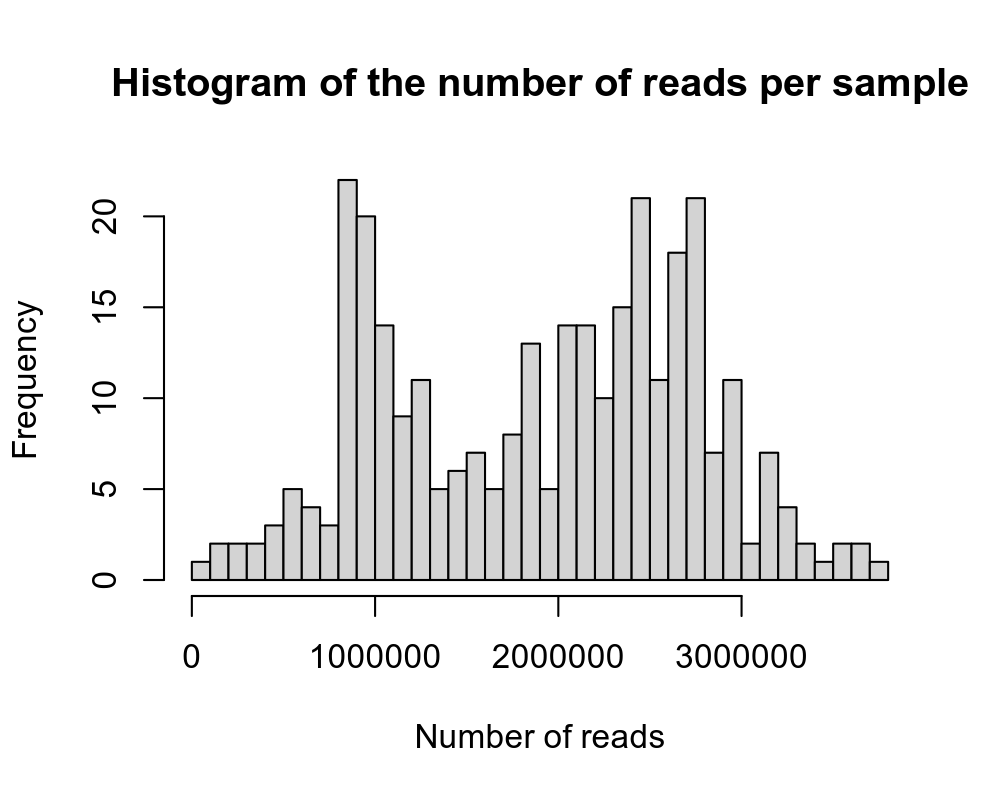

In [179]:
p.dims(5, 4)
cs = colSums(countData)
# histogram of the number of reads per sample
hist(cs, breaks=50, main="Histogram of the number of reads per sample", xlab="Number of reads")

## meta samples: join the precomputed fastq coverage to save for the Suppl.

In [180]:
memeta_2_for_Suppl = memeta_2 %>% inner_join(fastq_coverage, by=c('AnimalID' = 'Sample'))
memeta_2_for_Suppl
test_that("all samples are present in the meta", { expect_equal(nrow(memeta_2), nrow(memeta_2_for_Suppl)) })
# save
write.table(memeta_2_for_Suppl %>% select(AnimalID, readpair_counts), file = file.path(work_dir, "out", "samples_read_counts_Exp2_for_Suppl.txt"), sep = "\t", quote = FALSE, row.names = FALSE)

AnimalID TreatmentID replicate generation AnimalID_of_donor Date_inoculated
1   R1N1C001 Control     R1        N0         TSU201            2020_09_15     
2   R1N1C003 Control     R1        N0         TSU201            2020_09_15     
3   R1N1C005 Control     R1        N0         TSU201            2020_09_15     
⋮   ⋮        ⋮           ⋮         ⋮          ⋮                 ⋮              
309 R4N5T318 Selection   R4        N4         R4N4T272          2020_12_02     
310 R4N5T320 Selection   R4        N4         R4N4T272          2020_12_02     
    Date_dissected BWi34 Body_weight_at_dissection_g_5_6_weeks_old_ Fat_mass_g_
1   2020_09_30     6.71  16.31                                      1.35       
2   2020_09_30     7.29  17.85                                      1.59       
3   2020_09_30     6.95  18.53                                      1.59       
⋮   ⋮              ⋮     ⋮                                          ⋮          
309 2020_12_18     15.78 20.73                                      1.88       
310 2020_12_18     12.87 20.21                                      1.80       
    ⋯ Kynurenine Serotonin   Corticosterone Glutamic_acid Kynurenic_acid
1   ⋯ -0.5238582  0.8309755  0.5748988      -1.2209654     0.13882065   
2   ⋯  1.9201335 -0.4399006  2.4186384       2.4163481     0.08235747   
3   ⋯  0.5738817 -0.7711080  1.6997377       0.8090151    -0.05657939   
⋮   ⋱ ⋮          ⋮           ⋮              ⋮             ⋮             
309 ⋯ -1.1236064 -0.54182161 -1.1214938     -1.2024742    -0.3239339    
310 ⋯ -0.2368544  0.03311371  0.2530819     -0.9848835    -0.1726882    
    y_Aminobutyric_acid_GABA
1   1.506148                
2   0.649170                
3   1.350811                
⋮   ⋮                       
309 -0.9756470              
310 -0.5943937              
    Read1                                                                                                         
1   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C001/R1_final.fq.gz
2   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C003/R1_final.fq.gz
3   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C005/R1_final.fq.gz
⋮   ⋮                                                                                                             
309 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T318/R1_final.fq.gz
310 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T320/R1_final.fq.gz
    Read2                                                                                                         
1   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C001/R2_final.fq.gz
2   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C003/R2_final.fq.gz
3   /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R1N1C005/R2_final.fq.gz
⋮   ⋮                                                                                                             
309 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T318/R2_final.fq.gz
310 /tmp/global2/atyakht/small_projects/Taichi_selection_mice_2023/out/llmgqc_normal/final/R4N5T320/R2_final.fq.gz
    Notes readpair_counts
1   NA    5869900        
2   NA    4822005        
3   NA    2580549        
⋮   ⋮     ⋮              
309 NA    4231682        
310 NA    1523563

Test passed 🎊


## remove outliers by BWi and distance traveled

In [181]:
# save a copy of 310 samples' meta first
memeta_2_n310 = memeta_2

In [182]:
# compute BWi34 N sigma away from the median
# and remove the samples with such values
med_BM34_glob = median(memeta_2$BWi34)
med_BM34_glob
sd_BM34_glob = sd(memeta_2$BWi34)
sd_BM34_glob

bm_min = med_BM34_glob - 3*sd_BM34_glob
bm_min
bm_max = med_BM34_glob + 3*sd_BM34_glob
bm_max

[1] 12.405

[1] 2.889185

[1] 3.737445

[1] 21.07256

In [183]:
# compute dist_trav N sigma away from the median
# and remove the samples with such values
med_dt_glob = median(memeta_2$dist_trav)
med_dt_glob
sd_dt_glob = sd(memeta_2$dist_trav)
sd_dt_glob
dt_min = med_dt_glob - 3*sd_dt_glob
dt_min
dt_max = med_dt_glob + 3*sd_dt_glob
dt_max

[1] 212.8154

[1] 61.82453

[1] 27.34187

[1] 398.289

In [184]:
nrow(memeta_2)
memeta_2 = memeta_2 %>% 
    #filter(Generation_num %in% c(0, 4)) %>% 
    filter((BWi34 > bm_min) & (BWi34 < bm_max)) %>% # leave the "golden middle", sample-wise, BW
	filter((dist_trav > dt_min) & (dist_trav < dt_max)) #%>% # and for the distance traveled        
nrow(memeta_2)

countData = countData[, sort(memeta_2 %>% select(AnimalID) %>% pull())]

test_that("countData and meta match as sets", {
	expect_equal(sort(memeta_2 %>% select(AnimalID) %>% pull), sort(colnames(countData)))
})

[1] 310

[1] 303

Test passed 🎊


## Initially explore the factors

### BWi34

[1] 12.38

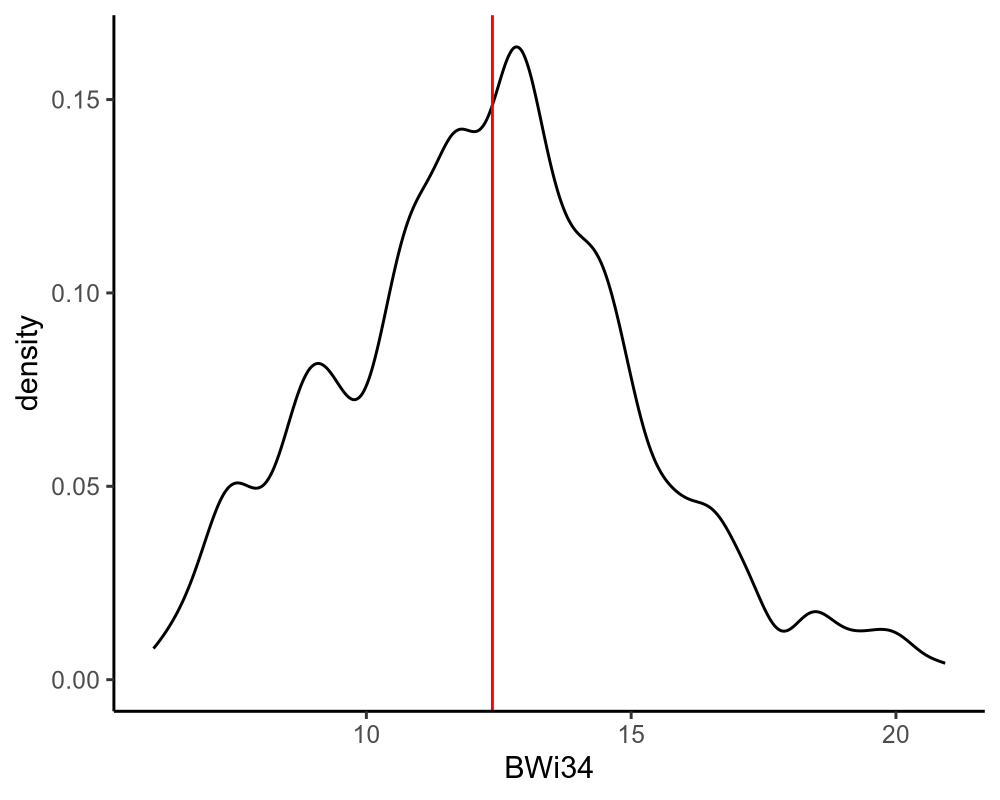

In [185]:
# density plot for BWi34
memeta_2 %>% ggplot(aes(x = BWi34)) + geom_density(adjust = 0.5) + 
# plot median vertical line
geom_vline(aes(xintercept = median(BWi34)), color = "red") +
theme_classic()

median(memeta_2$BWi34)

## (disabled) binarize BWi34
#memeta_2 = memeta_2 %>% mutate(BWi34_group = ifelse(BWi34 < median(BWi34), "0", "1"))

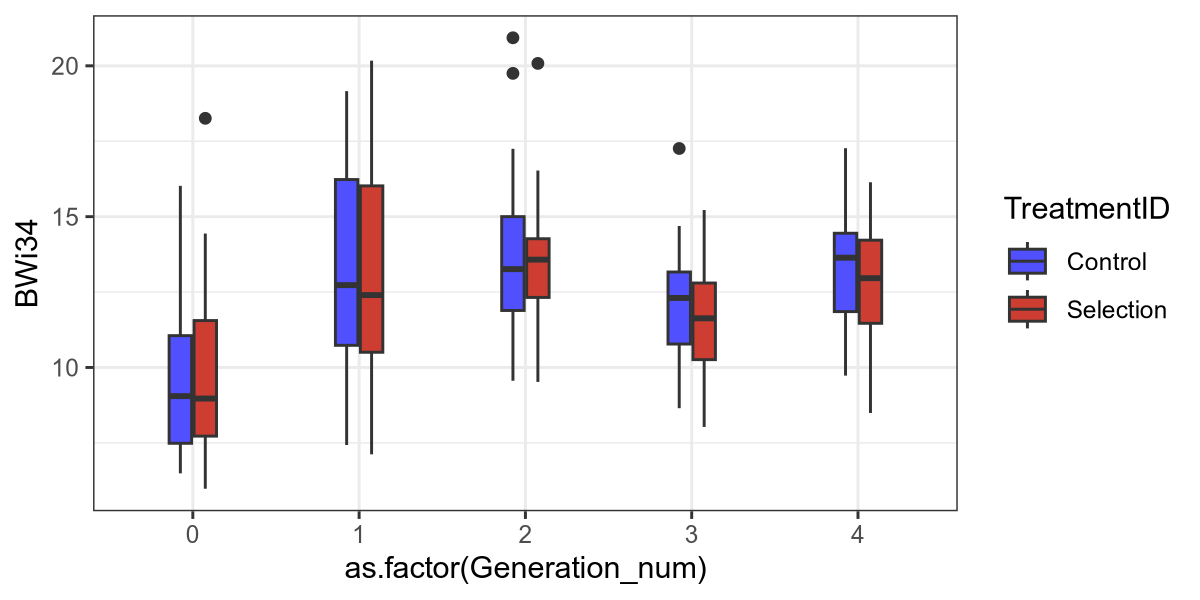

In [186]:
# plot BWi34 vs Generation_num and TreatmentID
p.dims(6, 3)
memeta_2 %>% ggplot(aes(x = as.factor(Generation_num), y = BWi34)) +			
	geom_boxplot(aes(fill = TreatmentID), width = 0.3) +		
	theme_bw() +	
	scale_fill_igv() +
	scale_color_igv()

In [187]:
# Perform Student's t-test to compare BWi34 between the treatment arms in each generation
memeta_2 %>%
    group_by(Generation_num) %>%
    summarise(t_test = (t.test(BWi34 ~ TreatmentID, data = cur_data())$p.value))

Generation_num t_test   
1 0              0.8531842
2 1              0.8959523
3 2              0.8559044
4 3              0.2469816
5 4              0.3998197

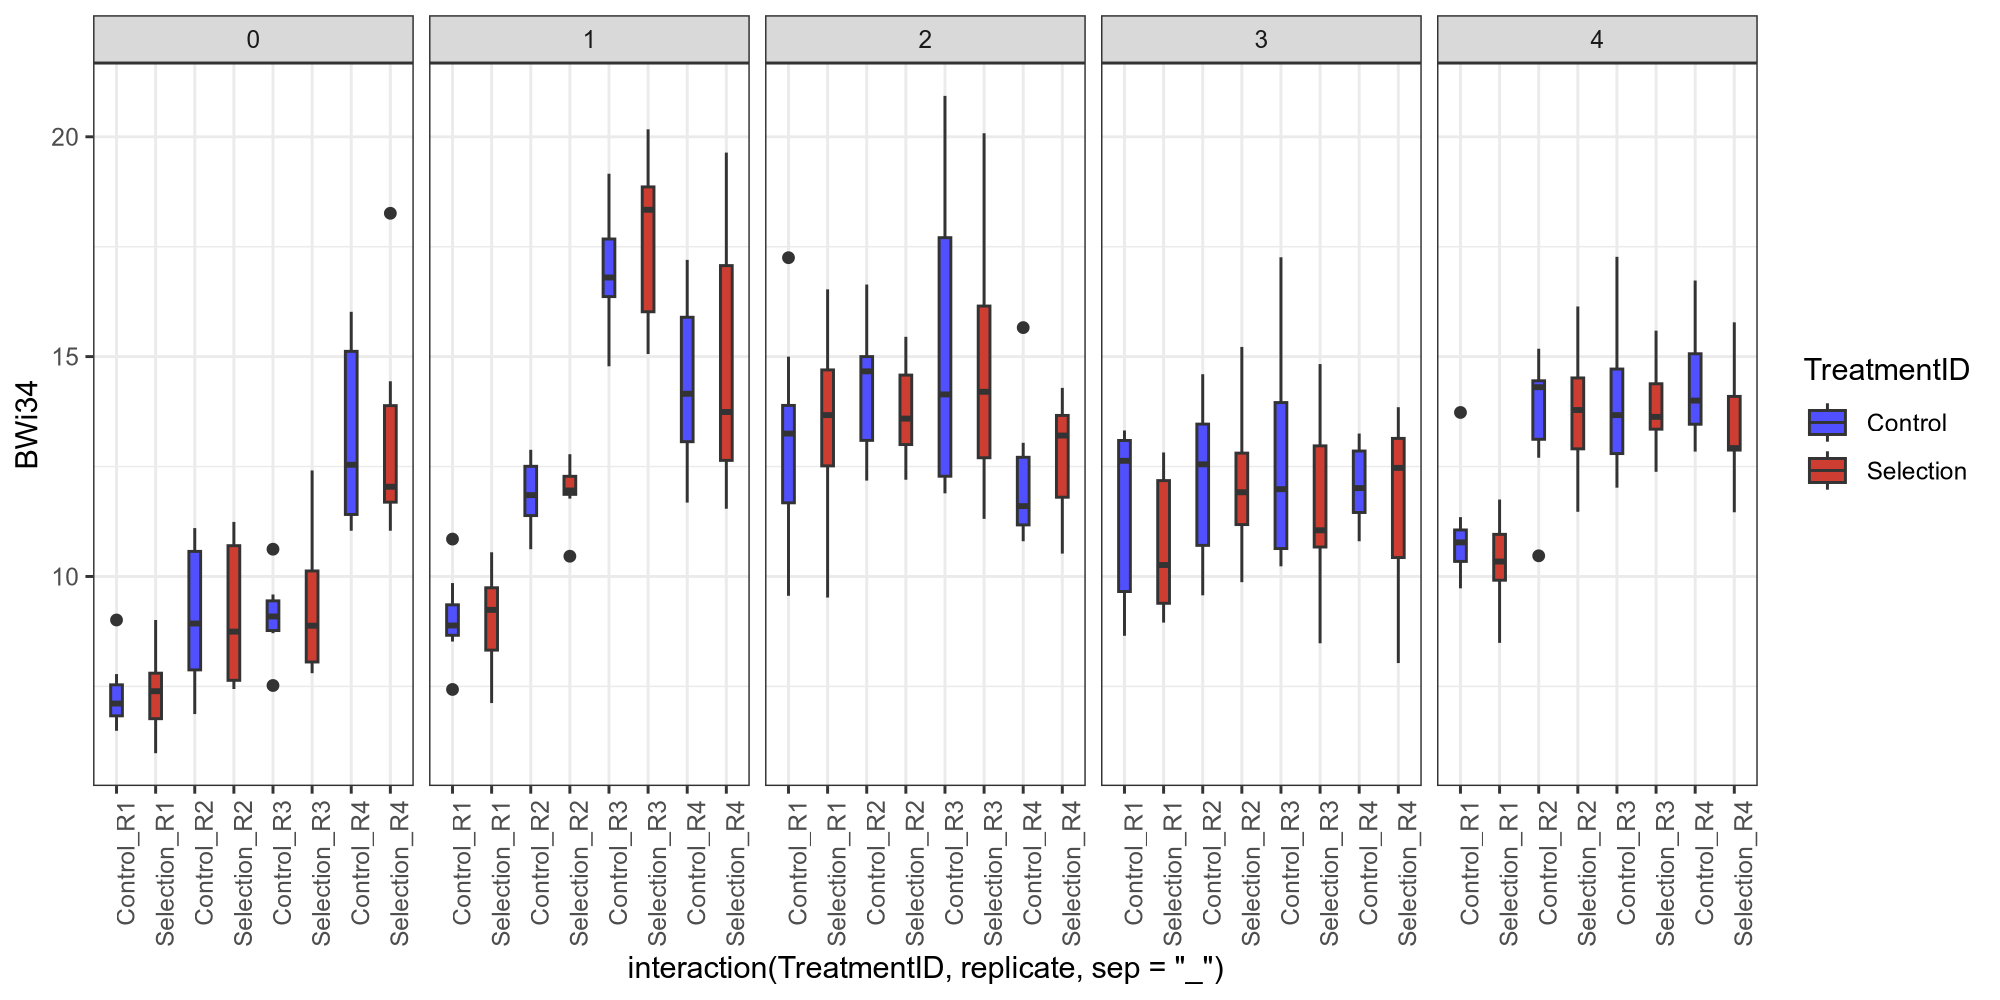

In [188]:
# same stratified by replicate (i.e. effectively plotted per Batch)
p.dims(10, 5)
memeta_2 %>% ggplot(aes(x = interaction(TreatmentID, replicate, sep = "_"), y = BWi34)) +		
    facet_wrap(~Generation_num, nrow = 1) +
    geom_boxplot(aes(fill = TreatmentID), width = 0.3) +	
	
	theme_bw() +	
	scale_fill_igv() +
	scale_color_igv() +
    # flip x axis labels 90
    theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [189]:
# for the generations 3 and 4, match the samples from control and selection by BWi34 using matchit
GENS_TO_BE_BWI_MATCHED = c()
#GENS_TO_BE_BWI_MATCHED = c(3, 4)
#GENS_TO_BE_BWI_MATCHED = c(0:4)
#GENS_TO_BE_BWI_MATCHED = c(0, 4)

if(length(GENS_TO_BE_BWI_MATCHED) > 0) {
    matched_gens = map_dfr(GENS_TO_BE_BWI_MATCHED, function(gen) {
        cur_data = memeta_2 %>% filter(Generation_num == gen) %>% mutate(Treatment_binary = ifelse(TreatmentID == "Control", 0, 1))
        print(nrow(cur_data))
        match_result = matchit(Treatment_binary ~ BWi34, data = cur_data, method = "nearest", caliper = 0.1)
        match_result
        matched_data = match.data(match_result)
        print(nrow(matched_data))
        tidytable(matched_data)
    }) %>% select(-Treatment_binary, -distance, -weights, -subclass)

    test_that("columns in memeta_2 and matched34 match", {
        expect_equal(colnames(memeta_2), colnames(matched_gens))
    })

    # update the respective generations in memeta_2
    memeta_2 = memeta_2 %>% 
        filter(!Generation_num %in% GENS_TO_BE_BWI_MATCHED) %>% 
        bind_rows(matched_gens)
    nrow(memeta_2)
}

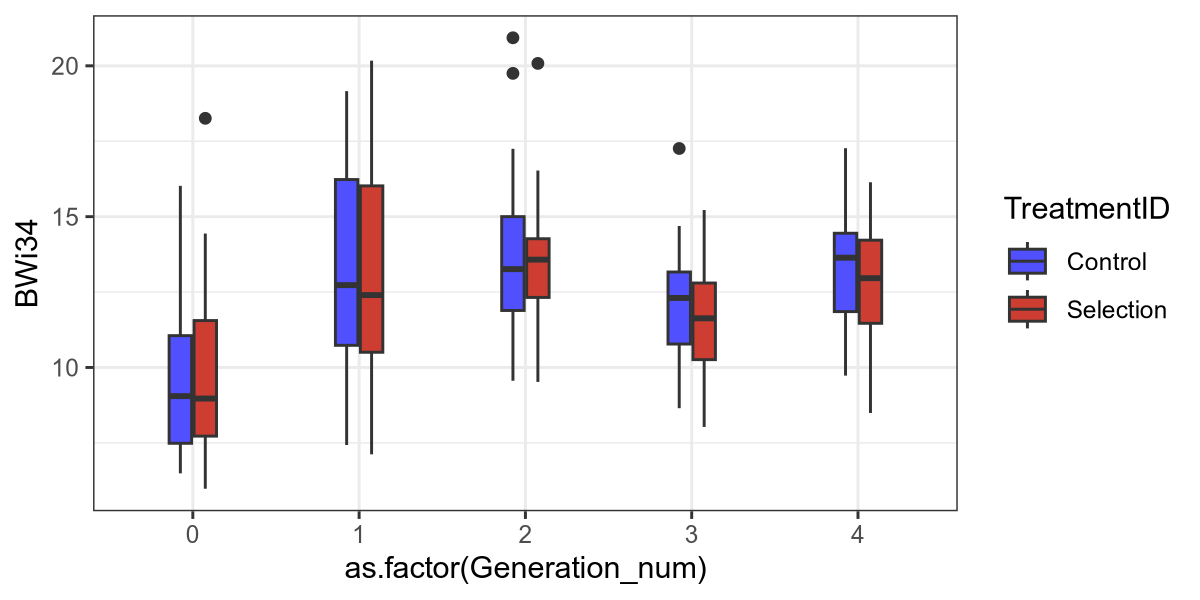

In [190]:
# post-match: plot BWi34 vs Generation_num and TreatmentID
p.dims(6, 3)
memeta_2 %>% ggplot(aes(x = as.factor(Generation_num), y = BWi34)) +			
	geom_boxplot(aes(fill = TreatmentID), width = 0.3) +		
	theme_bw() +	
	scale_fill_igv() +
	scale_color_igv()

### partial correlations

In [191]:
tmp = memeta_2 %>% filter(!is.na(Indolelactic_acid))
nrow(tmp)

# - is Indolelactic_acid ~ BWi34 ?
lm.res.1 <- lm(Indolelactic_acid ~ dist_trav, data = tmp)
lm.res.2 <- lm(BWi34 ~ dist_trav, data = tmp)
r1 <- summary(lm.res.1)$residuals
r2 <- summary(lm.res.2)$residuals
c = cor.test(r1,  r2, method = 'spearman')
print(paste0("BWi34 - ILA rho: ", round(c$estimate, 4), " , p: ", round(c$p.value, 4)))

# - is BWi34 ~ dist_trav ?
lm.res.1 <- lm(BWi34 ~ Indolelactic_acid, data = tmp)
lm.res.2 <- lm(dist_trav ~ Indolelactic_acid, data = tmp)
r1 <- summary(lm.res.1)$residuals
r2 <- summary(lm.res.2)$residuals
c = cor.test(r1,  r2, method = 'spearman')
print(paste0("BWi34 - dist_trav rho: ", round(c$estimate, 4), " , p: ", round(c$p.value, 4)))

# - is Indolelactic_acid ~ dist_trav ?
lm.res.1 <- lm(Indolelactic_acid ~ BWi34, data = tmp)
lm.res.2 <- lm(dist_trav ~ BWi34, data = tmp)
r1 <- summary(lm.res.1)$residuals
r2 <- summary(lm.res.2)$residuals
c = cor.test(r1,  r2, method = 'spearman')
print(paste0("ILA - dist_trav rho: ", round(c$estimate, 4), " , p: ", round(c$p.value, 4)))

[1] 118

[1] "BWi34 - ILA rho: -0.1803 , p: 0.0508"
[1] "BWi34 - dist_trav rho: 0.3018 , p: 0.0009"
[1] "ILA - dist_trav rho: -0.1569 , p: 0.0898"


In [192]:
bbb = memeta_2 %>% select(AnimalID, BWi34, all_of(metabs_united)) %>%     
    filter(!is.na(Indolelactic_acid)) %>%
    pivot_longer(cols = -c(AnimalID, BWi34), names_to = "Molecule_Name", values_to = "value")
bbb

AnimalID BWi34 Molecule_Name            value      
1    R1N1C001 6.71  Indolelactic_acid         0.18496806
2    R1N1C001 6.71  Indoxylsulfate            0.72748833
3    R1N1C001 6.71  Indole_3_propionic_acid  -0.03124921
⋮    ⋮        ⋮     ⋮                        ⋮          
1415 R4N5T320 12.87 Kynurenic_acid           -0.1726882 
1416 R4N5T320 12.87 y_Aminobutyric_acid_GABA -0.5943937

Warning message in geom_smooth(method = "loess", sp = 0.3, se = TRUE, color = "red", :
“Ignoring unknown parameters: `sp`”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


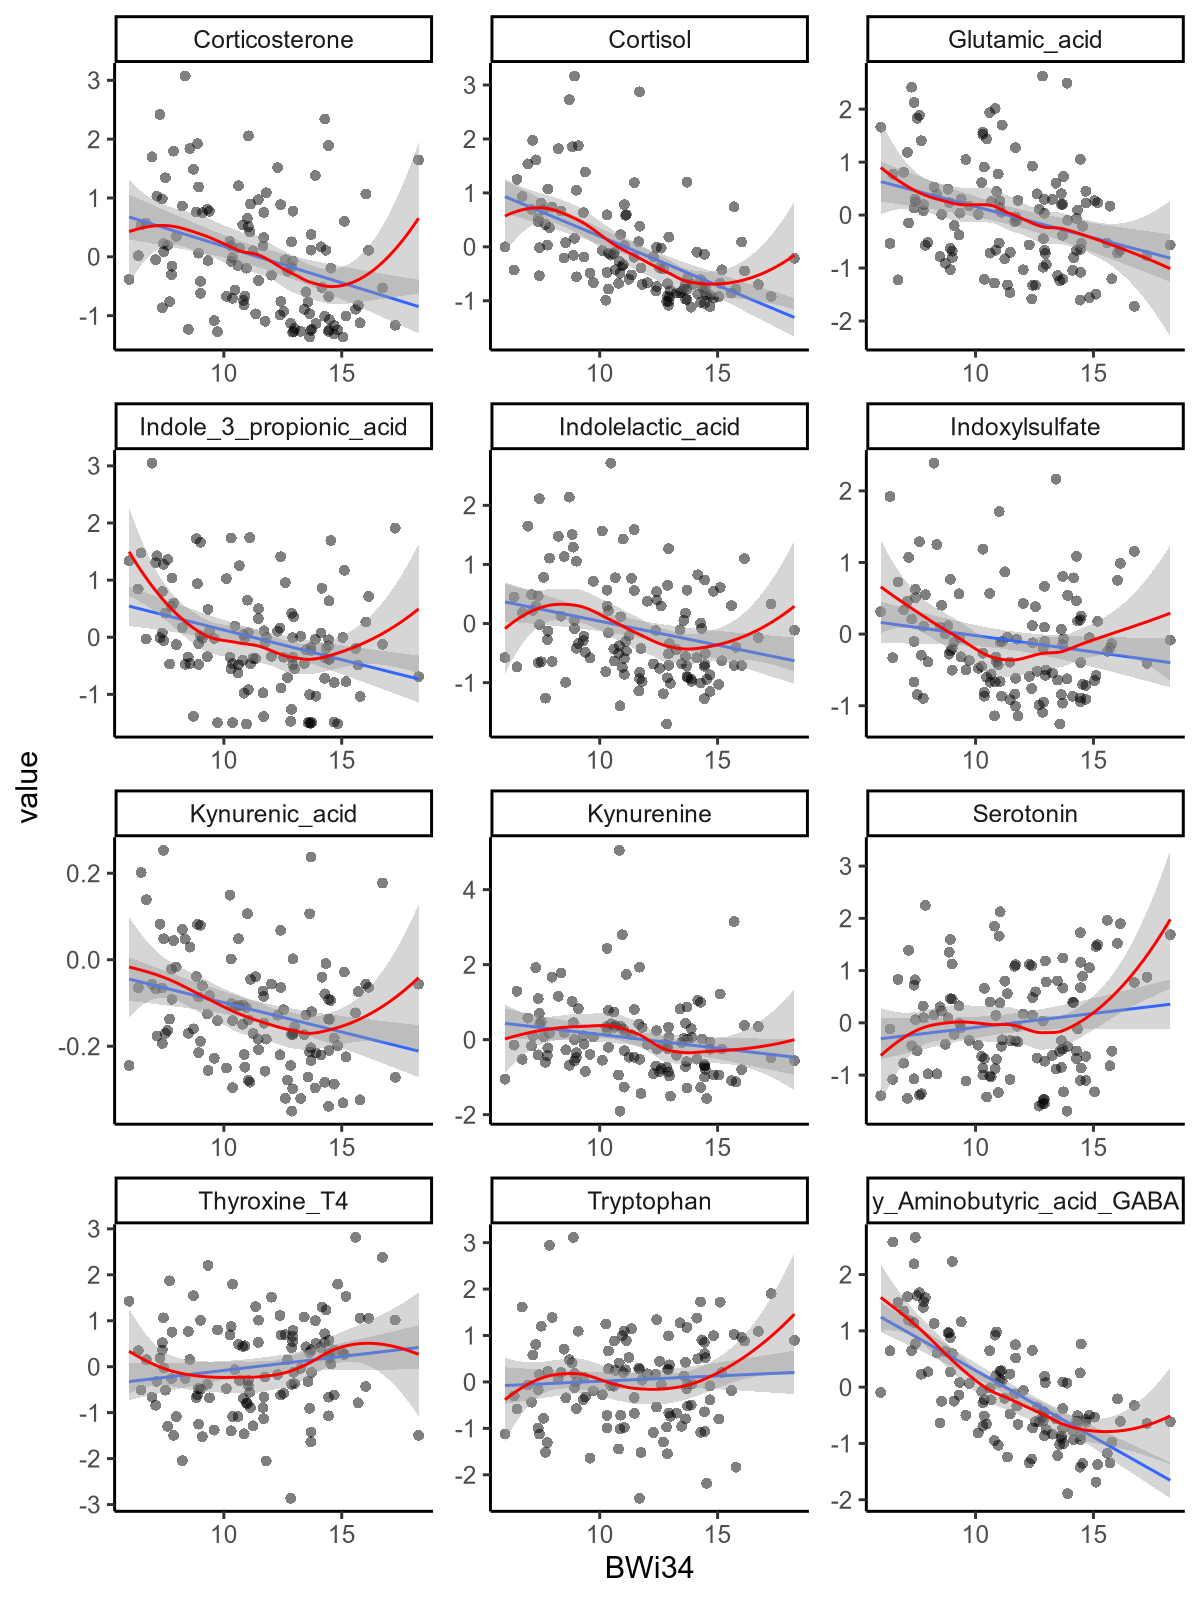

In [193]:
p.dims(6, 8)
bbb %>%
    ggplot(aes(x = BWi34, y = value)) +
    geom_point(size = 1.5, alpha = 0.5, shape = 16) +
    facet_wrap(Molecule_Name ~ ., scales = "free", nrow = 4) +
    theme_classic() +
    geom_smooth(method = "lm", se = TRUE, size = 0.5) +
    geom_smooth(method = "loess", sp = 0.3, se = TRUE, color = "red", size = 0.5) +    
    #geom_smooth(method = "gam", formula = y ~ s(x, sp = 0.05), se = TRUE, color = "blue", size = 0.5) +
    theme(legend.position = "none")

In [194]:
# raw Regression of distance traveled with each metabolite
lm_res = 
    bbb %>%
    nest(data = -Molecule_Name) %>%
    
    mutate(fit = map(data, function(x) {
        lm1 = lm(value ~ BWi34, data = x)                
        return(lm1)
    }),

    tidied = map(fit, tidy)) %>%
    
    select(Molecule_Name, tidied) %>% 

    unnest(tidied) %>%
    filter(term != "(Intercept)") %>% 
    #filter(effect != "ran_pars") %>% 
           
    arrange(desc(term), p.value) %>%
    mutate(p.adj = p.adjust(p.value, method = "fdr"))    
df.dims(100)    
lm_res
df.dims(5)    

Molecule_Name            term  estimate    std.error   statistic  
1  y_Aminobutyric_acid_GABA BWi34 -0.23620299 0.021843126 -10.8136077
2  Cortisol                 BWi34 -0.18254442 0.024786820  -7.3645760
3  Corticosterone           BWi34 -0.12402308 0.031385887  -3.9515557
4  Glutamic_acid            BWi34 -0.11767104 0.030896334  -3.8085760
5  Indole_3_propionic_acid  BWi34 -0.10397069 0.028383479  -3.6630707
6  Kynurenic_acid           BWi34 -0.01355685 0.004140699  -3.2740478
7  Indolelactic_acid        BWi34 -0.08110358 0.027085193  -2.9943880
8  Kynurenine               BWi34 -0.07333535 0.032675664  -2.2443414
9  Indoxylsulfate           BWi34 -0.04572896 0.023723630  -1.9275701
10 Thyroxine_T4             BWi34  0.06055153 0.032986546   1.8356434
11 Serotonin                BWi34  0.05363116 0.032815234   1.6343374
12 Tryptophan               BWi34  0.02298793 0.032237081   0.7130897
   p.value      p.adj       
1  2.843717e-19 3.412460e-18
2  2.799254e-11 1.679552e-10
3  1.338200e-04 5.352800e-04
4  2.250685e-04 6.752056e-04
5  3.769722e-04 9.047333e-04
6  1.397661e-03 2.795322e-03
7  3.362012e-03 5.763448e-03
8  2.670720e-02 4.006080e-02
9  5.635363e-02 7.513818e-02
10 6.897180e-02 8.276617e-02
11 1.048991e-01 1.144354e-01
12 4.772223e-01 4.772223e-01

## Adjust factors for a confounder - BWi34

### distance traveled (LOESS or LM)

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


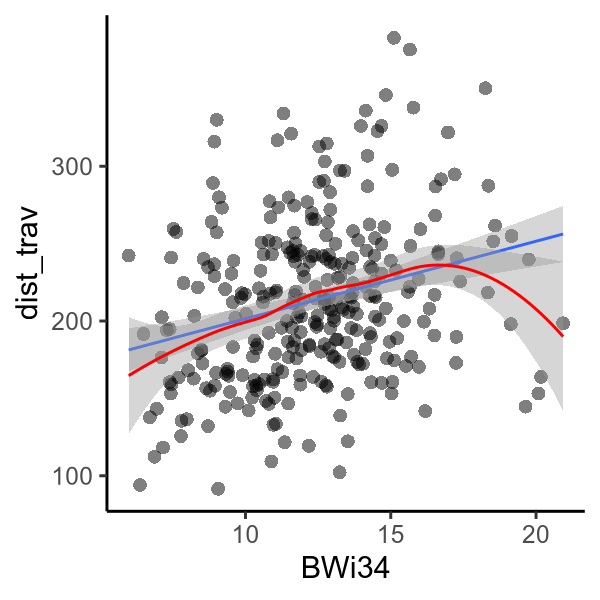

In [195]:
p.dims(3, 3)
memeta_2 %>%
    ggplot(aes(x = BWi34, y = dist_trav)) +
    geom_point(size = 2, alpha = 0.5, shape = 16) +    
    theme_classic() +
    geom_smooth(method = "lm", se = TRUE, size = 0.5) +
    geom_smooth(method = "loess", se = TRUE, color = "red", size = 0.5) +    
    
    theme(legend.position = "none")

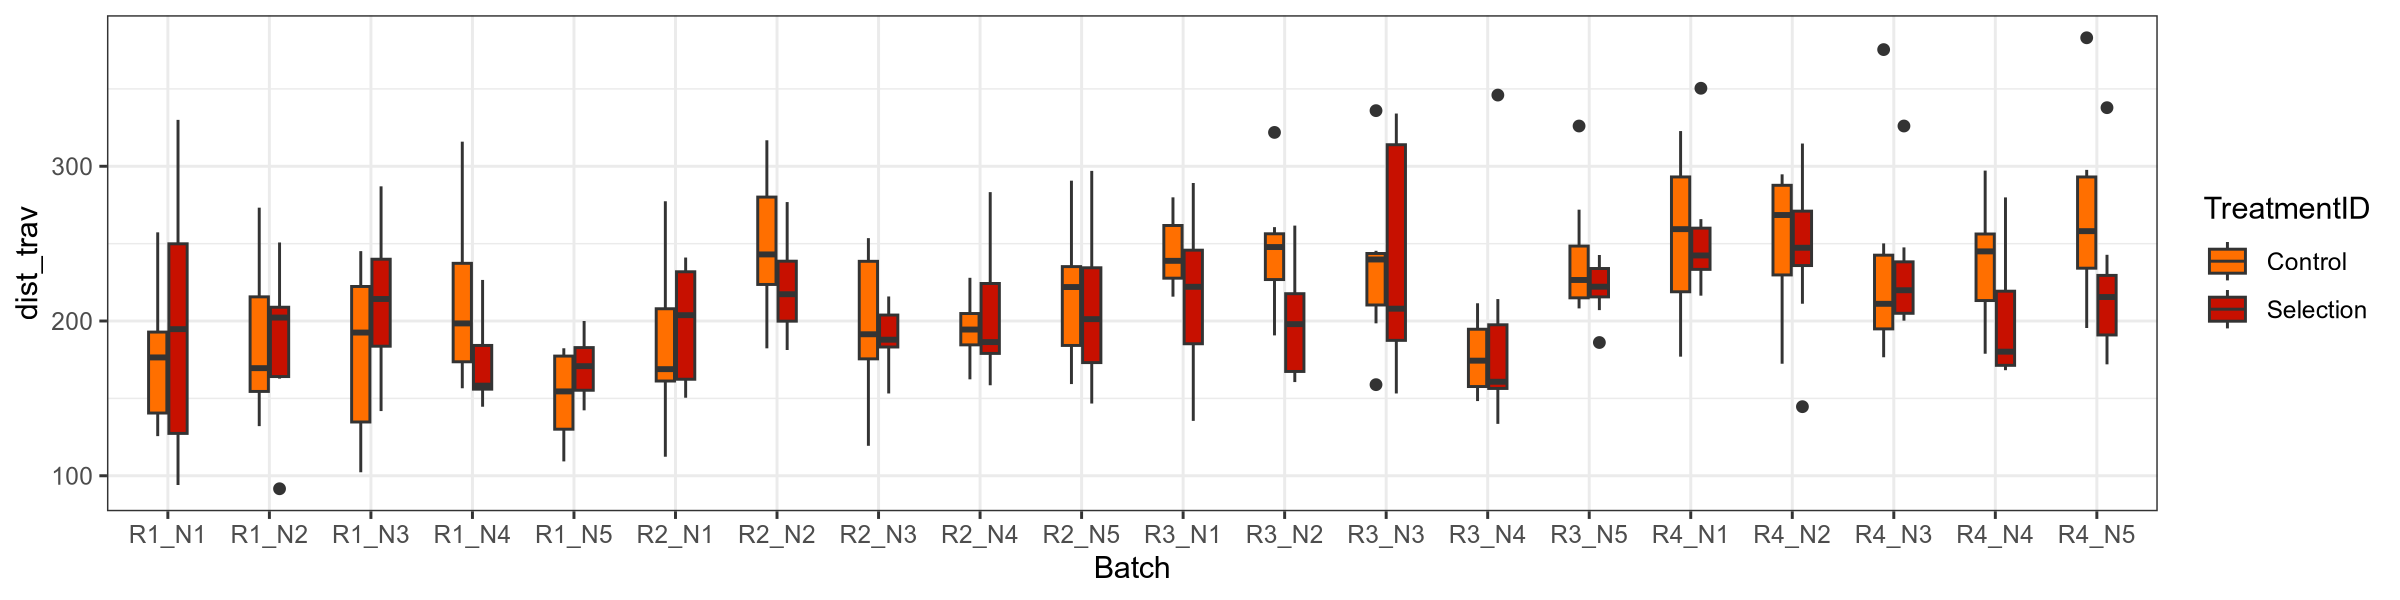

In [196]:
# plot dist_trav per Batch
p.dims(12, 3)
memeta_2 %>% ggplot(aes(x = Batch, y = dist_trav)) +			
    geom_boxplot(aes(fill = TreatmentID), width = 0.4) +		
    theme_bw() +	
    scale_fill_futurama() +
    scale_color_futurama()

In [197]:
## get residuals of dist_trav adjusted for BWi34
# via LOESS
tmp = memeta_2 %>% filter(!is.na(dist_trav))

#model_res_dist = lm(dist_trav ~ BWi34, tmp)
model_res_dist = loess(dist_trav ~ BWi34, tmp, span = 0.75)

res_model_dist = as_tibble(resid(model_res_dist)) %>% 
    rename(res_dist_trav_LOESS = "value") %>% 
    bind_cols(tmp %>% select(AnimalID))
res_model_dist

memeta_2 = memeta_2 %>% left_join(res_model_dist, by = "AnimalID")

res_dist_trav_LOESS AnimalID
1   -34.94761           R1N1C001
2    15.53818           R1N1C003
3   -31.91899           R1N1C005
⋮   ⋮                   ⋮       
302 103.69702           R4N5T318
303  22.95042           R4N5T320

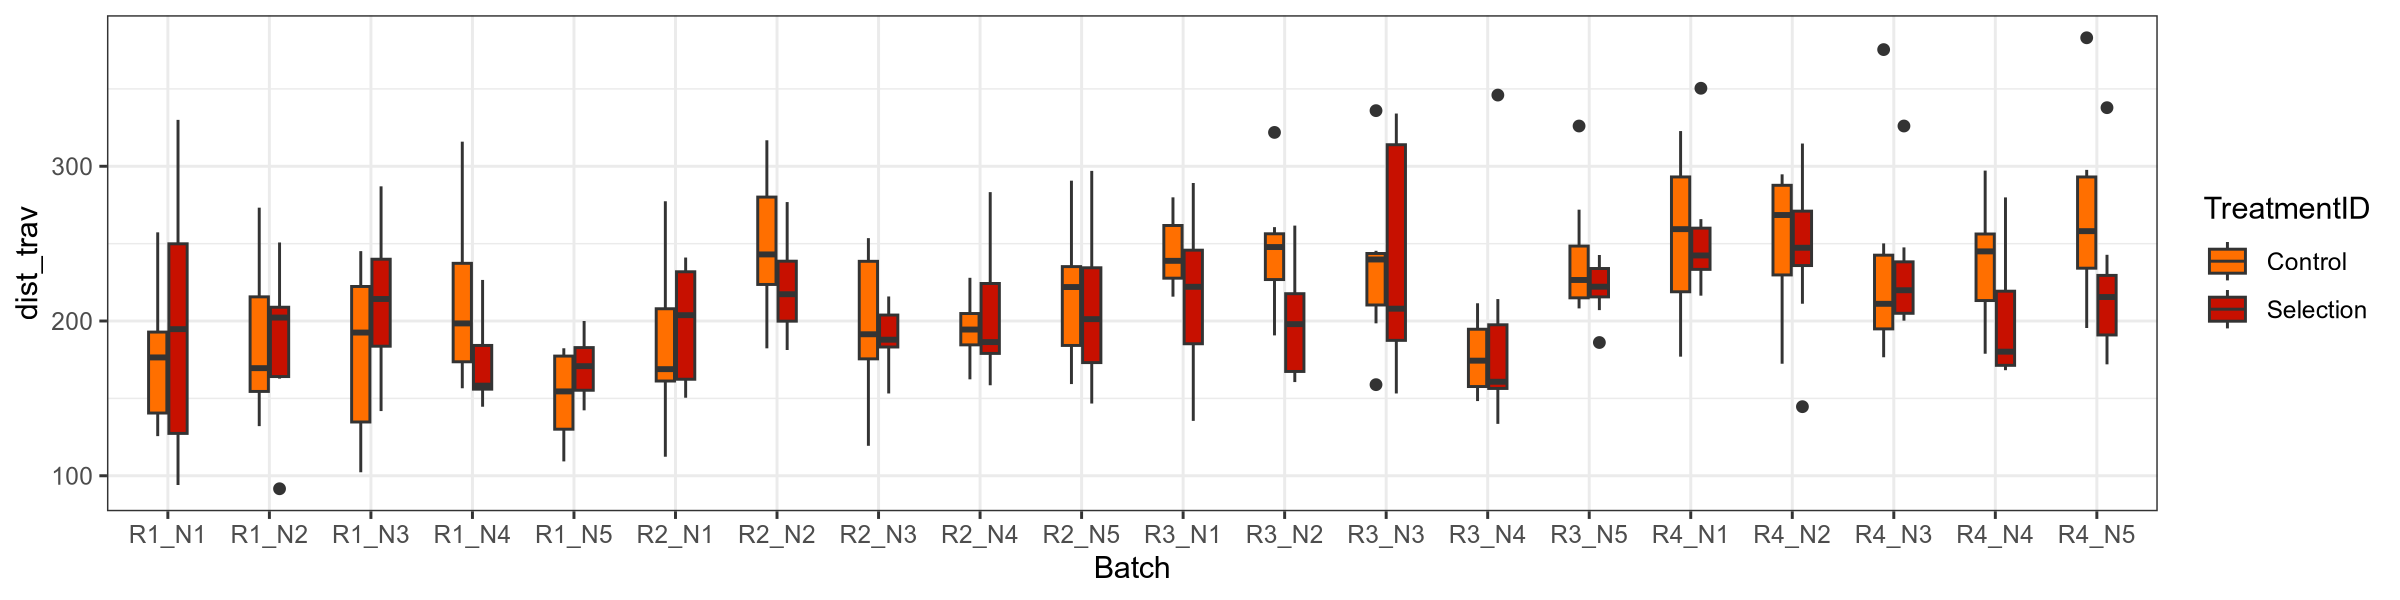

In [198]:
p.dims(12, 3)
memeta_2 %>% ggplot(aes(x = Batch, y = dist_trav)) +			
    geom_boxplot(aes(fill = TreatmentID), width = 0.4) +		
    theme_bw() +	
    scale_fill_futurama() +
    scale_color_futurama()

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


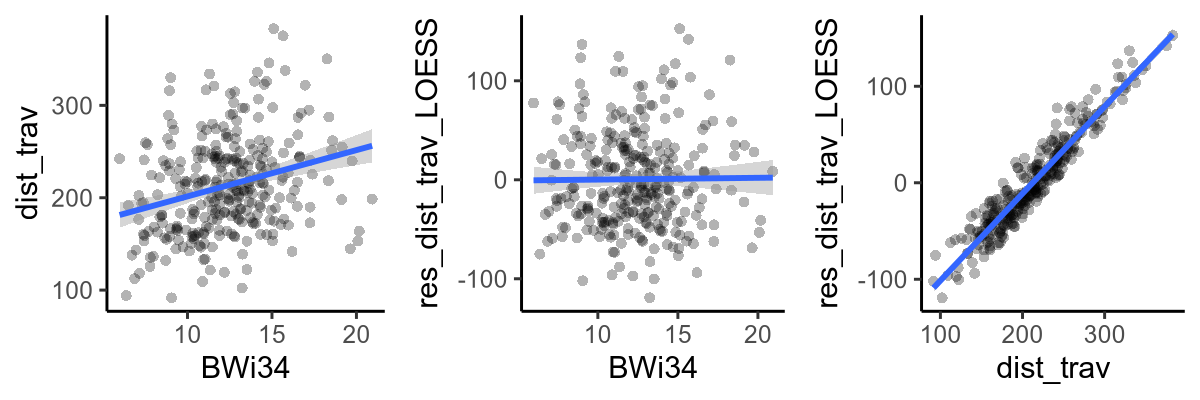

In [199]:
# memeta_2: plot dist_trav vs dist_trav residuals
p.dims(6, 2)
ggpubr::ggarrange(
    memeta_2 %>% ggplot(aes(x = BWi34, y = dist_trav)) + 
        geom_point(alpha = 0.3, shape = 16) + 
        geom_smooth(method = "lm", se = TRUE) + 
        theme_classic(),

    memeta_2 %>% ggplot(aes(x = BWi34, y = res_dist_trav_LOESS)) + 
        geom_point(alpha = 0.3, shape = 16) + 
        geom_smooth(method = "lm", se = TRUE) + 
        theme_classic(),

    memeta_2 %>% ggplot(aes(x = dist_trav, y = res_dist_trav_LOESS)) + 
        geom_point(alpha = 0.3, shape = 16) + 
        geom_smooth(method = "lm", se = TRUE) + 
        theme_classic(),

    nrow = 1
)

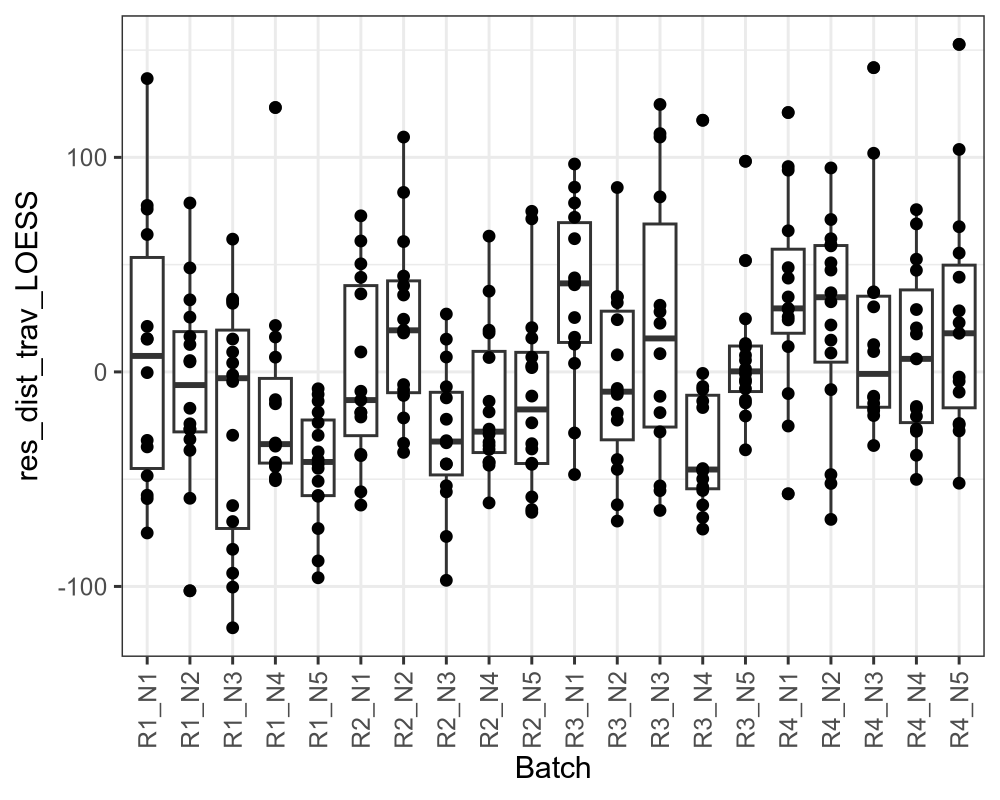

In [200]:
# plot distribution of dist_trav per Batch
p.dims(5, 4)
ggplot(memeta_2, aes(x = Batch, y = res_dist_trav_LOESS)) +
	geom_boxplot() +
	geom_point() +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	#theme(axis.title.x = element_blank()) +
	#theme(axis.title.y = element_blank()) +
	theme(strip.text = element_text(size = 6)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none") + 
	# axis labels
	xlab("Batch")	

### each metabolite (LOESS or LM)

In [201]:
# for each item in metabs_united, calculate residuals of the metabolite adjusted for BWi34
for(metab in metabs_united) {
    tmp = memeta_2 %>% filter(!is.na(!!sym(metab)))
    
    # 1) LM
    #lm_res = lm(reformulate("BWi34", response = metab), tmp)
    # 2) LOESS
    lm_res = loess(reformulate("BWi34", response = metab), data = tmp, span = 0.75)    
    
    res = as_tibble(resid(lm_res)) %>% 
    #res = as_tibble(residuals(lm_res$lme)) %>% 
        rename(!!paste0("res_", metab) := "value") %>% 
        bind_cols(tmp %>% select(AnimalID))
    memeta_2 = memeta_2 %>% left_join(res, by = "AnimalID")
}

### replace with adjusted version(s)

In [202]:
# replace all metabolites with residuals
memeta_2 = memeta_2 %>%
    # select all columns from metabs_united        
    select(-dist_trav, -all_of(metabs_united)) %>%
    rename_with(~gsub("res_", "", .x)) %>% 
    # the two lines below are to use the residuals of dist_trav after whatever adjustment was used
    rename_with(~gsub("_GAMM", "", .x)) %>% 
    rename_with(~gsub("_LOESS", "", .x)) 

In [203]:
# leave only the samples with non-NA values in each of the metabs_united columns
memeta_2_trg = memeta_2 %>% 
	filter(rowSums(is.na(select(., all_of(metabs_united))) > 0) == 0)
memeta_2_trg

AnimalID TreatmentID replicate generation AnimalID_of_donor Date_inoculated
1   R1N1C001 Control     R1        N0         TSU201            2020_09_15     
2   R1N1C003 Control     R1        N0         TSU201            2020_09_15     
3   R1N1C005 Control     R1        N0         TSU201            2020_09_15     
⋮   ⋮        ⋮           ⋮         ⋮          ⋮                 ⋮              
117 R4N5T318 Selection   R4        N4         R4N4T272          2020_12_02     
118 R4N5T320 Selection   R4        N4         R4N4T272          2020_12_02     
    Date_dissected BWi34 Body_weight_at_dissection_g_5_6_weeks_old_ Fat_mass_g_
1   2020_09_30     6.71  16.31                                      1.35       
2   2020_09_30     7.29  17.85                                      1.59       
3   2020_09_30     6.95  18.53                                      1.59       
⋮   ⋮              ⋮     ⋮                                          ⋮          
117 2020_12_18     15.78 20.73                                      1.88       
118 2020_12_18     12.87 20.21                                      1.80       
    ⋯ Indole_3_propionic_acid Cortisol   Tryptophan  Thyroxine_T4 Kynurenine 
1   ⋯ -1.065484               0.2453456   1.73311156  0.02519366  -0.6668299 
2   ⋯ -0.729802               0.8881352   0.77461032  0.19119146   1.6994129 
3   ⋯  2.147966               0.8299338  -0.01378314 -0.73320341   0.3964652 
⋮   ⋱ ⋮                       ⋮          ⋮           ⋮            ⋮          
117 ⋯ -0.9059691              -0.1356461 -2.257129    0.5523505   -0.85886716
118 ⋯ -0.9135559              -0.4382994 -1.405704   -0.2939660    0.04035511
    Serotonin  Corticosterone Glutamic_acid Kynurenic_acid
1    1.1885306 0.06882749     -1.8769956     0.16616567   
2   -0.2474590 1.88683479      1.9199923     0.11988900   
3   -0.4875808 1.17861436      0.2230279    -0.02527093   
⋮   ⋮          ⋮              ⋮             ⋮             
117 -1.0394325 -0.7469192     -0.6388798    -0.187062347  
118  0.2217766  0.5301893     -0.7601085    -0.009911653  
    y_Aminobutyric_acid_GABA
1    0.14916154             
2   -0.51031296             
3    0.07396041             
⋮   ⋮                       
117 -0.1882914              
118 -0.1106562

AnimalID BWi34 Molecule_Name            value       
1    R1N1C001 6.71  Indolelactic_acid         0.0615176  
2    R1N1C001 6.71  Indoxylsulfate            0.2388897  
3    R1N1C001 6.71  Indole_3_propionic_acid  -1.0654844  
⋮    ⋮        ⋮     ⋮                        ⋮           
1415 R4N5T320 12.87 Kynurenic_acid           -0.009911653
1416 R4N5T320 12.87 y_Aminobutyric_acid_GABA -0.110656225

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


Molecule_Name            term  estimate      std.error  statistic   
1  Thyroxine_T4             BWi34  0.0103815426 0.03202796  0.324140003
2  Corticosterone           BWi34 -0.0092662649 0.03040912 -0.304719918
3  y_Aminobutyric_acid_GABA BWi34 -0.0060098253 0.02049372 -0.293251993
4  Cortisol                 BWi34 -0.0068339403 0.02372958 -0.287992513
5  Glutamic_acid            BWi34  0.0076612380 0.03065891  0.249886202
6  Kynurenine               BWi34  0.0072250061 0.03211112  0.225000114
7  Serotonin                BWi34 -0.0047050496 0.03146901 -0.149513723
8  Tryptophan               BWi34 -0.0031241230 0.03127735 -0.099884528
9  Indole_3_propionic_acid  BWi34  0.0025973136 0.02685144  0.096729041
10 Kynurenic_acid           BWi34 -0.0002762030 0.00402359 -0.068645913
11 Indolelactic_acid        BWi34 -0.0016550015 0.02639646 -0.062697866
12 Indoxylsulfate           BWi34 -0.0001494229 0.02260420 -0.006610405
   p.value   p.adj    
1  0.7464158 0.9947371
2  0.7611255 0.9947371
3  0.7698535 0.9947371
4  0.7738664 0.9947371
5  0.8031173 0.9947371
6  0.8223751 0.9947371
7  0.8814079 0.9947371
8  0.9206084 0.9947371
9  0.9231085 0.9947371
10 0.9453897 0.9947371
11 0.9501150 0.9947371
12 0.9947371 0.9947371

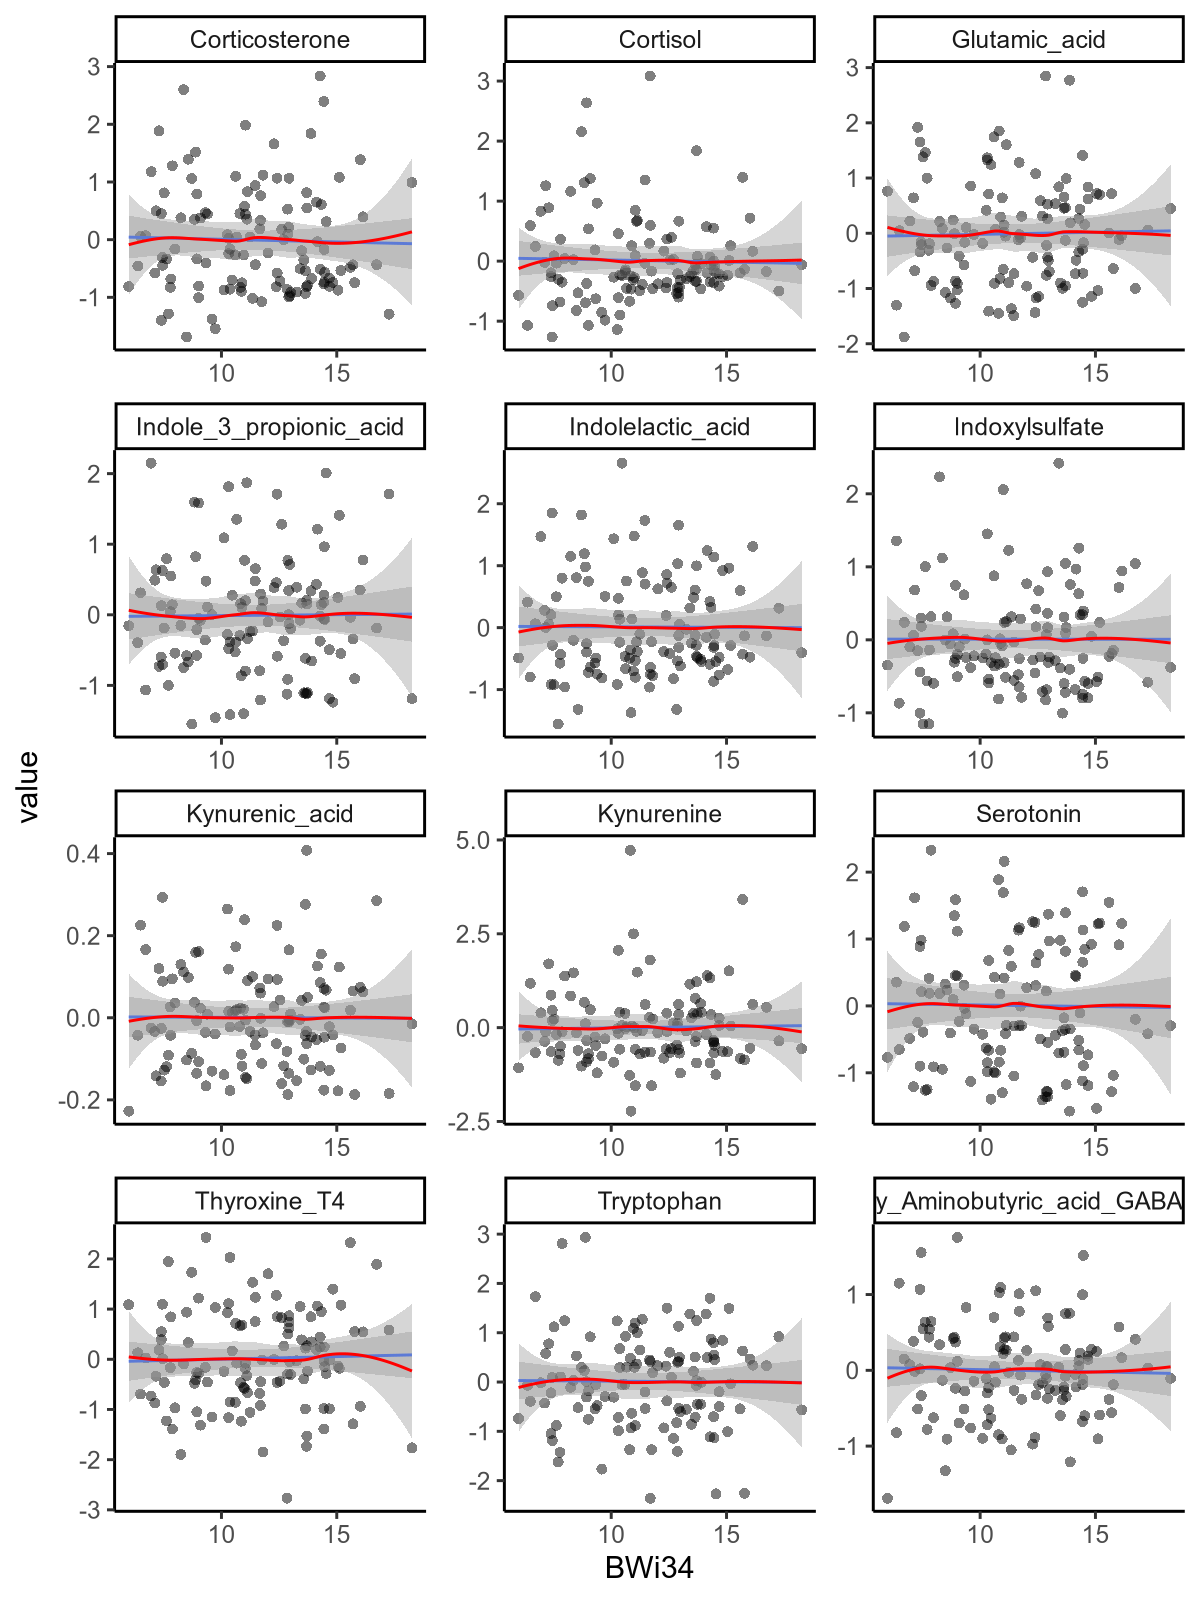

In [204]:
bbb = memeta_2 %>% select(AnimalID, BWi34, all_of(metabs_united)) %>%     
    filter(!is.na(Indolelactic_acid)) %>%
    pivot_longer(cols = -c(AnimalID, BWi34), names_to = "Molecule_Name", values_to = "value")
bbb

p.dims(6, 8)
bbb %>%
    ggplot(aes(x = BWi34, y = value)) +
    geom_point(size = 1.5, alpha = 0.5, shape = 16) +
    facet_wrap(Molecule_Name ~ ., scales = "free", nrow = 4) +
    theme_classic() +
    geom_smooth(method = "lm", se = TRUE, size = 0.5) +
    geom_smooth(method = "loess", se = TRUE, color = "red", size = 0.5) +    
    
    theme(legend.position = "none")


# raw Regression of distance traveled with each metabolite
lm_res = 
    bbb %>%
    nest(data = -Molecule_Name) %>%
    
    mutate(fit = map(data, function(x) {
        lm1 = lm(value ~ BWi34, data = x)                
        return(lm1)
    }),

    tidied = map(fit, tidy)) %>%
    
    select(Molecule_Name, tidied) %>% 

    unnest(tidied) %>%
    filter(term != "(Intercept)") %>% 
    #filter(effect != "ran_pars") %>% 
           
    arrange(desc(term), p.value) %>%
    mutate(p.adj = p.adjust(p.value, method = "fdr"))    
df.dims(100)    
lm_res
df.dims(5)    



# Analysis

### Init normalized abundance and CLR 

In [205]:
# prepare abundance data
abundance_my = cmultRepl2(t(countData))
clr_my <- log(abundance_my) - rowMeans(log(abundance_my)) # CLR transformation
dim(abundance_my)

[1] 303 158

### save a copy so that we can later compute the NB for the full set of samples

In [206]:
countData_full = countData
memeta_2_full = memeta_2
abundance_my_full = abundance_my
clr_my_full = clr_my

In [207]:
memeta_2 %>% filter(!is.na(TreatmentID) & !is.na(Generation_num))

AnimalID TreatmentID replicate generation AnimalID_of_donor Date_inoculated
1   R1N1C001 Control     R1        N0         TSU201            2020_09_15     
2   R1N1C003 Control     R1        N0         TSU201            2020_09_15     
3   R1N1C005 Control     R1        N0         TSU201            2020_09_15     
⋮   ⋮        ⋮           ⋮         ⋮          ⋮                 ⋮              
302 R4N5T318 Selection   R4        N4         R4N4T272          2020_12_02     
303 R4N5T320 Selection   R4        N4         R4N4T272          2020_12_02     
    Date_dissected BWi34 Body_weight_at_dissection_g_5_6_weeks_old_ Fat_mass_g_
1   2020_09_30     6.71  16.31                                      1.35       
2   2020_09_30     7.29  17.85                                      1.59       
3   2020_09_30     6.95  18.53                                      1.59       
⋮   ⋮              ⋮     ⋮                                          ⋮          
302 2020_12_18     15.78 20.73                                      1.88       
303 2020_12_18     12.87 20.21                                      1.80       
    ⋯ Indole_3_propionic_acid Cortisol   Tryptophan  Thyroxine_T4 Kynurenine 
1   ⋯ -1.065484               0.2453456   1.73311156  0.02519366  -0.6668299 
2   ⋯ -0.729802               0.8881352   0.77461032  0.19119146   1.6994129 
3   ⋯  2.147966               0.8299338  -0.01378314 -0.73320341   0.3964652 
⋮   ⋱ ⋮                       ⋮          ⋮           ⋮            ⋮          
302 ⋯ -0.9059691              -0.1356461 -2.257129    0.5523505   -0.85886716
303 ⋯ -0.9135559              -0.4382994 -1.405704   -0.2939660    0.04035511
    Serotonin  Corticosterone Glutamic_acid Kynurenic_acid
1    1.1885306 0.06882749     -1.8769956     0.16616567   
2   -0.2474590 1.88683479      1.9199923     0.11988900   
3   -0.4875808 1.17861436      0.2230279    -0.02527093   
⋮   ⋮          ⋮              ⋮             ⋮             
302 -1.0394325 -0.7469192     -0.6388798    -0.187062347  
303  0.2217766  0.5301893     -0.7601085    -0.009911653  
    y_Aminobutyric_acid_GABA
1    0.14916154             
2   -0.51031296             
3    0.07396041             
⋮   ⋮                       
302 -0.1882914              
303 -0.1106562

In [208]:
memeta_2 %>% select(AnimalID, Indolelactic_acid)

AnimalID Indolelactic_acid
1   R1N1C001 0.0615176        
2   R1N1C003 0.0568832        
3   R1N1C005 1.4706464        
⋮   ⋮        ⋮                
302 R4N5T318 -0.1334651       
303 R4N5T320 -0.5362981

In [209]:
# find rows of memeta_2 where the factor named sel_factor is NA
# and remove them from countData
if(sel_factor == "Generation_num:TreatmentID") {
	memeta_2 = memeta_2 %>% filter(!is.na(TreatmentID) & !is.na(Generation_num))
} else {
	memeta_2 = memeta_2 %>% filter(!is.na(.[[sel_factor]]))
}

sel_factor_nonna = memeta_2 %>% select(AnimalID) %>% pull

test_that("All samples in selected meta are in countData", {
	expect_equal(setdiff(sel_factor_nonna, colnames(countData)), character(0))
})

countData = countData[, sel_factor_nonna]
countData

Test passed 😸


R1N1C001 R1N1C003 R1N1C005 R1N1C007 R1N1C009 R1N1C011 R1N1C015
Acetatifactor 200530   149483   24496    113734   65042    211251   43030   
Acutalibacter  15140     9723    6124     16237   15004     16813    9943   
Adlercreutzia   2679     1208     376      1629     784      2111    1125   
⋮             ⋮        ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
X1XD8-76      27017    14209    3348     8725     14352    20243    7433    
Zag111           47       71      58      158       103       72     104    
              R1N1T002 R1N1T004 R1N1T006 ⋯ R4N5C315 R4N5C317 R4N5C319 R4N5T306
Acetatifactor 39205    62947    38315    ⋯ 43371    38495    93989    64497   
Acutalibacter  7201     9016    10657    ⋯ 21937     3971    24403     9972   
Adlercreutzia  1075      443      312    ⋯   456      625      377      408   
⋮             ⋮        ⋮        ⋮        ⋱ ⋮        ⋮        ⋮        ⋮       
X1XD8-76      4734     7064     8169     ⋯ 11370    4270     13995    10522   
Zag111          69       44       72     ⋯   262      44       144      362   
              R4N5T308 R4N5T310 R4N5T312 R4N5T314 R4N5T318 R4N5T320
Acetatifactor 49394    68853    12923    27967    84737    36853   
Acutalibacter 24782    11170     2120     7856    12998     5913   
Adlercreutzia   621      213       94      503     2318     1885   
⋮             ⋮        ⋮        ⋮        ⋮        ⋮        ⋮       
X1XD8-76      10947    13942    2390     3814     11342    5048    
Zag111          216      157      77       29       286      21

### Create filter #2 for samples

In [210]:
to_leave2 = memeta_2 %>% 
	
	#filter(!(Batch %in% c("R3_N2", "R1_N1"))) %>% # experimental: drop highest and lowest BW batches	

	select(AnimalID) %>% pull

if(SELECT_TREATMENT != "both") {
    to_leave2 = intersect(to_leave2,    
        memeta_2 %>% 
            filter(TreatmentID == SELECT_TREATMENT) %>% 
            select(AnimalID) %>% 
            pull()
    )
}

if(SELECT_GENERATION_NUM != "all") {
    to_leave2 = intersect(to_leave2,    
        memeta_2 %>% 
            filter(Generation_num == SELECT_GENERATION_NUM) %>% 
            select(AnimalID) %>% 
            pull()
    )
}

length(to_leave2)

[1] 303

### generate a filtering preview (might visualize pre- and post-filtering data here)

In [211]:
memeta_2_preview = memeta_2 %>% filter(AnimalID %in% to_leave2)
nrow(memeta_2_preview)

[1] 303

In [212]:
countData_preview = countData[, sort(to_leave2)]

#### BWi34 vs dist_trav - pre and post

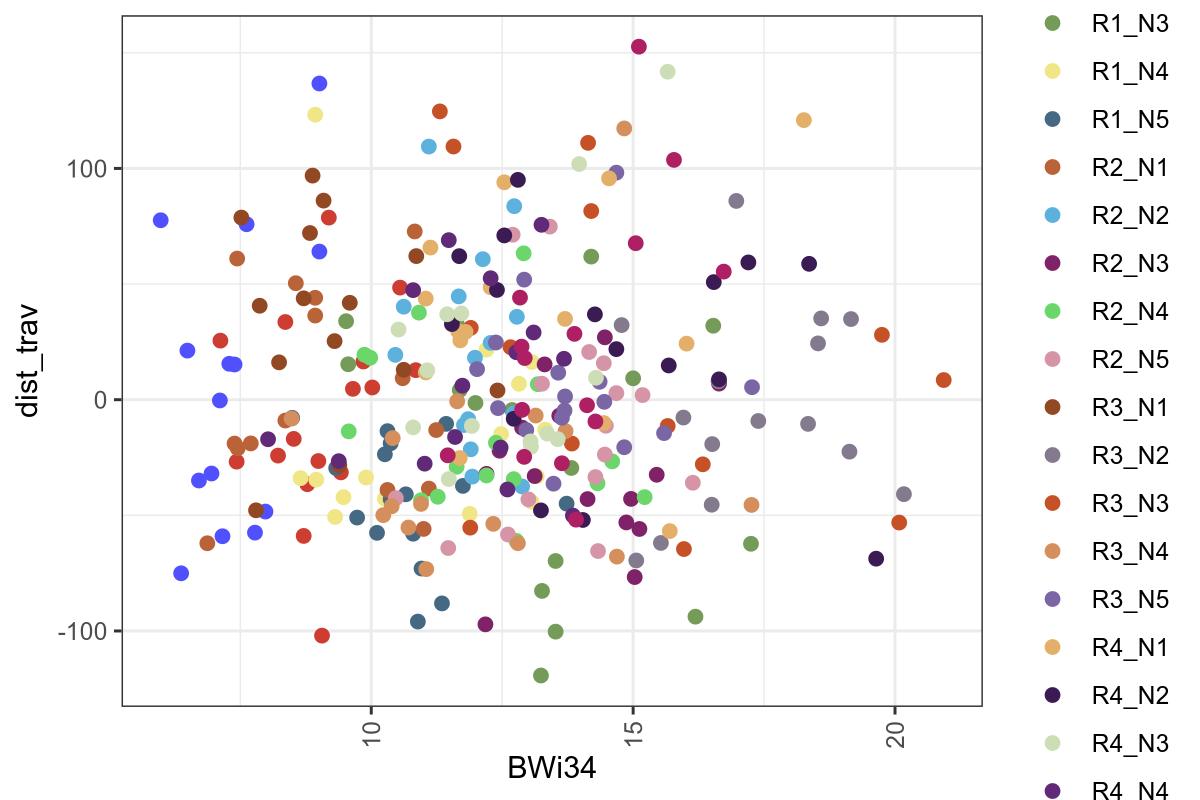

In [213]:
# plot 
p.dims(6, 4)
memeta_2 %>% 
	ggplot(aes(x = BWi34, y = dist_trav, group = Batch)) +
	geom_point(aes(color = Batch), size = 2) +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +	
	theme(strip.text = element_text(size = 8)) +
	theme(strip.background = element_blank()) +
	scale_color_igv()


In [214]:
# correlation between BWi34 and dist_trav
cor.test(memeta_2$BWi34, memeta_2$dist_trav)


	Pearson's product-moment correlation

data:  memeta_2$BWi34 and memeta_2$dist_trav
t = 0.17938, df = 301, p-value = 0.8578
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1024586  0.1228737
sample estimates:
       cor 
0.01033883 


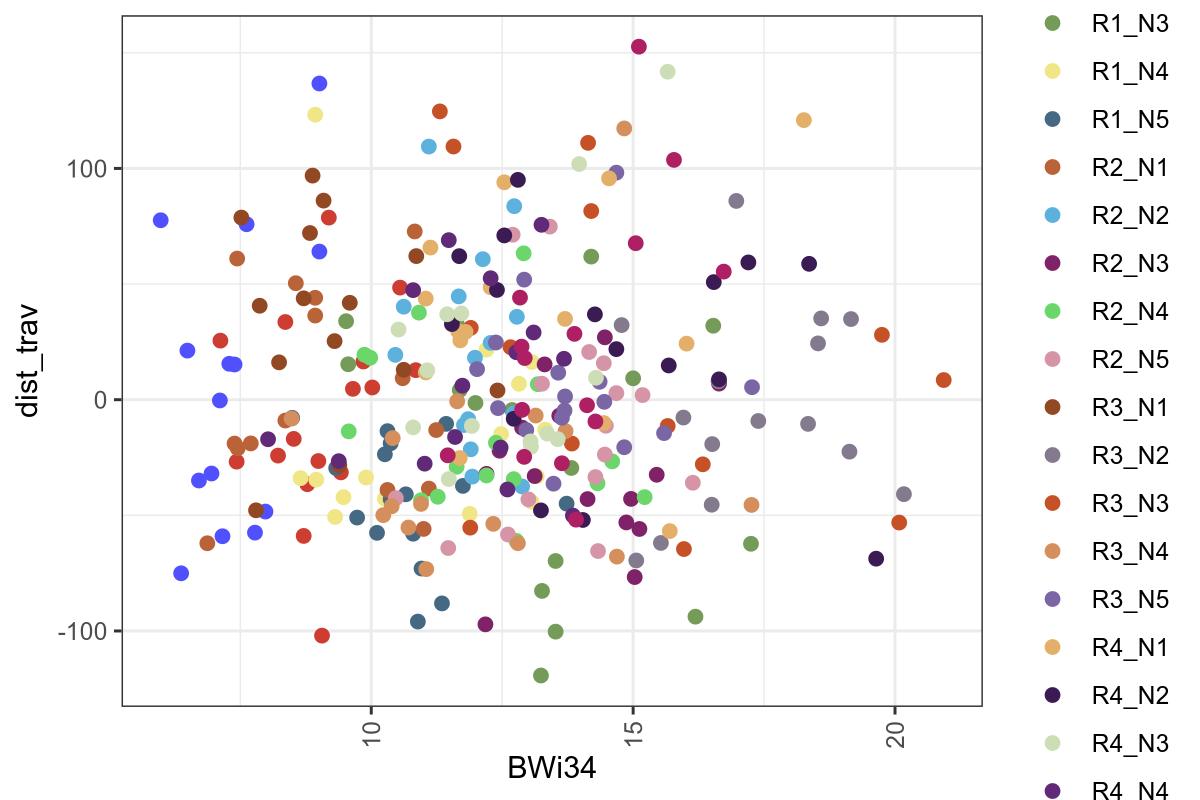

In [215]:
# plot BWi34 against dist_trav
p.dims(6, 4)
memeta_2_preview %>% 
	ggplot(aes(x = BWi34, y = dist_trav, group = Batch)) +
	geom_point(aes(color = Batch), size = 2) +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +	
	theme(strip.text = element_text(size = 8)) +
	theme(strip.background = element_blank()) +
	scale_color_igv()


In [216]:
# correlation between BWi34 and dist_trav
cor.test(memeta_2_preview$BWi34, memeta_2_preview$dist_trav)


	Pearson's product-moment correlation

data:  memeta_2_preview$BWi34 and memeta_2_preview$dist_trav
t = 0.17938, df = 301, p-value = 0.8578
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1024586  0.1228737
sample estimates:
       cor 
0.01033883 


#### BWi34 vs Batch - pre and post

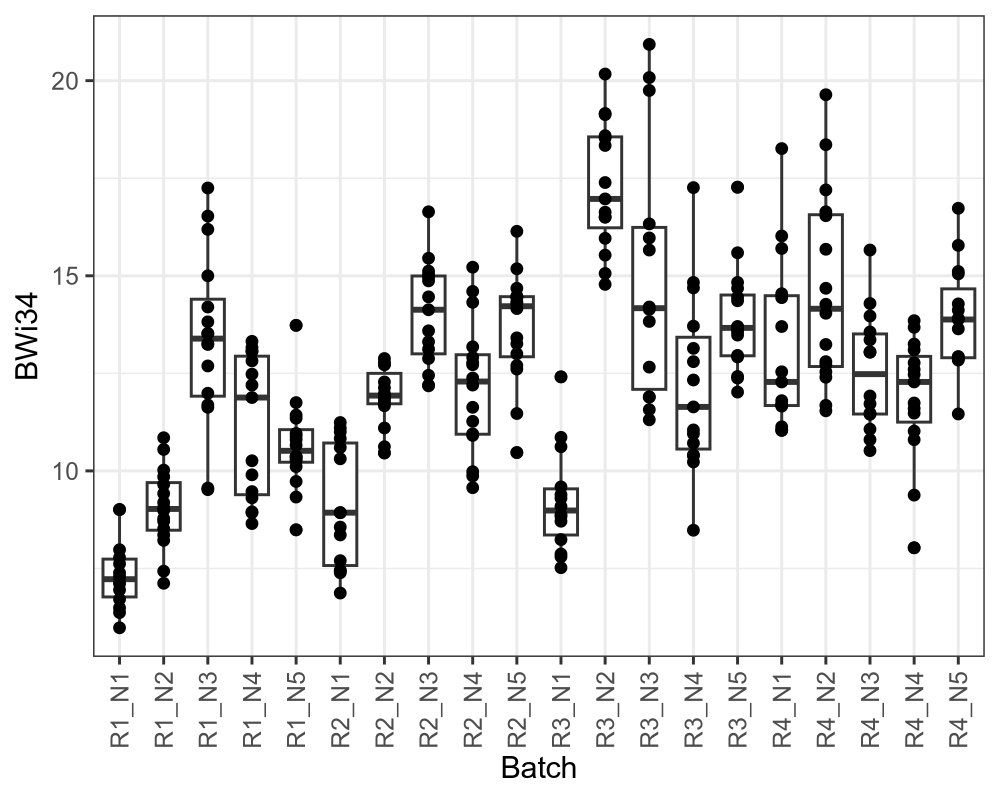

In [217]:
# plot distribution of BWi34 per Batch
p.dims(5, 4)
ggplot(memeta_2, aes(x = Batch, y = BWi34)) +
	geom_boxplot() +
	geom_point() +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	theme(strip.text = element_text(size = 6)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none") + 
	# axis labels
	xlab("Batch") +
	ylab("BWi34")

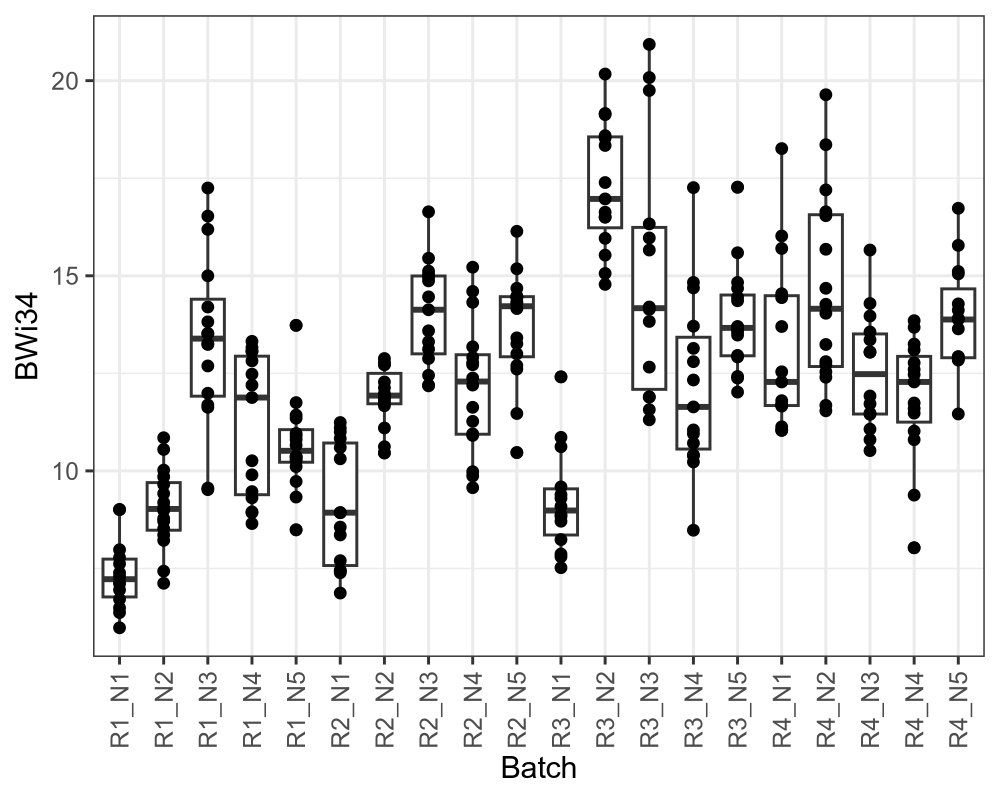

In [218]:
# per Batch - once again, after batch filtering
p.dims(5, 4)
ggplot(memeta_2_preview, aes(x = Batch, y = BWi34)) +
	geom_boxplot() +
	geom_point() +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	theme(strip.text = element_text(size = 6)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none") + 
	# axis labels
	xlab("Batch") +
	ylab("BWi34")

#### dist_trav vs Batch - pre and post

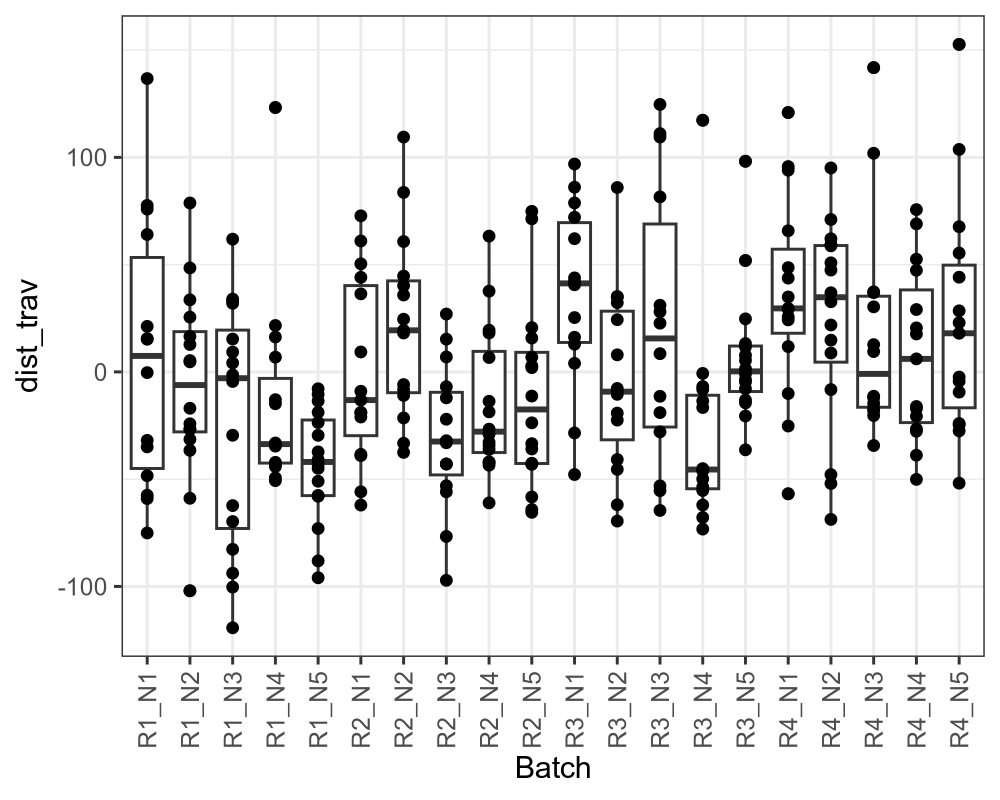

In [219]:
# plot distribution of dist_trav per Batch
p.dims(5, 4)
ggplot(memeta_2, aes(x = Batch, y = dist_trav)) +
	geom_boxplot() +
	geom_point() +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	theme(strip.text = element_text(size = 6)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none") + 
	# axis labels
	xlab("Batch") +
	ylab("dist_trav")

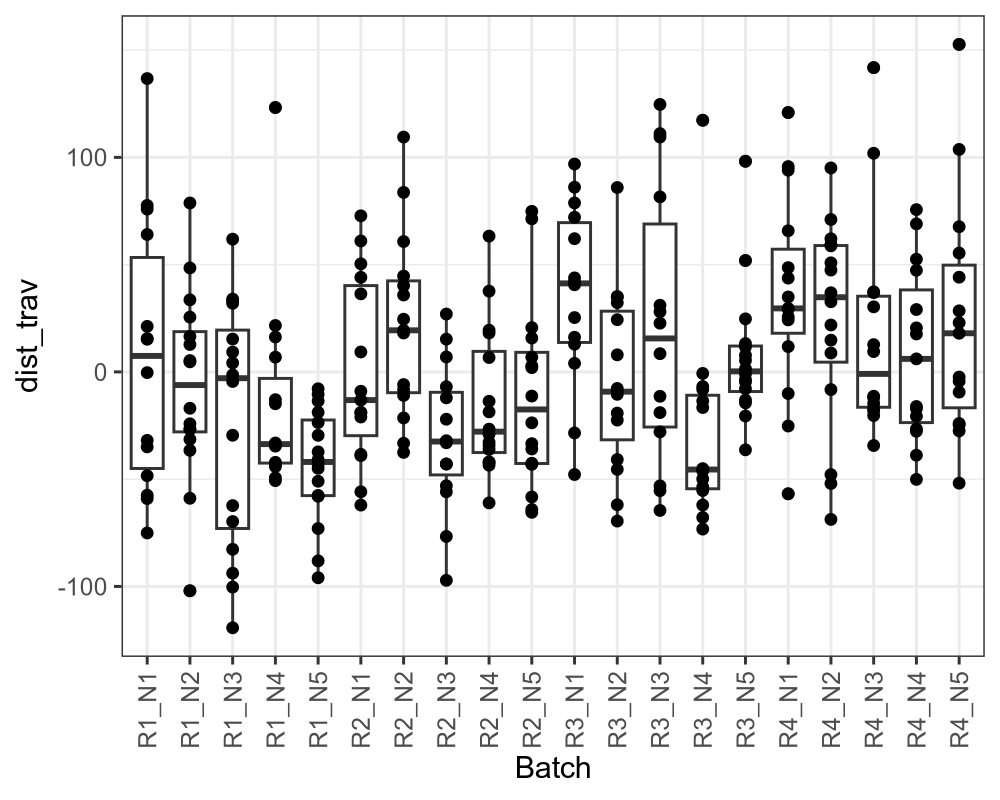

In [220]:
# dist_trav after filtering
p.dims(5, 4)
ggplot(memeta_2_preview, aes(x = Batch, y = dist_trav)) +
	geom_boxplot() +
	geom_point() +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	theme(strip.text = element_text(size = 6)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none") + 
	# axis labels
	xlab("Batch") +
	ylab("dist_trav")

### apply the filter #2

In [221]:
countData = countData_preview
memeta_2 = memeta_2_preview
abundance_my = abundance_my[sort(colnames(countData)),]
clr_my = clr_my[sort(colnames(countData)),]

In [222]:
# apply to the memeta_2_trg as well
memeta_2_trg = memeta_2_trg %>% inner_join(memeta_2 %>% select(AnimalID), by = "AnimalID")
nrow(memeta_2_trg)

[1] 118

In [223]:
test_that("countData and meta match as sets", {
	expect_equal(sort(memeta_2 %>% select(AnimalID) %>% pull), sort(colnames(countData)))
})

Test passed 🎉


### weiter

In [224]:
# prepare a dataframe version of meta and sort it
meta_df = data.frame(memeta_2 %>% column_to_rownames("AnimalID")) 
meta_df = meta_df[order(rownames(meta_df)),]
meta_df

TreatmentID replicate generation AnimalID_of_donor Date_inoculated
R1N1C001 Control     R1        N0         TSU201            2020_09_15     
R1N1C003 Control     R1        N0         TSU201            2020_09_15     
R1N1C005 Control     R1        N0         TSU201            2020_09_15     
⋮        ⋮           ⋮         ⋮          ⋮                 ⋮              
R4N5T318 Selection   R4        N4         R4N4T272          2020_12_02     
R4N5T320 Selection   R4        N4         R4N4T272          2020_12_02     
         Date_dissected BWi34 Body_weight_at_dissection_g_5_6_weeks_old_
R1N1C001 2020_09_30     6.71  16.31                                     
R1N1C003 2020_09_30     7.29  17.85                                     
R1N1C005 2020_09_30     6.95  18.53                                     
⋮        ⋮              ⋮     ⋮                                         
R4N5T318 2020_12_18     15.78 20.73                                     
R4N5T320 2020_12_18     12.87 20.21                                     
         Fat_mass_g_ Lean_mass_g_ ⋯ Indole_3_propionic_acid Cortisol  
R1N1C001 1.35        14.63        ⋯ -1.065484               0.2453456 
R1N1C003 1.59        16.03        ⋯ -0.729802               0.8881352 
R1N1C005 1.59        16.73        ⋯  2.147966               0.8299338 
⋮        ⋮           ⋮            ⋱ ⋮                       ⋮         
R4N5T318 1.88        19.22        ⋯ -0.9059691              -0.1356461
R4N5T320 1.80        18.69        ⋯ -0.9135559              -0.4382994
         Tryptophan  Thyroxine_T4 Kynurenine  Serotonin  Corticosterone
R1N1C001  1.73311156  0.02519366  -0.6668299   1.1885306 0.06882749    
R1N1C003  0.77461032  0.19119146   1.6994129  -0.2474590 1.88683479    
R1N1C005 -0.01378314 -0.73320341   0.3964652  -0.4875808 1.17861436    
⋮        ⋮           ⋮            ⋮           ⋮          ⋮             
R4N5T318 -2.257129    0.5523505   -0.85886716 -1.0394325 -0.7469192    
R4N5T320 -1.405704   -0.2939660    0.04035511  0.2217766  0.5301893    
         Glutamic_acid Kynurenic_acid y_Aminobutyric_acid_GABA
R1N1C001 -1.8769956     0.16616567     0.14916154             
R1N1C003  1.9199923     0.11988900    -0.51031296             
R1N1C005  0.2230279    -0.02527093     0.07396041             
⋮        ⋮             ⋮              ⋮                       
R4N5T318 -0.6388798    -0.187062347   -0.1882914              
R4N5T320 -0.7601085    -0.009911653   -0.1106562

In [225]:
test_that("meta_df and matrices have the same samples in the same order", {
	expect_equal(rownames(meta_df), rownames(clr_my))	
})

Test passed 😸


In [226]:
n_batches = length(unique(memeta_2$Batch))
n_batches
n_batches_in = floor(n_batches * train_prop)
n_batches_in

[1] 20

[1] 13

In [227]:
# though there was initial taxa filtering, some taxa might have become zeroed out during the samples filtering
# so we need to remove them.
# get the names of the rows in countData with fewer than 5 non-zero values
# and remove them from countData and bracken_perc
low_bugs = names(which(rowSums(countData > 0) < 5))

if(length(low_bugs) > 0) {
	print("a")
	countData = countData[-which(rownames(countData) %in% low_bugs),]
	bracken = bracken %>% filter(!name %in% low_bugs)
	bracken_perc = bracken_perc %>% filter(!name %in% low_bugs)
}

## Nearest Balance (fixed effects)

### PERMANOVA

In [228]:
if(!RUN_MIXED_EFFECT_NB) {
	df.dims(12)
	# PERMANOVA
	perma = adonis2(reformulate(init_permanova_formula, response = "dist(clr_my)"), meta_df, permutations = N_PERMANOVA, by = "terms")
	perma
}

Df  SumOfSqs   R2          F         Pr(>F)
dist_trav                    1   344.4677 0.007016251  2.456203 0.0042
BWi34                        1  1021.6298 0.020808946  7.284661 0.0001
replicate                    3  3283.0680 0.066870783  7.803230 0.0001
Generation_num               1  2471.9143 0.050348894 17.625814 0.0001
TreatmentID                  1   395.6061 0.008057857  2.820842 0.0005
Generation_num:TreatmentID   1   347.2864 0.007073663  2.476302 0.0025
Residual                   294 41231.7291 0.839823606        NA     NA
Total                      302 49095.7015 1.000000000        NA     NA

In [229]:
# format and output the table for the manuscript
if(!RUN_MIXED_EFFECT_NB) {
	options(scipen=0)
	perma %>% as.data.frame()  %>% 	
		rownames_to_column(var = "Factor") %>% 
		select(Factor, R2, p = "Pr(>F)") %>% 
		mutate(p = format(p, scientific = FALSE)) %>% 
		mutate(R2 = round(R2, 4)) %>%
		filter(!(Factor %in% c("Residual", "Total"))) %>% 
		mutate(Factor = stringi::stri_replace_all_regex(Factor,
														c("Generation_num:TreatmentID", "dist_trav", "BWi34", "Generation_num", "TreatmentID", "replicate"),
														c("Selection (Round of transfer:Treatment)", "Distance traveled", "Body mass at weaning", "Round of transfer", "Treatment", "Replicate"),
														vectorize = FALSE 
														)) %>% 
		arrange(desc(R2)) %>% 
		write_tsv(file.path(work_dir, "out", "results_init_permanova.tsv"), )
	options(scipen=10)
}

In [230]:
df.dims(20)
adonis2(reformulate(lm_nb_formula, response = "dist(clr_my)"), meta_df, permutations = N_PERMANOVA, by = "terms")
df.dims(5)

Df  SumOfSqs   R2          F         Pr(>F)
dist_trav                    1   344.4677 0.007016251  2.456203 0.0027
BWi34                        1  1021.6298 0.020808946  7.284661 0.0001
replicate                    3  3283.0680 0.066870783  7.803230 0.0001
Generation_num               1  2471.9143 0.050348894 17.625814 0.0001
TreatmentID                  1   395.6061 0.008057857  2.820842 0.0013
Generation_num:TreatmentID   1   347.2864 0.007073663  2.476302 0.0027
Residual                   294 41231.7291 0.839823606        NA     NA
Total                      302 49095.7015 1.000000000        NA     NA

In [231]:
if(!RUN_MIXED_EFFECT_NB) {
	coef_oa_bacs = do_clr_lm_get_fac_coeffs(lm_nb_formula, clr_my, meta_df, sel_factor_coef)
	coef_oa_bacs
}

[1] "Names of coefficients: "
[1] "_Intercept_"                         "dist_trav"                          
[3] "BWi34"                               "replicateR2"                        
[5] "replicateR3"                         "replicateR4"                        
[7] "Generation_num"                      "TreatmentIDSelection"               
[9] "Generation_num_TreatmentIDSelection"


name          lm_coef      
1   Acetatifactor -0.0002800707
2   Acutalibacter -0.0006052972
3   Adlercreutzia -0.0009769102
⋮   ⋮             ⋮            
157 X1XD8-76      -0.0003083695
158 Zag111        -0.0001716710

### Splits for cross-validation

In [232]:
if(!RUN_MIXED_EFFECT_NB) {
	## prepare splits for cross-validation
	splits = caret::createDataPartition(times = n_sim, y = meta_df[[sel_factor]], p = train_prop)
}

Registered S3 method overwritten by 'lava':
  method            from      
  print.equivalence partitions



### Parallel NB generation via cross-validations

In [233]:
if(!RUN_MIXED_EFFECT_NB) {
    nb_list = parallel_run_nb(lm_nb_formula, sel_factor_coef, clr_my, meta_df, splits, n_sim, num_rparallel_cores)
}

### Consensus NB generation

In [234]:
res = aggregate_balance_iterations(nb_list, reproducibility_threshold)
res
sbp_iters = res$sbp_iters
sbp_consensus  = res$sbp_consensus

$sbp_iters
# A tibble: 158 × 105
   taxName      b1_1  b1_2  b1_3  b1_4  b1_5  b1_6  b1_7  b1_8  b1_9 b1_10 b1_11
   <chr>       <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
 1 Acetatifac…     0     0     0     0     0     0     0     0     0     0     0
 2 Acutalibac…     0     0     0     0     0    -1     0     0     0     0    -1
 3 Adlercreut…     0    -1     0    -1     0    -1     0     0    -1     0     0
 4 Agathobact…     1     1     0     1     1     1     1     1     0     0     1
 5 Alistipes       0     0     0     0     0    -1     0     0     0     0    -1
 6 Alistipes_A     0     0     0     0     0    -1     0     0     0     0    -1
 7 Allobaculum     0     0     0     0     0     0     0     0     0     0     0
 8 Alloprevot…     0     0     0     0     0     0     0     0     0     0     0
 9 Amulumrupt…     0     0     0     0    -1     0     0     0     0     0     0
10 An92            0     0     0     0     0     0     0     0     0     0     0
# ℹ 148 more rows
# ℹ 93 more variables: b1_12 <dbl>, b1_13 <dbl>, b1_14 <dbl>, b1_15 <dbl>,
#   b1_16 <dbl>, b1_17 <dbl>, b1_18 <dbl>, b1_19 <dbl>, b1_20 <dbl>,
#   b1_21 <dbl>, b1_22 <dbl>, b1_23 <dbl>, b1_24 <dbl>, b1_25 <dbl>,
#   b1_26 <dbl>, b1_27 <dbl>, b1_28 <dbl>, b1_29 <dbl>, b1_30 <dbl>,
#   b1_31 <dbl>, b1_32 <dbl>, b1_33 <dbl>, b1_34 <dbl>, b1_35 <dbl>,
#   b1_36 <dbl>, b1_37 <dbl>, b1_38 <dbl>, b1_39 <dbl>, b1_40 <dbl>, …

$sbp_consensus
                        b1
Acetatifactor            0
Acutalibacter            0
Adlercreutzia            0
Agathobacter             0
Alistipes                0
Alistipes_A              0
Allobaculum              0
Alloprevotella           0
Amulumruptor             0
An92                     0
Anaerosporobacter        0
Anaerostipes             0
Anaerotignum             0
Anaerotruncus            0
Angelakisella            0
Avispirillum             0
Bacteroides              0
Bilophila                0
Blautia                  0
Blautia_A                0
Butyribacter             0
Butyricimonas            0
BX12                     0
C-19                     0
C-53                     0
Caccovicinus             0
CAG-1031                 0
CAG-115                  0
CAG-303                  0
CAG-317                  0
CAG-485                  0
CAG-510                  0
CAG-56                   0
CAG-590                  0
CAG-603                  0
CAG-83                   0
CAG-873                  0
CAG-95                   0
CAJFPI01                 0
Choladocola              0
Choladousia              0
Clostridium_Q            0
COE1                     0
Coprocola                0
Copromonas               0
Coproplasma              0
Cryptobacteroides        0
Cuneatibacter            0
D16-63                   0
Desulfovibrio            0
DSM-108975               0
Duncaniella              0
DUUS01                   0
Dysosmobacter            0
Eisenbergiella           0
Emergencia               0
Enterenecus              0
Enterocloster            0
Escherichia              0
Eubacterium_F            0
Eubacterium_G            0
Eubacterium_J            0
Eubacterium_R            0
Evtepia                  0
Extibacter               0
Faecalibaculum           0
Faecousia                0
Flavonifractor           0
Gallibacteroides         0
Gallimonas               0
Hungatella               0
Intestinimonas           1
Kineothrix               0
Lachnoclostridium_B      0
Lachnospira              0
Lactobacillus           -1
Lawsonibacter            0
Ligilactobacillus        0
Limosilactobacillus     -1
M3                       0
Mailhella                0
Marseille-P3106          0
Marvinbryantia           0
MD308                    0
Mediterraneibacter       1
Merdisoma                0
MGBC100320               0
MGBC111451               0
MGBC113161               0
MGBC114079               0
MGBC114844               0
MGBC122484               0
MGBC124762               0
M

In [235]:
nb = format_consensus_balance(sbp_consensus)
nb

$b1
$b1$num
[1] "Intestinimonas"     "Mediterraneibacter" "Mobilitalea"       
[4] "Oliverpabstia"      "UMGS1071"          

$b1$den
[1] "Lactobacillus"           "Limosilactobacillus"    
[3] "Phascolarctobacterium_A" "QWKK01"                 


$sbp
                        b1
Acetatifactor            0
Acutalibacter            0
Adlercreutzia            0
Agathobacter             0
Alistipes                0
Alistipes_A              0
Allobaculum              0
Alloprevotella           0
Amulumruptor             0
An92                     0
Anaerosporobacter        0
Anaerostipes             0
Anaerotignum             0
Anaerotruncus            0
Angelakisella            0
Avispirillum             0
Bacteroides              0
Bilophila                0
Blautia                  0
Blautia_A                0
Butyribacter             0
Butyricimonas            0
BX12                     0
C-19                     0
C-53                     0
Caccovicinus             0
CAG-1031                 0
CAG-115                  0
CAG-303                  0
CAG-317                  0
CAG-485                  0
CAG-510                  0
CAG-56                   0
CAG-590                  0
CAG-603                  0
CAG-83                   0
CAG-873                  0
CAG-95                   0
CAJFPI01                 0
Choladocola              0
Choladousia              0
Clostridium_Q            0
COE1                     0
Coprocola                0
Copromonas               0
Coproplasma              0
Cryptobacteroides        0
Cuneatibacter            0
D16-63                   0
Desulfovibrio            0
DSM-108975               0
Duncaniella              0
DUUS01                   0
Dysosmobacter            0
Eisenbergiella           0
Emergencia               0
Enterenecus              0
Enterocloster            0
Escherichia              0
Eubacterium_F            0
Eubacterium_G            0
Eubacterium_J            0
Eubacterium_R            0
Evtepia                  0
Extibacter               0
Faecalibaculum           0
Faecousia                0
Flavonifractor           0
Gallibacteroides         0
Gallimonas               0
Hungatella               0
Intestinimonas           1
Kineothrix               0
Lachnoclostridium_B      0
Lachnospira              0
Lactobacillus           -1
Lawsonibacter            0
Ligilactobacillus        0
Limosilactobacillus     -1
M3                       0
Mailhella                0
Marseille-P3106          0
Marvinbryantia           0
MD308                    0
Mediterraneibacter       1
Merdisoma                0
MGBC100320               0
MGBC111451               0
MGBC113161               0
MGBC114079               0
MGBC114844               0
MGBC122484               0
MGBC124762               0
MGBC136627               0
MGBC157735               0
MGBC162267               0
MGBC163016               0
MGBC164599               0
MGBC165282               0
Mobilitalea              1
Muribaculum              0
Nanosyncoccus            0
NK4A136                  0
NSJ-51                   0
Odoribacter              0
Oliverpabstia            1
Parabacteroides          0
Paralachnospira          0
Paralachnospira_A        0
Paramuribaculum          0
Paraprevotella           0
Pelethomonas             0
Phascolarctobacterium_A -1
Phil12                   0
Phocaeicola              0
Prevotella               0
Pseudobutyricicoccus     0
QWKK01                  -1
QXXE01                   0
RACS-045                 0
RGIG3002                 0
RGIG3040                 0
RGIG4057                 0
RGIG4284                 0
RGIG8607                 0
RGIG8745                 0
RGIG8773                 0
Rikenella                0
Roseburia                0
RUG115                   0
Ruminiclostridium_E      0
Ruminococcus             0
Ruthenibacterium         0
Schaedlerella            0
SIG307                   0
Sodaliphilus             0
Sporofaciens             0
Streptomyces         

In [236]:
balance_size(nb)

$n_num
[1] 5

$n_den
[1] 4

In [237]:
# compute the consensus balance values for each sample 
nb_vals = compute_balance(abundance_my, nb)
#nb_vals

# link metadata to the balance values
nb_vals_meta = nb_vals %>% inner_join(memeta_2, by = c("Sample" = "AnimalID"))
nb_vals_meta

Sample   NB_Value  TreatmentID replicate generation AnimalID_of_donor
1   R1N1C001  2.389733 Control     R1        N0         TSU201           
2   R1N1C003 -1.082313 Control     R1        N0         TSU201           
3   R1N1C005 -2.424407 Control     R1        N0         TSU201           
⋮   ⋮        ⋮         ⋮           ⋮         ⋮          ⋮                
302 R4N5T318 -5.250647 Selection   R4        N4         R4N4T272         
303 R4N5T320 -8.179657 Selection   R4        N4         R4N4T272         
    Date_inoculated Date_dissected BWi34
1   2020_09_15      2020_09_30     6.71 
2   2020_09_15      2020_09_30     7.29 
3   2020_09_15      2020_09_30     6.95 
⋮   ⋮               ⋮              ⋮    
302 2020_12_02      2020_12_18     15.78
303 2020_12_02      2020_12_18     12.87
    Body_weight_at_dissection_g_5_6_weeks_old_ ⋯ Indole_3_propionic_acid
1   16.31                                      ⋯ -1.065484              
2   17.85                                      ⋯ -0.729802              
3   18.53                                      ⋯  2.147966              
⋮   ⋮                                          ⋱ ⋮                      
302 20.73                                      ⋯ -0.9059691             
303 20.21                                      ⋯ -0.9135559             
    Cortisol   Tryptophan  Thyroxine_T4 Kynurenine  Serotonin  Corticosterone
1   0.2453456   1.73311156  0.02519366  -0.6668299   1.1885306 0.06882749    
2   0.8881352   0.77461032  0.19119146   1.6994129  -0.2474590 1.88683479    
3   0.8299338  -0.01378314 -0.73320341   0.3964652  -0.4875808 1.17861436    
⋮   ⋮          ⋮           ⋮            ⋮           ⋮          ⋮             
302 -0.1356461 -2.257129    0.5523505   -0.85886716 -1.0394325 -0.7469192    
303 -0.4382994 -1.405704   -0.2939660    0.04035511  0.2217766  0.5301893    
    Glutamic_acid Kynurenic_acid y_Aminobutyric_acid_GABA
1   -1.8769956     0.16616567     0.14916154             
2    1.9199923     0.11988900    -0.51031296             
3    0.2230279    -0.02527093     0.07396041             
⋮   ⋮             ⋮              ⋮                       
302 -0.6388798    -0.187062347   -0.1882914              
303 -0.7601085    -0.009911653   -0.1106562

### Selected taxa within the balance: check out

In [238]:
df.dims(20)
# Lactos:
# - bracken:
sbp_iters %>% filter(taxName %like% "actobacill")
df.dims(5)

taxName             b1_1 b1_2 b1_3 b1_4 b1_5 b1_6 b1_7 b1_8 b1_9 ⋯ b1_95
1 Lactobacillus       -1   -1   -1   -1   -1   -1   -1   -1   -1   ⋯ -1   
2 Ligilactobacillus    0    0    0   -1    0    0    0    0   -1   ⋯  0   
3 Limosilactobacillus -1   -1    0   -1   -1   -1   -1   -1   -1   ⋯ -1   
  b1_96 b1_97 b1_98 b1_99 b1_100 freq_den freq_num b1_consensus reprod
1 -1    -1    -1    -1    -1     0.99     0        -1           0.99  
2  0     0     0    -1     0     0.26     0         0           0.26  
3 -1    -1    -1    -1    -1     0.95     0        -1           0.95

### Balance values against the factors

`geom_smooth()` using formula = 'y ~ x'


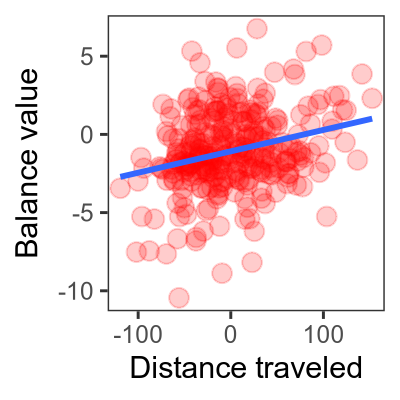

In [239]:
# Plot the relation between the balance values and continuous factor
p.dims(2, 2)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value)) + 	
	geom_jitter(color="red", alpha=0.2, size=3, width=0.2) +
	stat_smooth(method = "lm", se = FALSE) +
	labs(x = factors_nb_plots_inv[sel_factor], y = "Balance value") +	
	theme(legend.position = "none") +
	theme_bw() +
	# disable grid
	theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
	

#### inline mini-plots for the initial Fig. 3 version

In [240]:
if(sel_factor %in% c("TreatmentID", "Generation_num")) {
	p.dims(1.5, 1)
	ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value)) + 
		geom_violin(aes(group = !!sym(sel_factor)), trim = FALSE, color="#555555", size = 0.3) +        
		stat_summary(fun.y = median, geom="point", color="#555555", size = 0.3) +
		labs(x = NULL, y = "Balance value") +	
		theme(legend.position = "none") +
		theme_classic() +
		theme(			
				panel.grid.major = element_blank(),
				panel.grid.minor = element_blank(),			
				axis.text = element_text(size = 4),			
				axis.title = element_text(size = 6),			
				plot.margin = margin(0,0,0,0, "cm")
		)
}

`geom_smooth()` using formula = 'y ~ x'


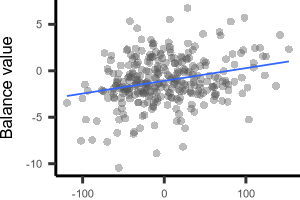

In [241]:
# inline plots for paper
if(sel_factor %in% c("Indolelactic_acid", "dist_trav")) {
	p.dims(1.5, 1)
	ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value)) + 
		geom_point(color="#555555", size = 1, alpha = 0.4, shape = 16) +        	
		geom_smooth(method = "lm", se = FALSE, size = 0.3) +    
		labs(x = NULL, y = "Balance value") +	
		theme(legend.position = "none") +
		theme_classic() +
		theme(			
				panel.grid.major = element_blank(),
				panel.grid.minor = element_blank(),			
				axis.text = element_text(size = 4),			
				axis.title = element_text(size = 6),			
				plot.margin = margin(0,0,0,0, "cm")
		)
}	

#### Suppl. Fig mini-plots

In [242]:
# plots for suppl.
if(sel_factor %in% c("Indolelactic_acid", "Indole_3_propionic_acid")) {
	p.dims(4, 2)
	ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = generation)) + 
		geom_point(size = 2, alpha = 0.7, shape = 16) +        	
		geom_smooth(method = "lm", se = FALSE, size = 1) +
		scale_color_manual("Rounds of transfer", values = c("N0" = "#3782c3", "N4" = "#dd543e")) +
		labs(x = factors_nb_plots_inv[sel_factor], y = "Balance value") +	
		theme(legend.position = "none") +
		theme_classic() +
		theme(			
				panel.grid.major = element_blank(),
				panel.grid.minor = element_blank(),			
				axis.text = element_text(size = 10, color = "black", face = "bold"),			
				axis.title = element_text(size = 10, color = "black", face = "bold"),			
				plot.margin = margin(0.1,0.1,0.1,0.1, "cm")
		)
}

#### further viz

In [243]:
# do regression
nb_vals_meta %>% dplyr::do(broom::tidy(lm(reformulate(sel_factor, response = "NB_Value"), .)))

term        estimate    std.error   statistic p.value             
1 (Intercept) -1.08317773 0.139949862 -7.739756 0.000000000000152117
2 dist_trav    0.01368032 0.002835068  4.825395 0.000002224432197299

`geom_smooth()` using formula = 'y ~ x'


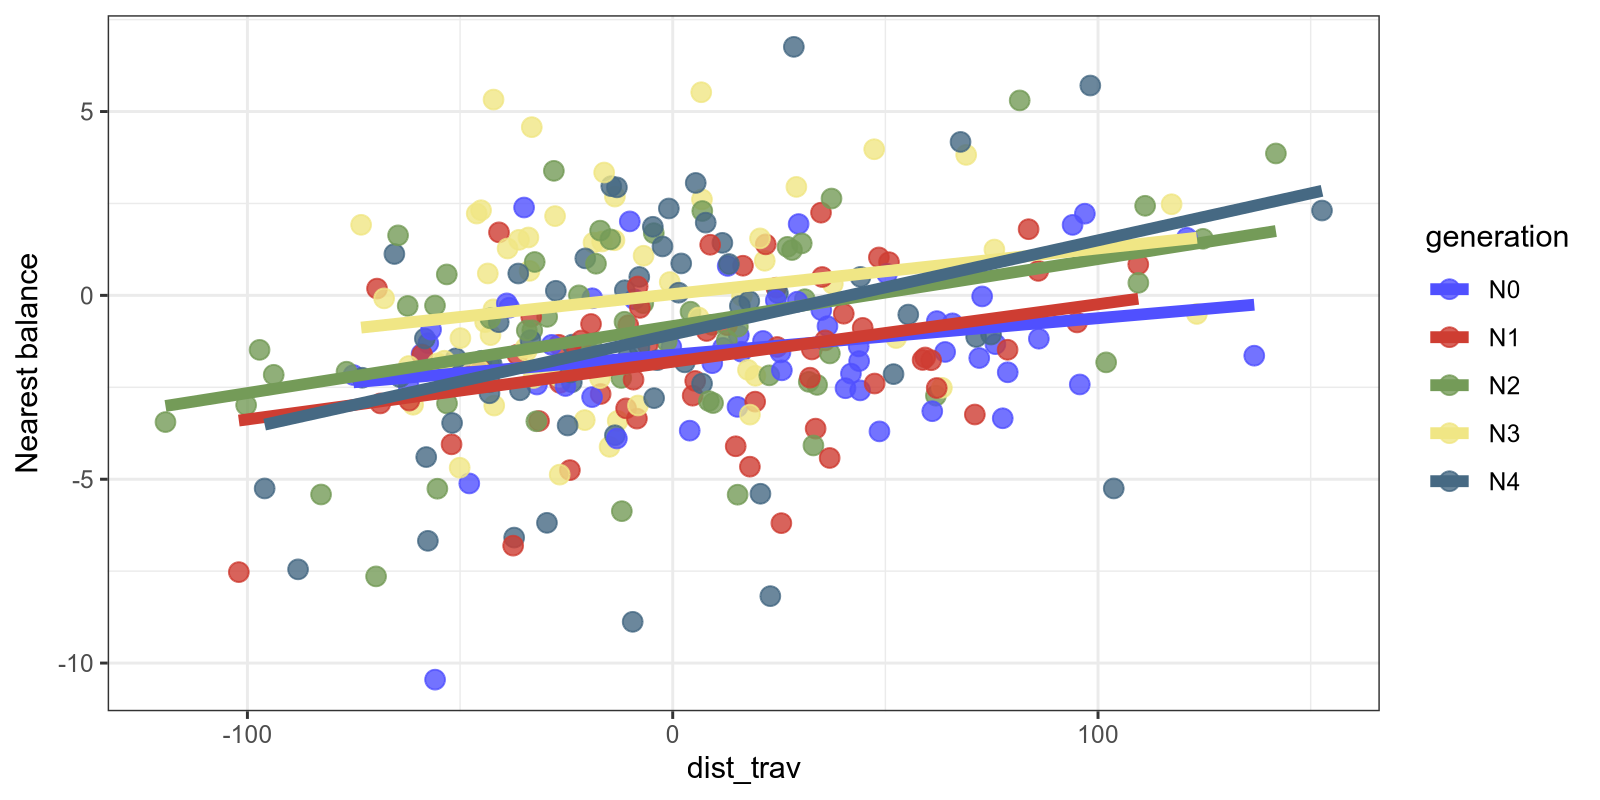

In [244]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = generation)) +
	geom_point(alpha=0.8, size=3) +
	geom_smooth(method = "lm", se = FALSE, size=2) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()	

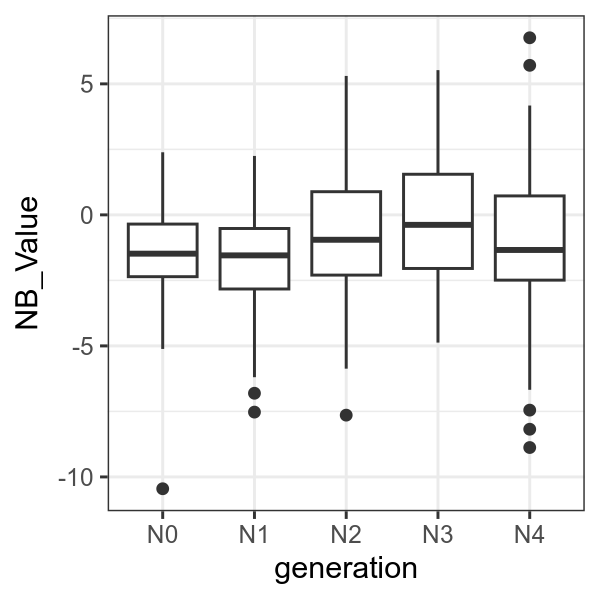

In [245]:
# same plot colored into interesting factors
p.dims(3,3)
ggplot(nb_vals_meta, aes(x = generation, y = NB_Value)) +
	geom_boxplot() + 	
	theme_bw() +
	scale_fill_igv()


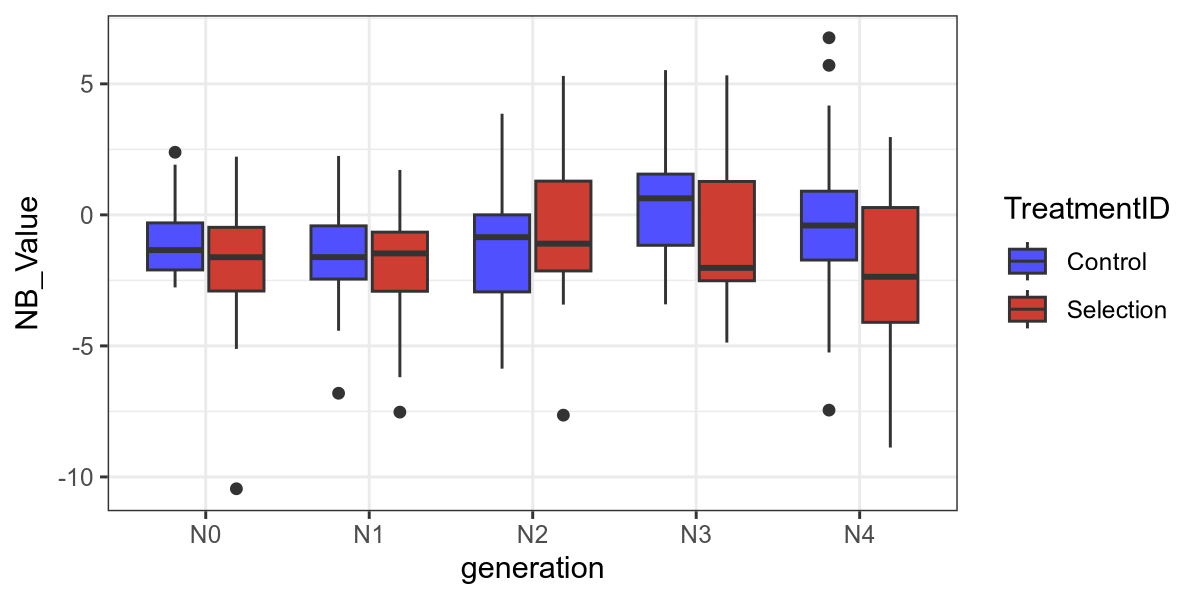

In [246]:
# same plot colored into interesting factors
p.dims(6, 3)
ggplot(nb_vals_meta, aes(x = generation, y = NB_Value)) +
	# also stratify by TreatmentID
	geom_boxplot(aes(fill = TreatmentID)) +
	theme_bw() +
	scale_fill_igv()	

`geom_smooth()` using formula = 'y ~ x'


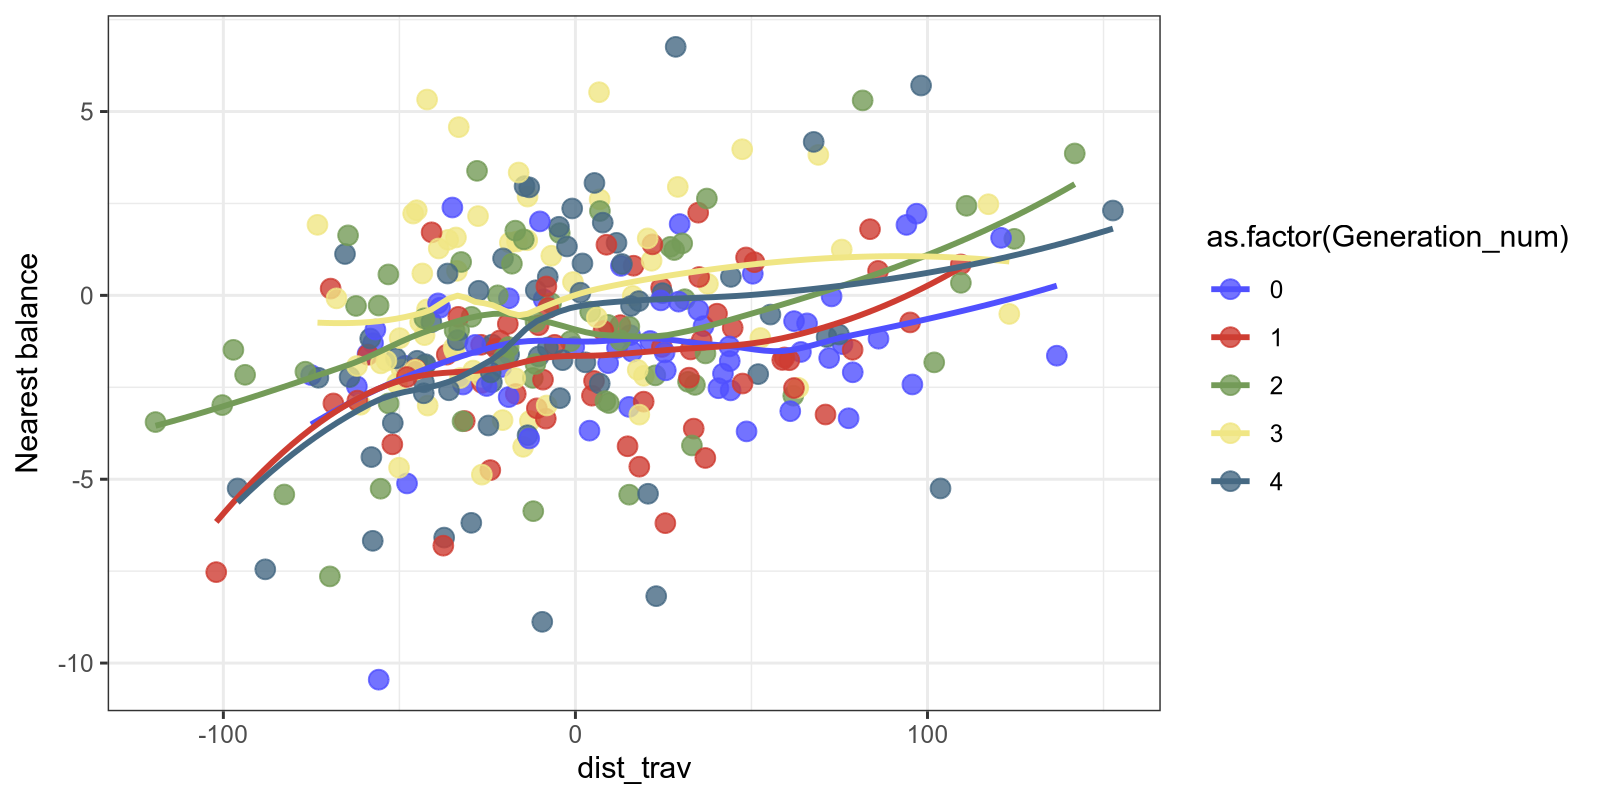

In [247]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = as.factor(Generation_num))) +
	geom_point(alpha=0.8, size=3) +
	stat_smooth(method = "loess", se = FALSE) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()	

`geom_smooth()` using formula = 'y ~ x'


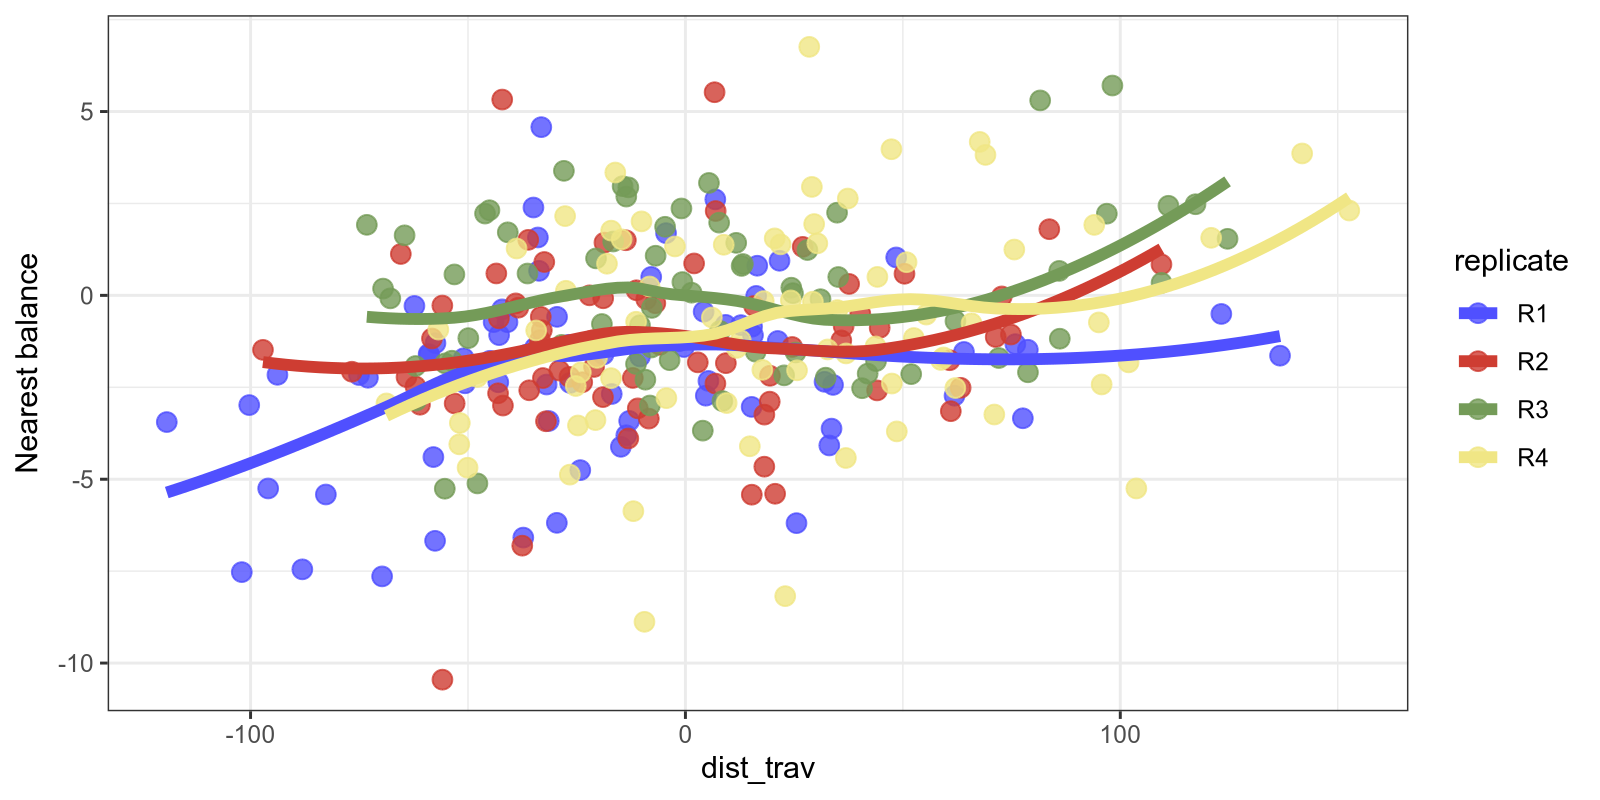

In [248]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = replicate)) +
	geom_point(alpha=0.8, size=3) +
	geom_smooth(method = "loess", se = FALSE, size=2) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()	


`geom_smooth()` using formula = 'y ~ x'


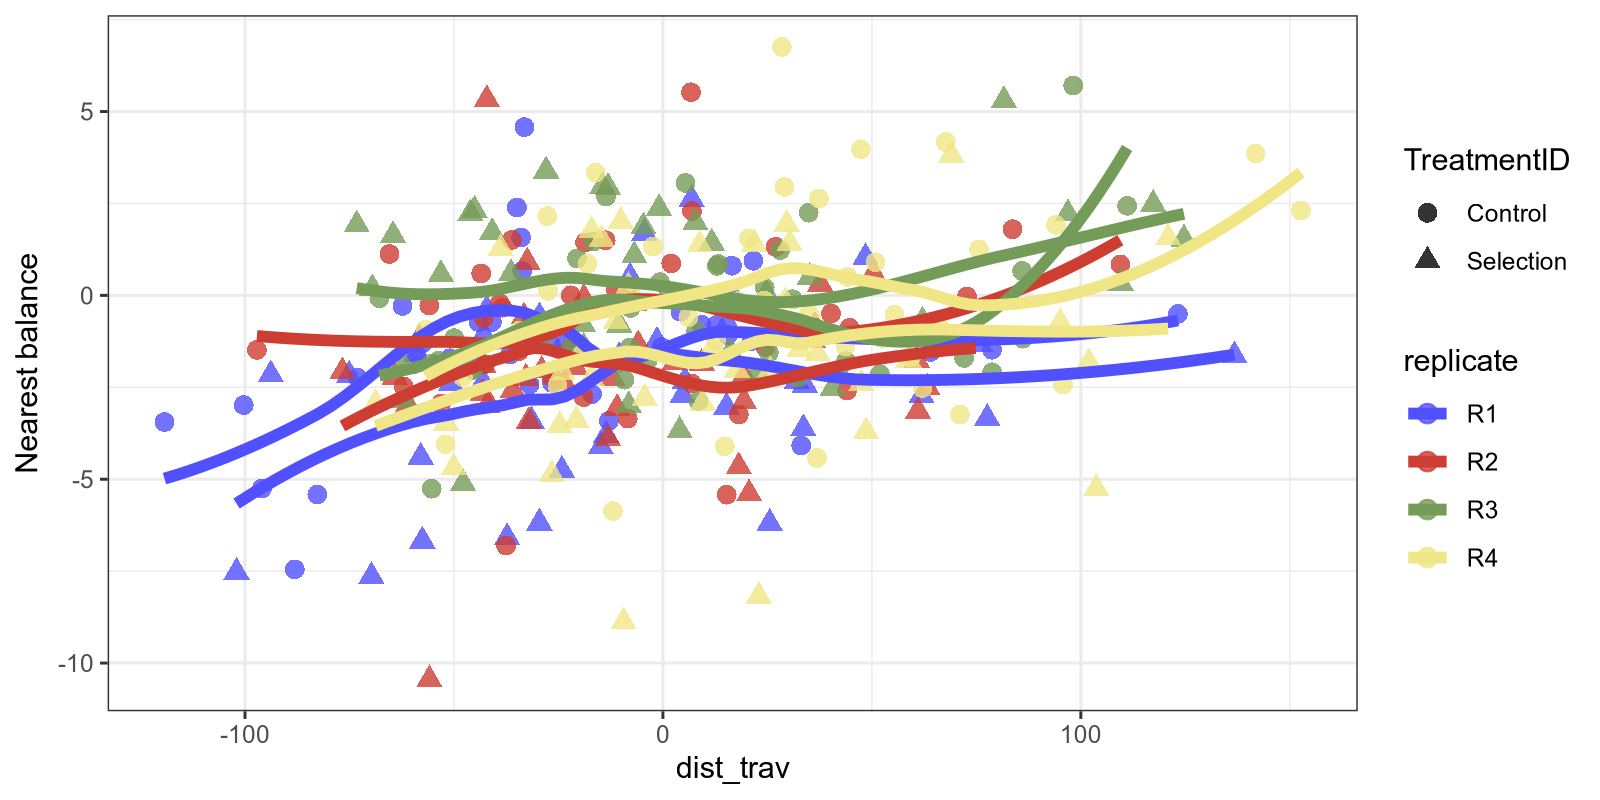

In [249]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = replicate, shape = TreatmentID)) +
	geom_point(alpha=0.8, size=3) +
	#geom_smooth(method = "lm", se = FALSE, size=2) +
	geom_smooth(method = "loess", se = FALSE, size=2) +	
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()	

`geom_smooth()` using formula = 'y ~ x'


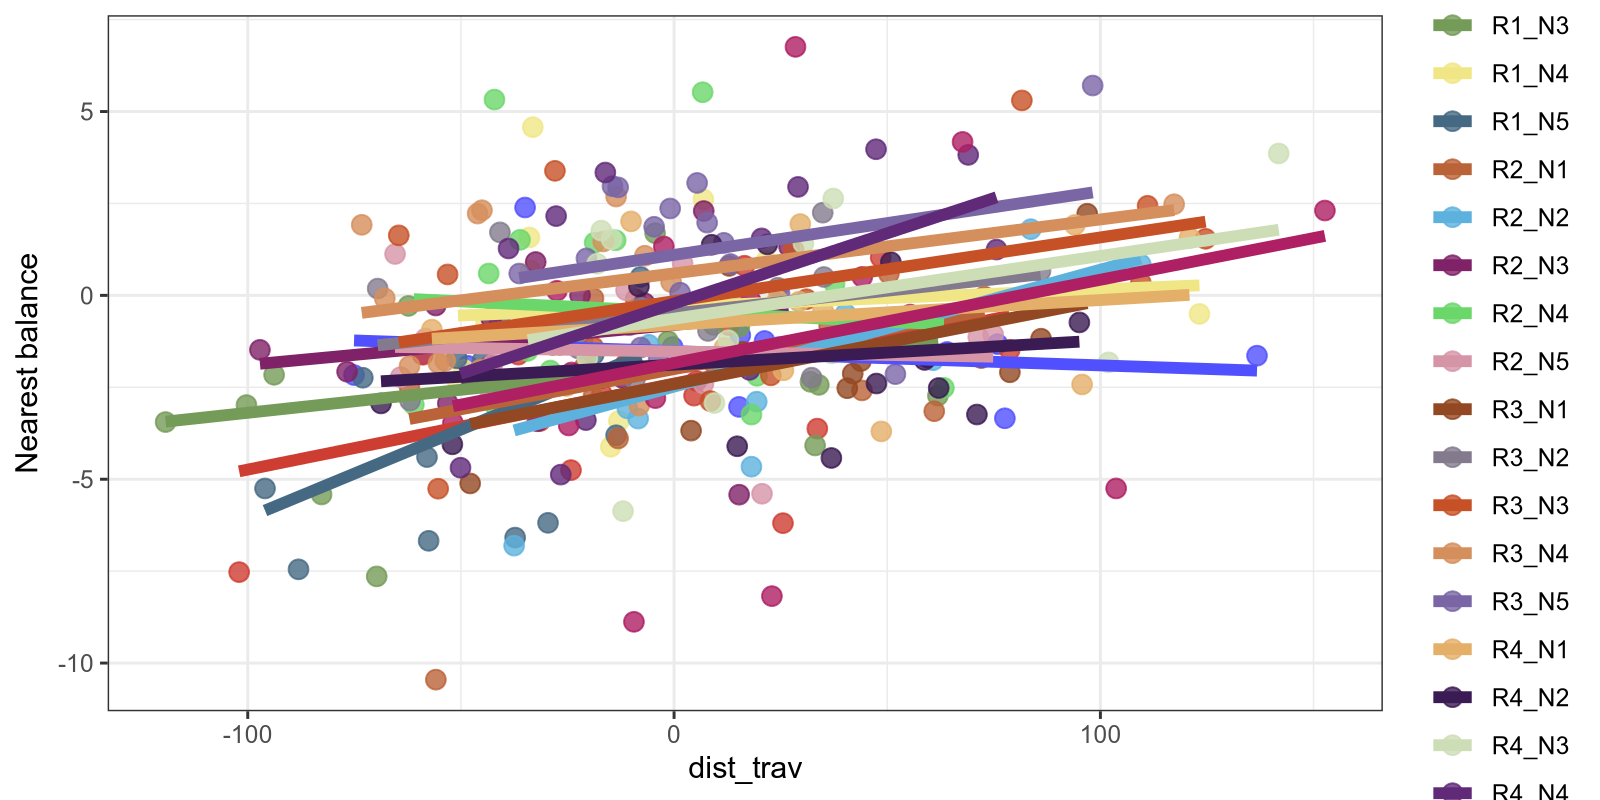

In [250]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = Batch)) +
	geom_point(alpha=0.8, size=3) +
	geom_smooth(method = "lm", se = FALSE, size=2) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()	

`geom_smooth()` using formula = 'y ~ x'


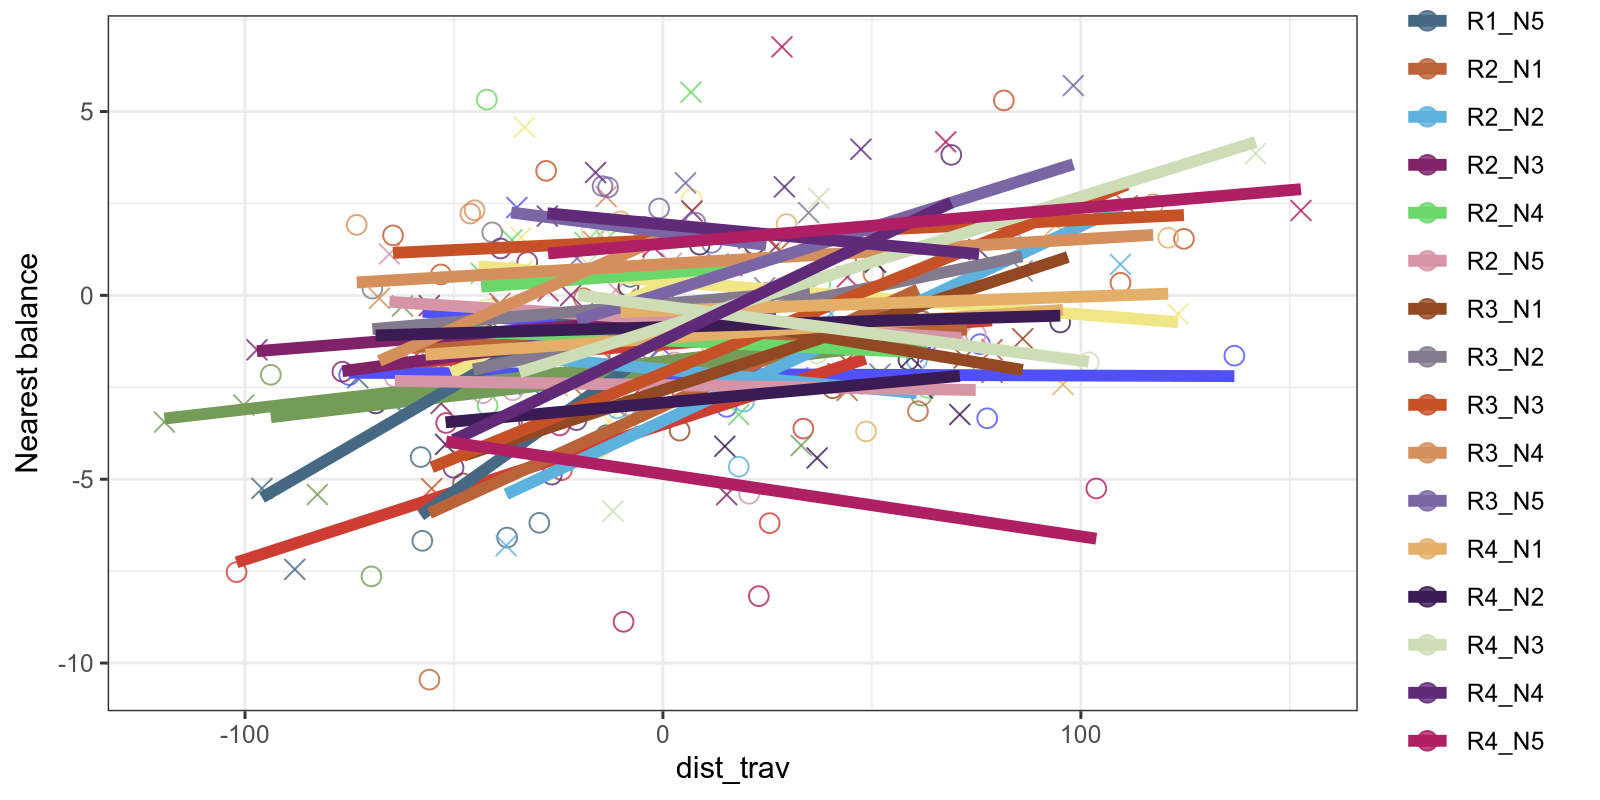

In [251]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, color = Batch, shape = TreatmentID)) +
	geom_point(alpha=0.8, size=3) +
	geom_smooth(method = "lm", se = FALSE, size=2) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv() +	
	# set shapes for TreatmentID
	scale_shape_manual(values = c(4, 1))

`geom_smooth()` using formula = 'y ~ x'


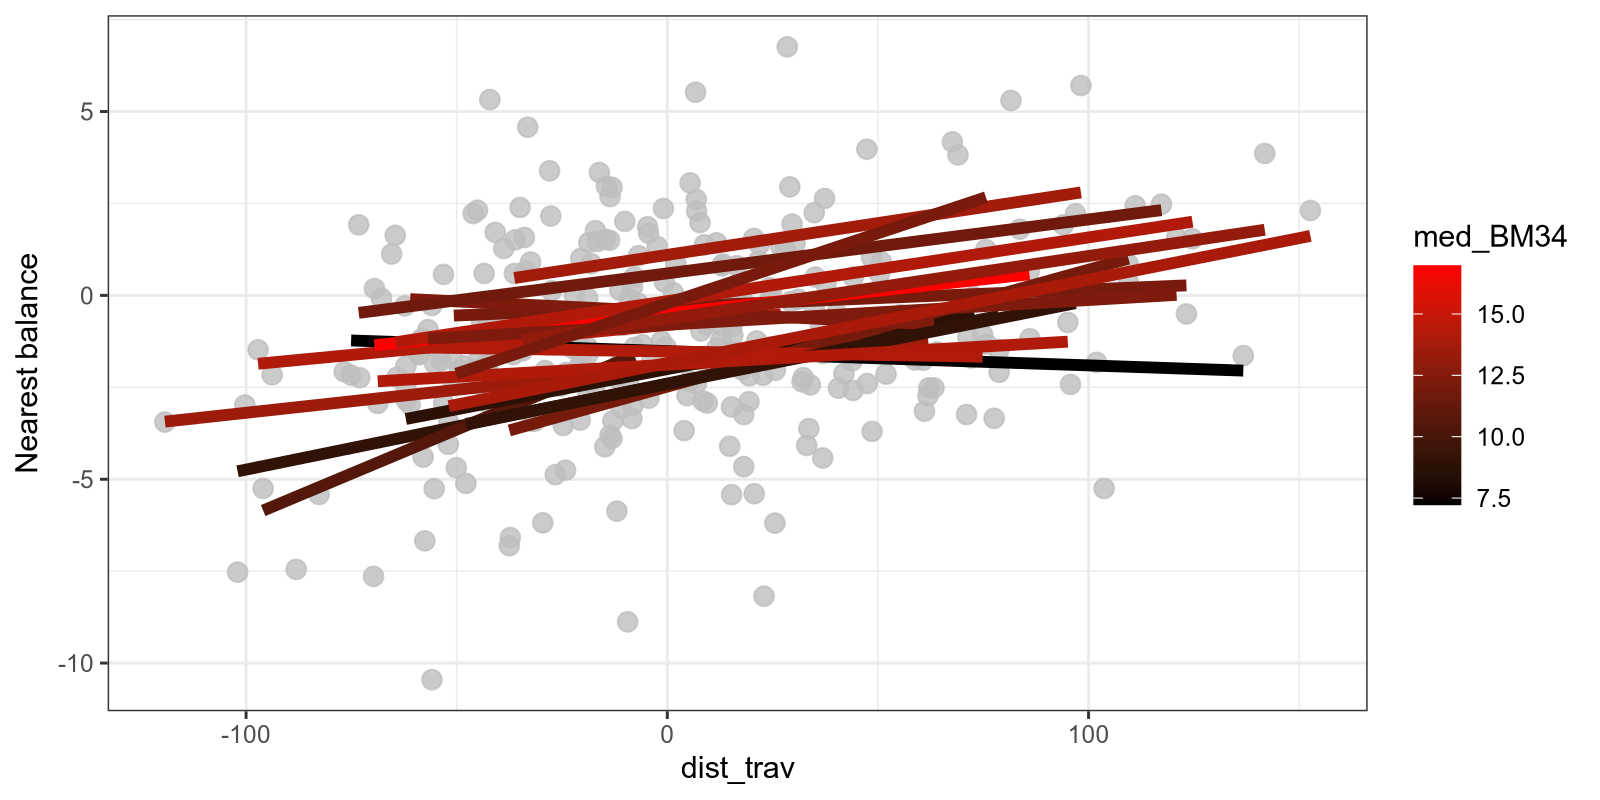

In [252]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, group = Batch)) +
	geom_point(color = "grey", alpha=0.8, size=3) +
	geom_smooth(aes(color = med_BM34), method = "lm", se = FALSE, size=2) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	# set rainbow palette cropped from yellow to red	
	scale_color_gradientn(colors = c("black", "red"))	

`geom_smooth()` using formula = 'y ~ x'


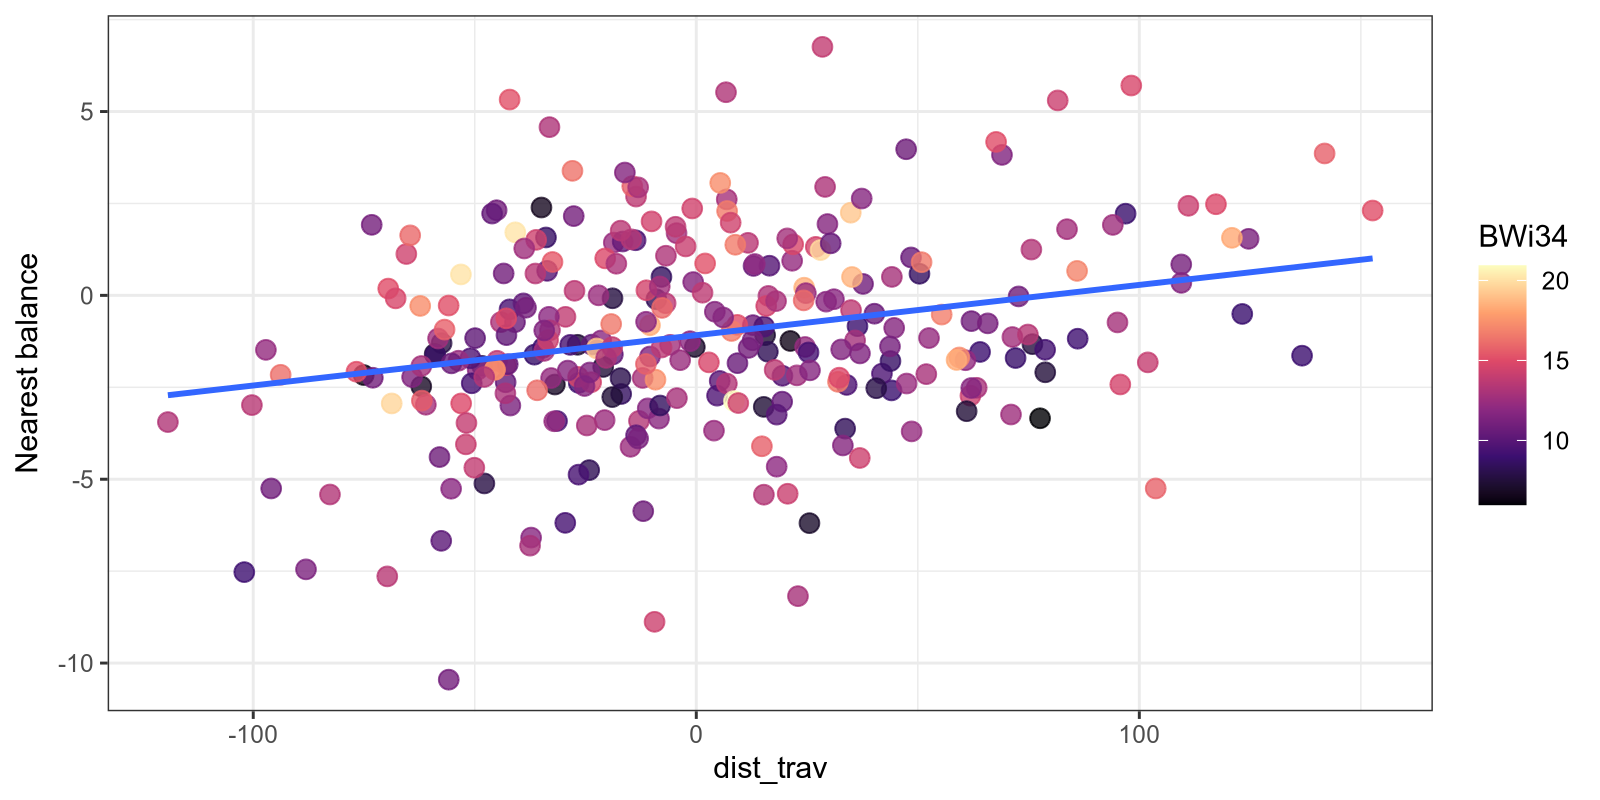

In [253]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value)) +
	geom_point(aes(color = BWi34), alpha=0.8, size=3) +
	geom_smooth(method = "lm", se = FALSE) +
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_viridis_c(option = "magma")

In [254]:
# same plot colored into interesting factors
if("tPCo1" %in% colnames(nb_vals_meta)) {
	p.dims(8,4)
	ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value)) +
		geom_point(aes(color = tPCo1), alpha=0.8, size=3) +
		geom_smooth(method = "lm", se = FALSE) +
		labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
		theme_bw() +
		scale_color_viridis_c(option = "magma")
}

In [255]:
# same plot colored into interesting factors
if("Cluster" %in% colnames(nb_vals_meta)) {
	p.dims(8,4)
	ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, group = Cluster)) +
		geom_point(aes(color = Cluster), alpha=0.8, size=3) +
		geom_smooth(aes(color = Cluster), method = "lm", se = FALSE, size=2) +	
		labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
		theme_bw() +
		scale_color_igv()
}

`geom_smooth()` using formula = 'y ~ x'


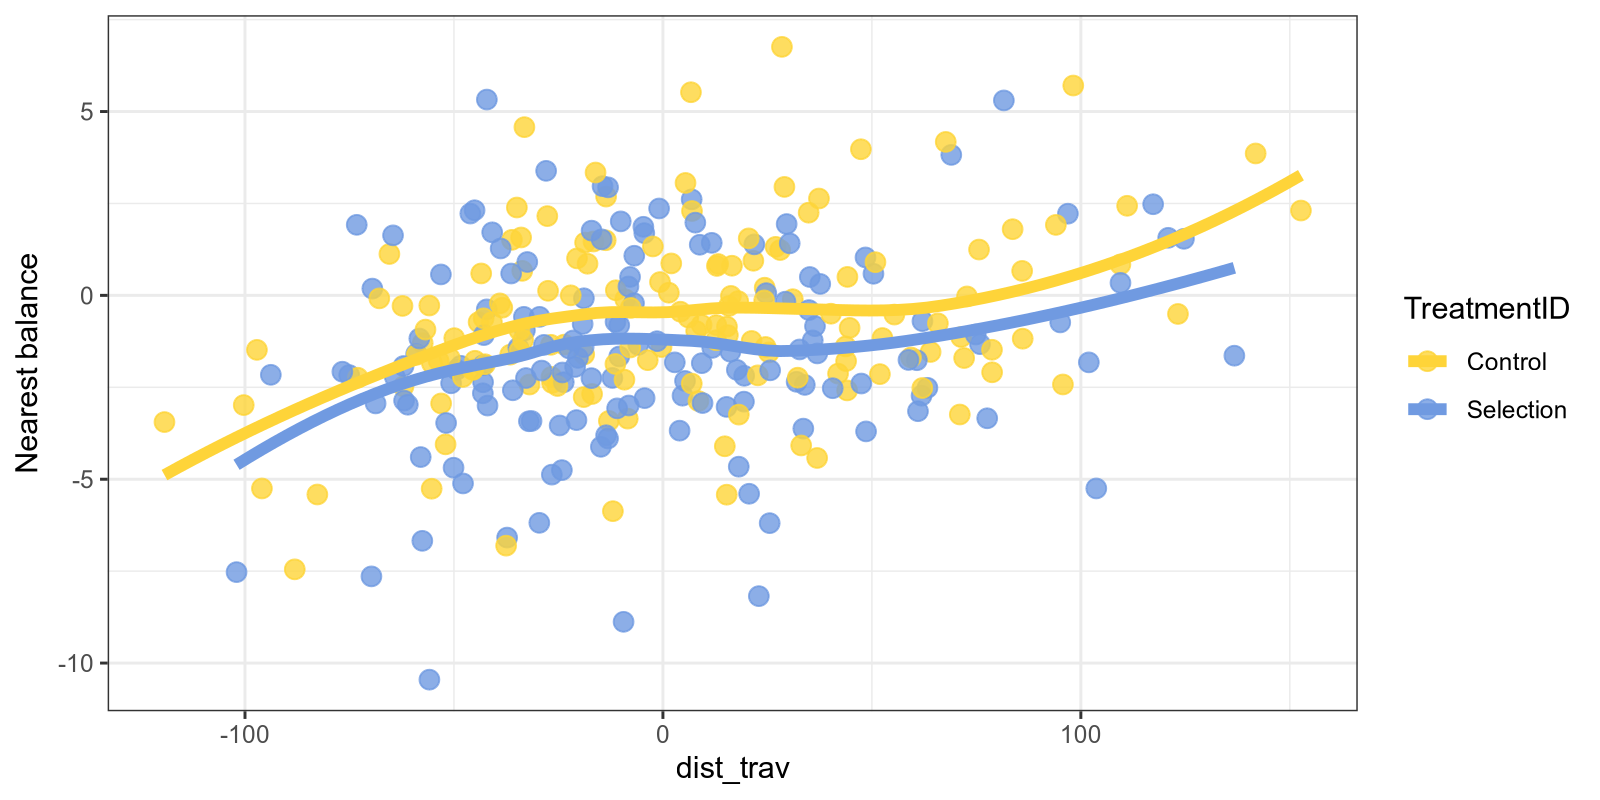

In [256]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta, aes(x = !!sym(sel_factor), y = NB_Value, group = TreatmentID)) +
	geom_point(aes(color = TreatmentID), alpha=0.8, size=3) +
	geom_smooth(aes(color = TreatmentID), method = "loess", se = FALSE, size=2) +	
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_simpsons()
	

In [257]:
if(sel_factor == "Generation_num_TreatmentID") {    
    p.dims(4.5, 3)
    ggplot(nb_vals_meta, aes(x = Generation_num, y = NB_Value, group = TreatmentID)) +
	geom_point(aes(color = TreatmentID), alpha=0.8, size=1) +	
	geom_smooth(aes(color = TreatmentID), method = "loess", se = FALSE, size=1) +	
	labs(x = sel_factor_coef, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_simpsons()	
}

In [258]:
nb_dist_cors = nb_vals_meta %>% group_by(TreatmentID) %>% summarise(	rho = round(cor.test(dist_trav, NB_Value, method = "spearman")$estimate, 2),
													p = round(cor.test(dist_trav, NB_Value, method = "spearman")$p.value, 3)) %>% 
					
			        mutate(dclabel = paste0("rho = ", rho, "\np = ", p)) %>%         
       			select(TreatmentID, dclabel) %>% 
				column_to_rownames("TreatmentID") 
nb_dist_cors

nb_dist_cor_all = nb_vals_meta %>% summarise(	rho = round(cor.test(dist_trav, NB_Value, method = "spearman")$estimate, 2),
													p = round(cor.test(dist_trav, NB_Value, method = "spearman")$p.value, 5)) %>% 
					
			        mutate(dclabel = paste0("rho = ", rho, "\np = ", p)) %>%         
       			select(dclabel)
nb_dist_cor_all

dclabel              
Control   rho = 0.27\np = 0.001
Selection rho = 0.18\np = 0.031

dclabel                
1 rho = 0.23\np = 0.00008

`geom_smooth()` using formula = 'y ~ x'


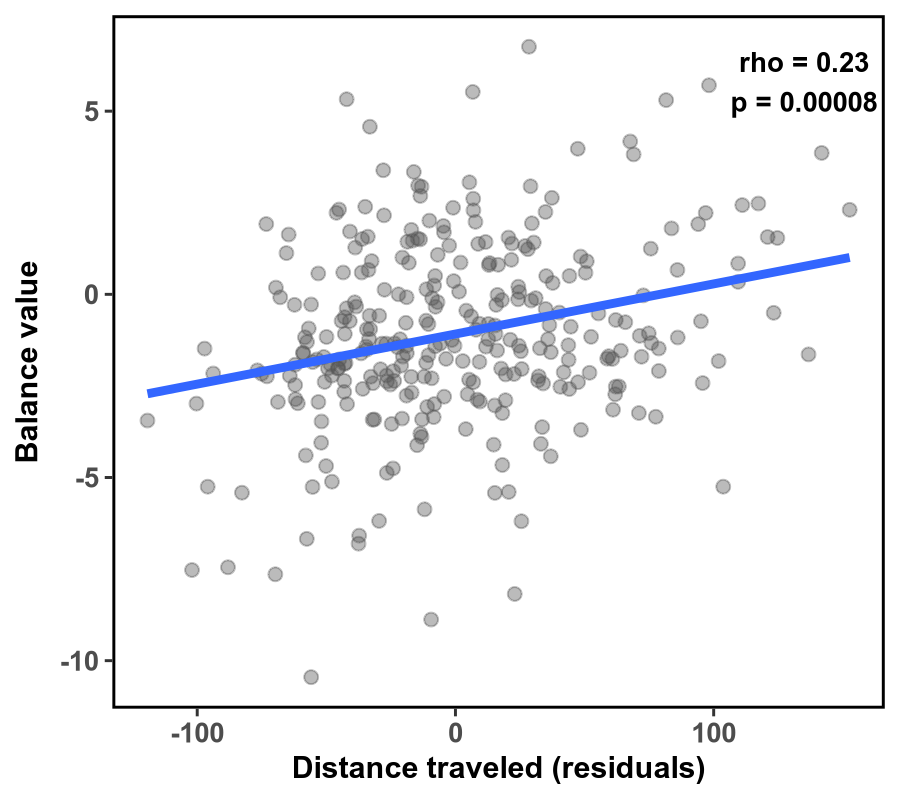

In [259]:
# Figure SX_NB_Distance - A
if(sel_factor == "dist_trav") {
	p.dims(4.5,4)
	ggplot(nb_vals_meta, aes(x = dist_trav, y = NB_Value)) +		
		geom_point(color="#555555", size = 2, alpha = 0.4) +        	
		geom_smooth(method = "lm", se = FALSE, size=1.5) +			
		theme_bw() +		
		labs(x = "Distance traveled (residuals)", y = "Balance value") + 			
		theme(		
			panel.grid.major = element_blank(),
			panel.grid.minor = element_blank(),		
			
			strip.background = element_blank(),
			strip.text.x = element_blank(),
			panel.border = element_rect(colour = "black", linewidth = 1),

			axis.text.x = element_text(size = 10, face = "bold"),
			axis.text.y = element_text(size = 10, face = "bold"),
			axis.title.x = element_text(size = 11, face = "bold"),
			axis.title.y = element_text(size = 11, face = "bold"),
			legend.position = "none"
		) +				
		annotate("text", x = 135, y = 5.8, label = nb_dist_cor_all[, "dclabel"], size = 3.5, color = "#000000", fontface = "bold")
}

`geom_smooth()` using formula = 'y ~ x'


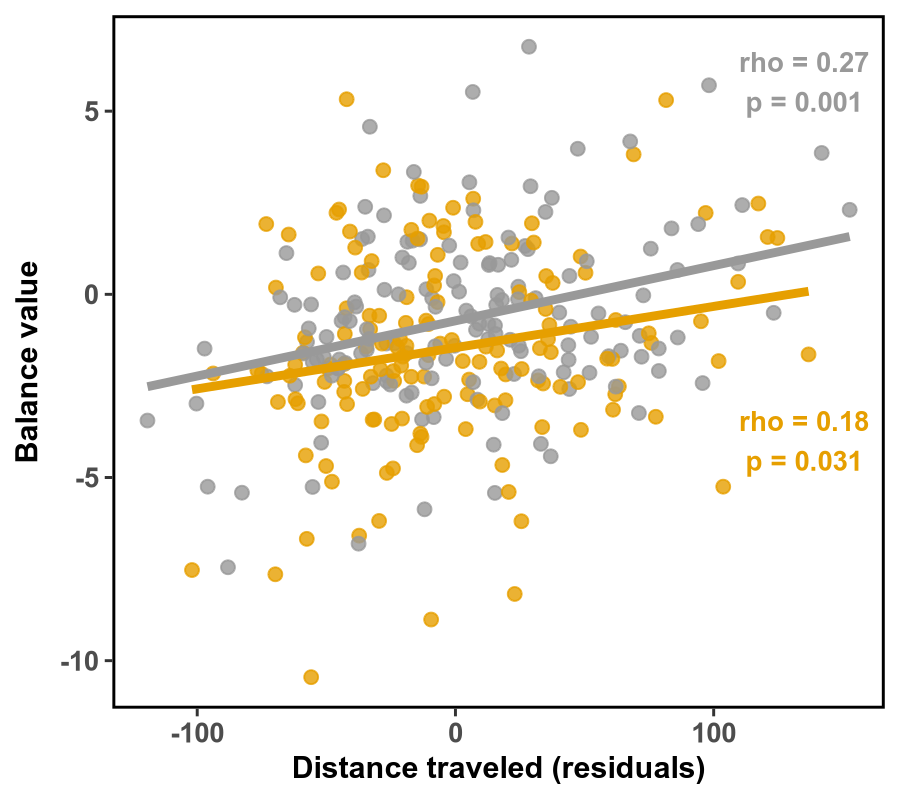

In [260]:
# Figure SX_NB_Distance
if(sel_factor == "dist_trav") {
	p.dims(4.5,4)
	ggplot(nb_vals_meta, aes(x = dist_trav, y = NB_Value, group = TreatmentID)) +
		geom_point(aes(color = TreatmentID), alpha=0.8, size=2) +
		geom_smooth(aes(color = TreatmentID), method = "lm", se = FALSE, size=1.5) +			
		theme_bw() +
		#labs(x = "Distance traveled", y = "Balance value") + 	
		labs(x = "Distance traveled (residuals)", y = "Balance value") + 	
		scale_color_manual(values = c("Control" = "#999999", "Selection" = "#E69F00")) +
		theme(		
			panel.grid.major = element_blank(),
			panel.grid.minor = element_blank(),
			strip.background = element_blank(),
			strip.text.x = element_blank(),
			panel.border = element_rect(colour = "black", linewidth = 1),
			axis.text.x = element_text(size = 10, face = "bold"),
			axis.text.y = element_text(size = 10, face = "bold"),
			axis.title.x = element_text(size = 11, face = "bold"),
			axis.title.y = element_text(size = 11, face = "bold"),
			legend.position = "none"
		) +				
		annotate("text", x = 135, y = 5.8, label = nb_dist_cors["Control", "dclabel"], size = 3.5, color = "#999999", fontface = "bold") +		
		annotate("text", x = 135, y = -4, label = nb_dist_cors["Selection", "dclabel"], size = 3.5, color = "#E69F00", fontface = "bold") 
}

In [261]:
# Fig. SX_NB_rounds_n_sel - C
#if(sel_factor == "TreatmentID") {
if(sel_factor == "Generation_num_TreatmentID") {
	#p.dims(8,3.5)
	p.dims(6.5, 3.5)

	bbb = nb_vals_meta %>% mutate(TreatmentID = factor(TreatmentID),
		generation = factor(generation)) %>% 
		select(Sample, NB_Value, generation, TreatmentID, BWi34, dist_trav) %>% 
		rename(Treatments = TreatmentID)
	bbb

	bbb %>% 
		ggplot(aes(x = generation, y = NB_Value, color = Treatments)) +	
		geom_boxplot(lwd=0.8) +
		facet_grid(. ~ Treatments) +
		theme_bw() +
		labs(x = "Rounds of transfer", y = "Value of the Treatment balance") + 	
		scale_color_manual(values = c("Control" = "#999999", "Selection" = "#E69F00")) +

		theme(
			# legend OFF
			legend.position = "none",
			panel.grid.major = element_blank(),
			panel.grid.minor = element_blank(),
			strip.background = element_blank(),
			strip.text.x = element_blank(),
			panel.border = element_rect(colour = "black", linewidth = 1),
			axis.text.x = element_text(size = 10, face = "bold", color = "black"),
			axis.text.y = element_text(size = 10, face = "bold", color = "black"),
			axis.title.x = element_text(size = 11, face = "bold", color = "black"),
			axis.title.y = element_text(size = 11, face = "bold", color = "black"),
		)
}

`geom_smooth()` using formula = 'y ~ x'


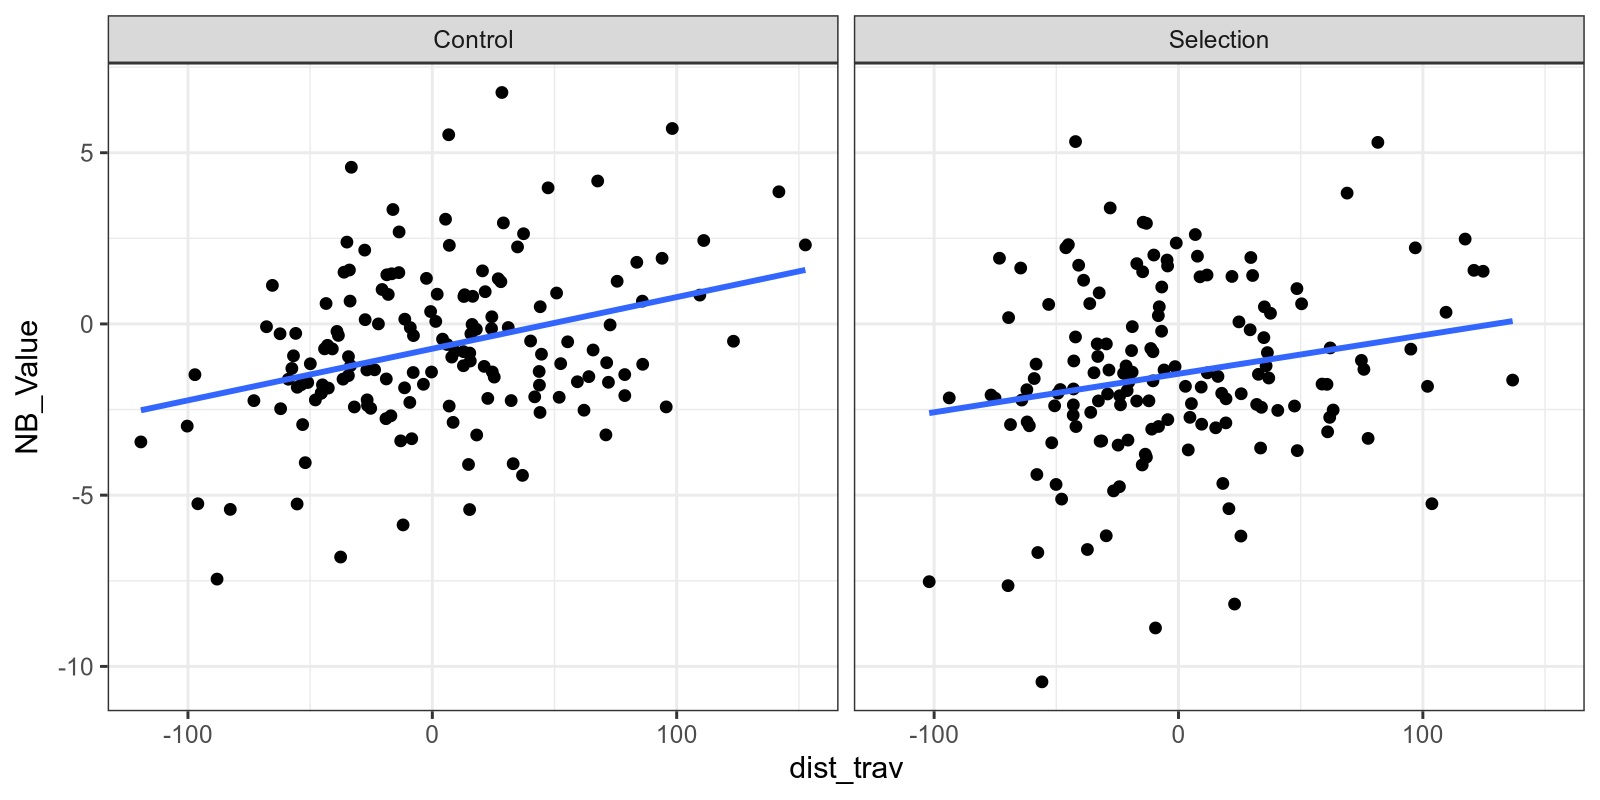

In [262]:
p.dims(8,4)
nb_vals_meta %>% ggplot(aes(x = dist_trav, y = NB_Value)) +
	geom_point() +
	geom_smooth(method = "lm", se = FALSE) +
	facet_grid(. ~ TreatmentID) +
	theme_bw() +
	scale_color_simpsons()

`geom_smooth()` using formula = 'y ~ x'


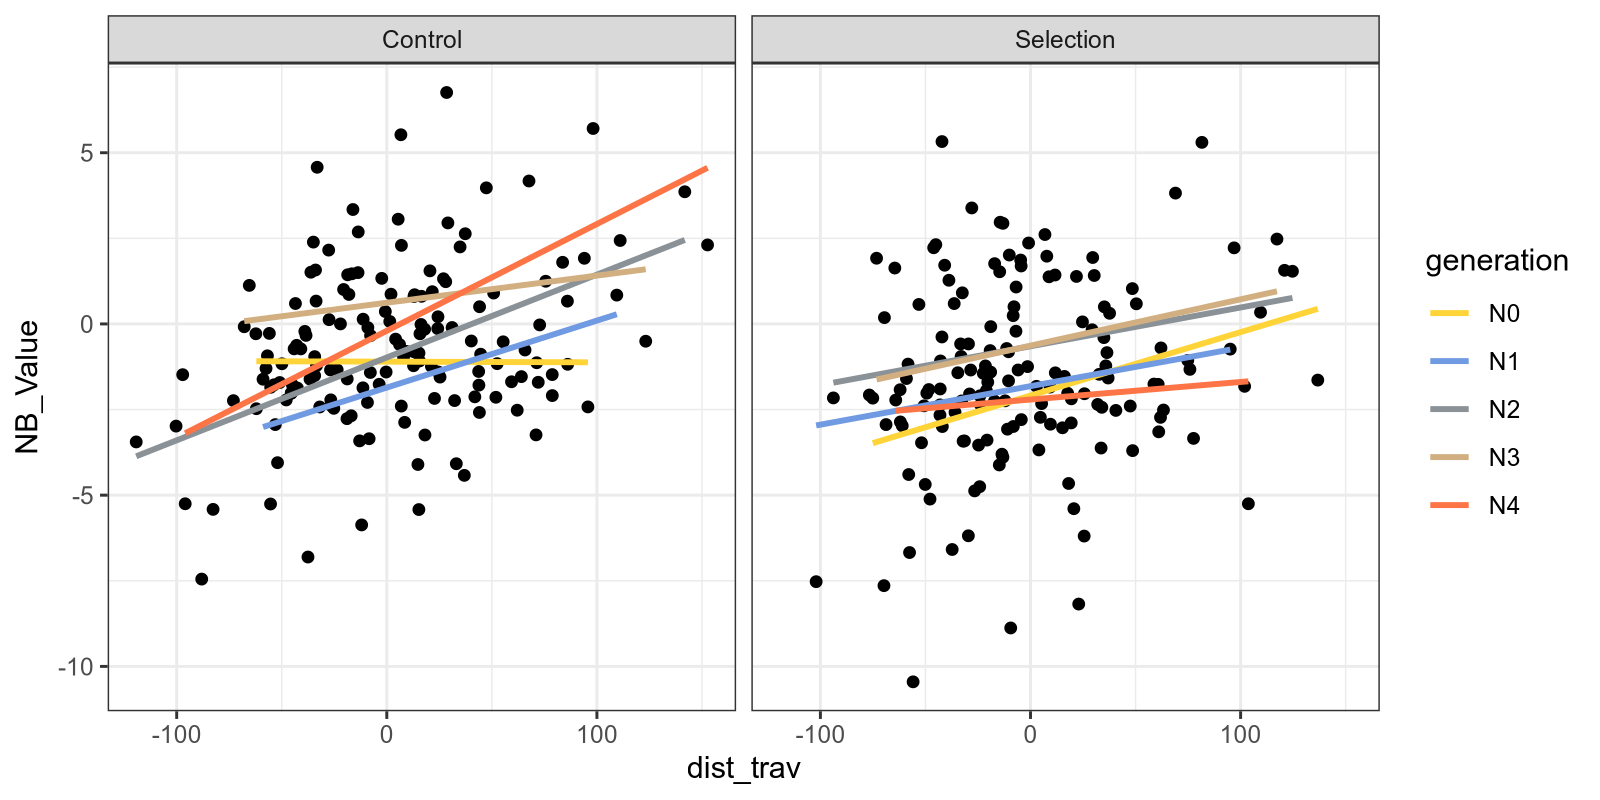

In [263]:
p.dims(8,4)
nb_vals_meta %>% ggplot(aes(x = dist_trav, y = NB_Value, group = generation)) +  	
	geom_point() +
	geom_smooth(aes(color = generation), method = "lm", se = FALSE) +	
	facet_grid(. ~ TreatmentID) +
	theme_bw() +	
	scale_color_simpsons()


### check correlation of NB with BWi34

`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  nb_vals_meta$BWi34 and nb_vals_meta$NB_Value
t = 3.9051, df = 301, p-value = 0.0001163
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1096279 0.3242484
sample estimates:
      cor 
0.2195934 


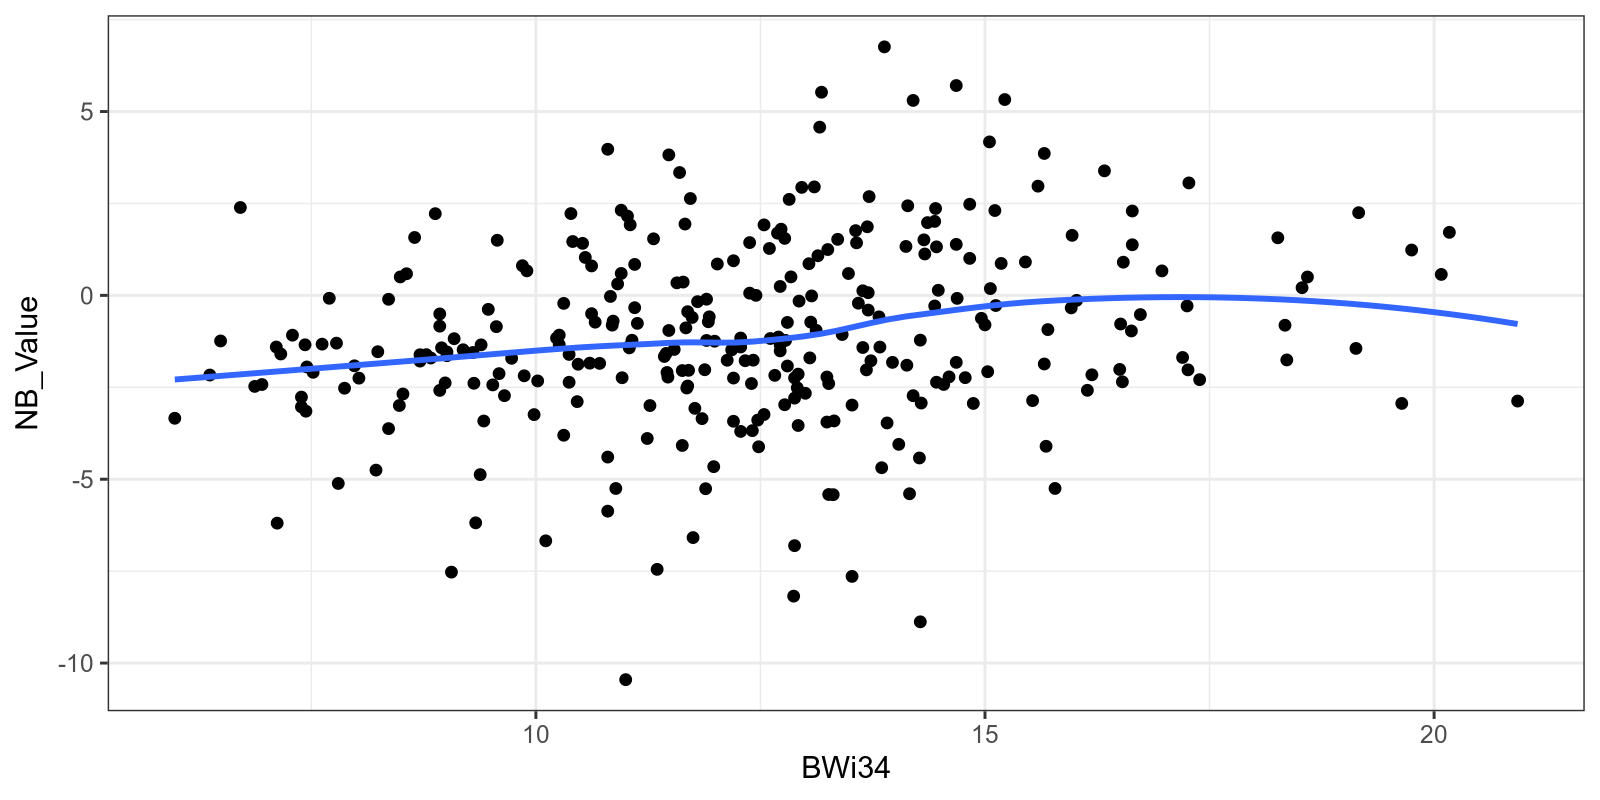

In [264]:
p.dims(8,4)
nb_vals_meta %>% ggplot(aes(x = BWi34, y = NB_Value)) +  	
	geom_point() +
	geom_smooth(method = "loess", se = FALSE) +	
	theme_bw() +
	scale_color_simpsons()

# correlation between BWi34 and NB
cor.test(nb_vals_meta$BWi34, nb_vals_meta$NB_Value)

In [265]:
nb_vals_meta

Sample   NB_Value  TreatmentID replicate generation AnimalID_of_donor
1   R1N1C001  2.389733 Control     R1        N0         TSU201           
2   R1N1C003 -1.082313 Control     R1        N0         TSU201           
3   R1N1C005 -2.424407 Control     R1        N0         TSU201           
⋮   ⋮        ⋮         ⋮           ⋮         ⋮          ⋮                
302 R4N5T318 -5.250647 Selection   R4        N4         R4N4T272         
303 R4N5T320 -8.179657 Selection   R4        N4         R4N4T272         
    Date_inoculated Date_dissected BWi34
1   2020_09_15      2020_09_30     6.71 
2   2020_09_15      2020_09_30     7.29 
3   2020_09_15      2020_09_30     6.95 
⋮   ⋮               ⋮              ⋮    
302 2020_12_02      2020_12_18     15.78
303 2020_12_02      2020_12_18     12.87
    Body_weight_at_dissection_g_5_6_weeks_old_ ⋯ Indole_3_propionic_acid
1   16.31                                      ⋯ -1.065484              
2   17.85                                      ⋯ -0.729802              
3   18.53                                      ⋯  2.147966              
⋮   ⋮                                          ⋱ ⋮                      
302 20.73                                      ⋯ -0.9059691             
303 20.21                                      ⋯ -0.9135559             
    Cortisol   Tryptophan  Thyroxine_T4 Kynurenine  Serotonin  Corticosterone
1   0.2453456   1.73311156  0.02519366  -0.6668299   1.1885306 0.06882749    
2   0.8881352   0.77461032  0.19119146   1.6994129  -0.2474590 1.88683479    
3   0.8299338  -0.01378314 -0.73320341   0.3964652  -0.4875808 1.17861436    
⋮   ⋮          ⋮           ⋮            ⋮           ⋮          ⋮             
302 -0.1356461 -2.257129    0.5523505   -0.85886716 -1.0394325 -0.7469192    
303 -0.4382994 -1.405704   -0.2939660    0.04035511  0.2217766  0.5301893    
    Glutamic_acid Kynurenic_acid y_Aminobutyric_acid_GABA
1   -1.8769956     0.16616567     0.14916154             
2    1.9199923     0.11988900    -0.51031296             
3    0.2230279    -0.02527093     0.07396041             
⋮   ⋮             ⋮              ⋮                       
302 -0.6388798    -0.187062347   -0.1882914              
303 -0.7601085    -0.009911653   -0.1106562

`geom_smooth()` using formula = 'y ~ x'


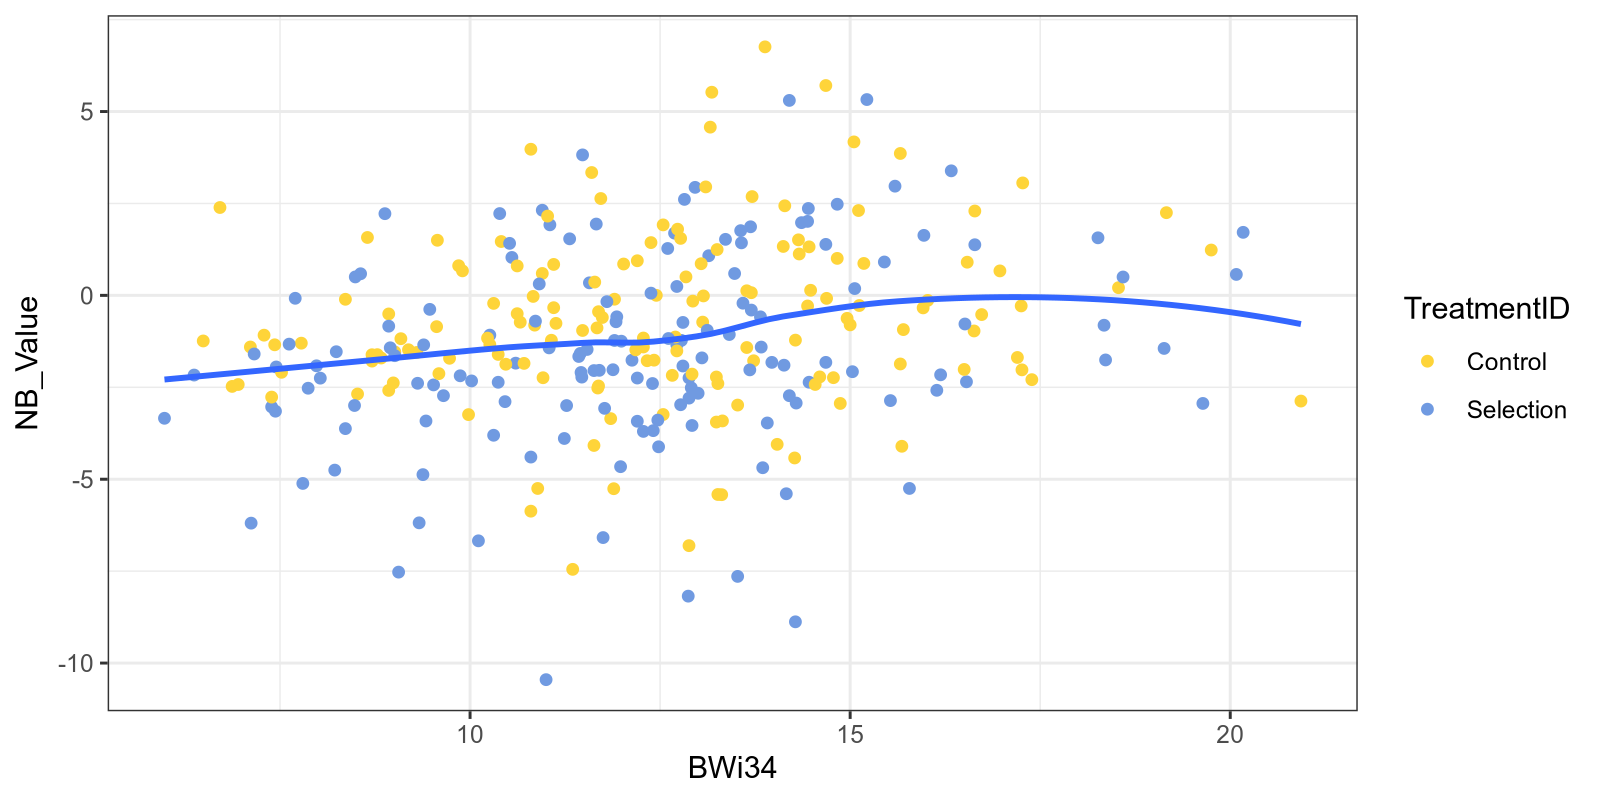

In [266]:
p.dims(8,4)
nb_vals_meta %>% ggplot(aes(x = BWi34, y = NB_Value)) +  	
	geom_point(aes(color = TreatmentID)) +
	geom_smooth(method = "loess", se = FALSE) +	
	theme_bw() +
	scale_color_simpsons()


### go on preparing the balance

In [267]:
# join sbp_consensus_reprod with coef_oa_bacs
nb_reprod_coef = join_coefs_and_sbp_reprod(get_sbp_consensus_with_reprod(sbp_iters), coef_oa_bacs)

df.dims(10)
nb_reprod_coef %>% arrange(desc(reprod))
df.dims(5)

taxName                 b1 reprod lm_coef     
1 Mobilitalea              1 1.00    0.005008395
2 Oliverpabstia            1 1.00    0.005286302
3 Lactobacillus           -1 0.99   -0.004616050
4 QWKK01                  -1 0.99   -0.005443910
5 Mediterraneibacter       1 0.96    0.003655914
6 Limosilactobacillus     -1 0.95   -0.004965133
7 UMGS1071                 1 0.95    0.003661661
8 Phascolarctobacterium_A -1 0.84   -0.003323409
9 Intestinimonas           1 0.83    0.003270199

#### add Species info

In [268]:
if(TAXONOMIC_PROFILING == "bracken") {
	nb_reprod_coef = nb_reprod_coef %>% inner_join(bracken %>% 
		select(name, Family) %>% distinct, by = c("taxName" = "name")) %>%
		mutate(taxName_ext = taxName)
	nb_reprod_coef
}

taxName                 b1 reprod lm_coef      Family            
1 Phascolarctobacterium_A -1 0.84   -0.003323409 Acidaminococcaceae
2 Mediterraneibacter       1 0.96    0.003655914 Lachnospiraceae   
3 Mobilitalea              1 1.00    0.005008395 Lachnospiraceae   
⋮ ⋮                       ⋮  ⋮      ⋮            ⋮                 
8 Lactobacillus           -1 0.99   -0.00461605  Lactobacillaceae  
9 QWKK01                  -1 0.99   -0.00544391  Eggerthellaceae   
  taxName_ext            
1 Phascolarctobacterium_A
2 Mediterraneibacter     
3 Mobilitalea            
⋮ ⋮                      
8 Lactobacillus          
9 QWKK01

In [269]:
if(TAXONOMIC_PROFILING == "krakenuniq") {
	if(TAXONOMIC_LEVEL == "Species") {
		nb_reprod_coef = nb_reprod_coef %>% inner_join(SRG_meta %>% 
			select(Name, Family, Species) %>% distinct, by = c("taxName" = "Name")) %>%	
			mutate(taxName_ext = paste(taxName, Species, sep = "; ")) %>%
			select(-c(Species))
	} else {
		if(TAXONOMIC_LEVEL == "Genus") {
			nb_reprod_coef = nb_reprod_coef %>% inner_join(SRG_meta %>% 			
				select(Genus, Family) %>% distinct, by = c("taxName" = "Genus")) %>%			
				mutate(taxName_ext = taxName)
		}
	}	
	nb_reprod_coef
}

In [270]:
df.dims(10)
nb_reprod_coef
df.dims(5)

taxName                 b1 reprod lm_coef      Family            
1 Phascolarctobacterium_A -1 0.84   -0.003323409 Acidaminococcaceae
2 Mediterraneibacter       1 0.96    0.003655914 Lachnospiraceae   
3 Mobilitalea              1 1.00    0.005008395 Lachnospiraceae   
4 Oliverpabstia            1 1.00    0.005286302 Lachnospiraceae   
5 Limosilactobacillus     -1 0.95   -0.004965133 Lactobacillaceae  
6 UMGS1071                 1 0.95    0.003661661 Acutalibacteraceae
7 Intestinimonas           1 0.83    0.003270199 Oscillospiraceae  
8 Lactobacillus           -1 0.99   -0.004616050 Lactobacillaceae  
9 QWKK01                  -1 0.99   -0.005443910 Eggerthellaceae   
  taxName_ext            
1 Phascolarctobacterium_A
2 Mediterraneibacter     
3 Mobilitalea            
4 Oliverpabstia          
5 Limosilactobacillus    
6 UMGS1071               
7 Intestinimonas         
8 Lactobacillus          
9 QWKK01

### Coefficients for each taxon in NB: plot

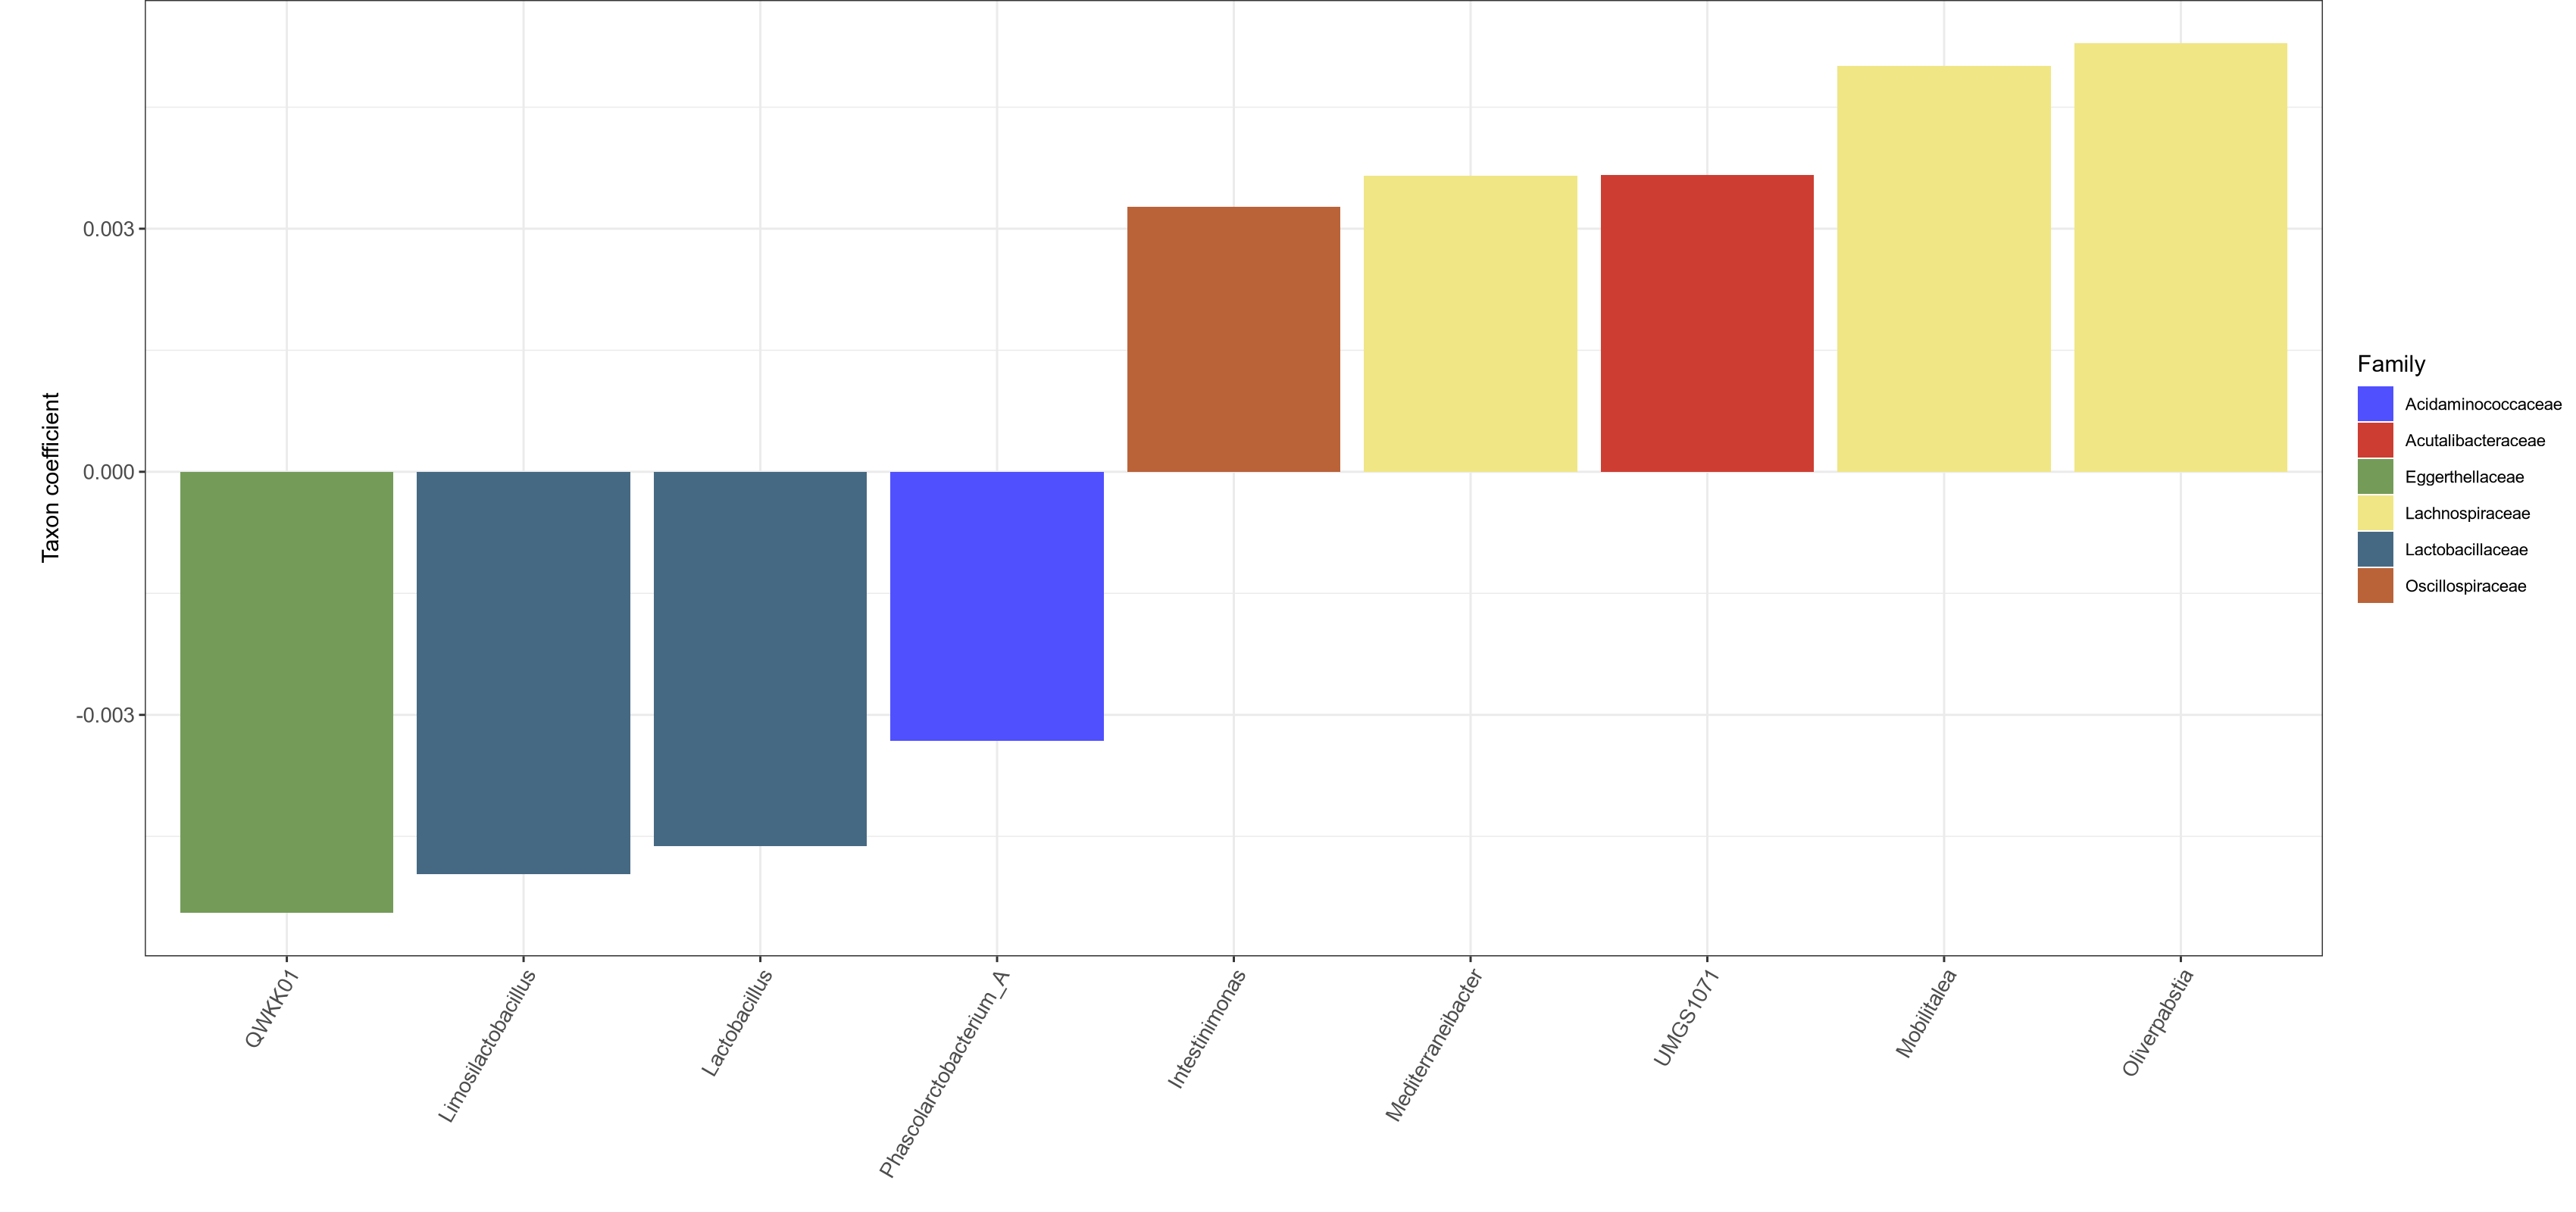

In [271]:
p.dims(17,8)
pic = ggplot(nb_reprod_coef, aes(x = lm_coef, y = reorder(taxName_ext, lm_coef), fill = Family)) +
	geom_bar(stat = "identity", linewidth = 0.2) +
	theme_bw() +
	scale_alpha_continuous(range = c(0.1, 1)) +	
	theme(axis.text = element_text(size = 10)) +	
	labs(x = "Taxon coefficient", y = "") + 	
	# rotate labels
	theme(axis.text.x = element_text(angle = 60, hjust = 1), 
		plot.margin = margin(l = 20)) +
	# rotate the plot 90 degrees
	coord_flip() + 
	# set a palette for the fill
	scale_fill_manual(values = all_fams_pal) +
	# legend text 10 
	theme(legend.text = element_text(size = 8))
pic


In [272]:
# save the whole balance (for external computation)
if(SELECT_GENERATION_NUM == "all") {
    if (!dir.exists(file.path(work_dir, "out/NB"))) {
        dir.create(file.path(work_dir, "out/NB"), recursive = TRUE)
    }
    if(SELECT_TREATMENT == "both") {
        saveRDS(nb, file.path(work_dir, "out/NB", paste0("NB_Exp_2_", sel_factor, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".rds")))
    } else {
        saveRDS(nb, file.path(work_dir, "out/NB", paste0("NB_Exp_2_", sel_factor, "_", SELECT_TREATMENT, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".rds")))
    }
}

In [273]:
# save the coefficients (for Figures)
if(SELECT_GENERATION_NUM == "all") {
    if(SELECT_TREATMENT == "both") {
        saveRDS(nb_reprod_coef, file.path(work_dir, "out/NB", paste0("NB_Exp_2_coef_", sel_factor, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".rds")))
    } else {
        saveRDS(nb_reprod_coef, file.path(work_dir, "out/NB", paste0("NB_Exp_2_coef_", sel_factor, "_", SELECT_TREATMENT, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".rds")))
    }
}

In [274]:
# for preparing a global color pallete for families: collect all output the list of families in this NB to a file
if(SELECT_GENERATION_NUM == "all") {
	if(SELECT_TREATMENT == "both") {
		write_delim(nb_reprod_coef %>% select(Family) %>% distinct(),
			file = file.path(work_dir, "out/NB", paste0("NB_Exp_2_families_set_", sel_factor, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".tsv")),
			col_names = FALSE)
	} else {
		write_delim(nb_reprod_coef %>% select(Family) %>% distinct(),
			file = file.path(work_dir, "out/NB", paste0("NB_Exp_2_families_set_", sel_factor, "_", SELECT_TREATMENT, "_", TAXONOMIC_LEVEL, "_", TAXONOMIC_PROFILING, ".tsv")),
			col_names = FALSE)
	}
}

### For distance traveled: various plots

`geom_smooth()` using formula = 'y ~ x'


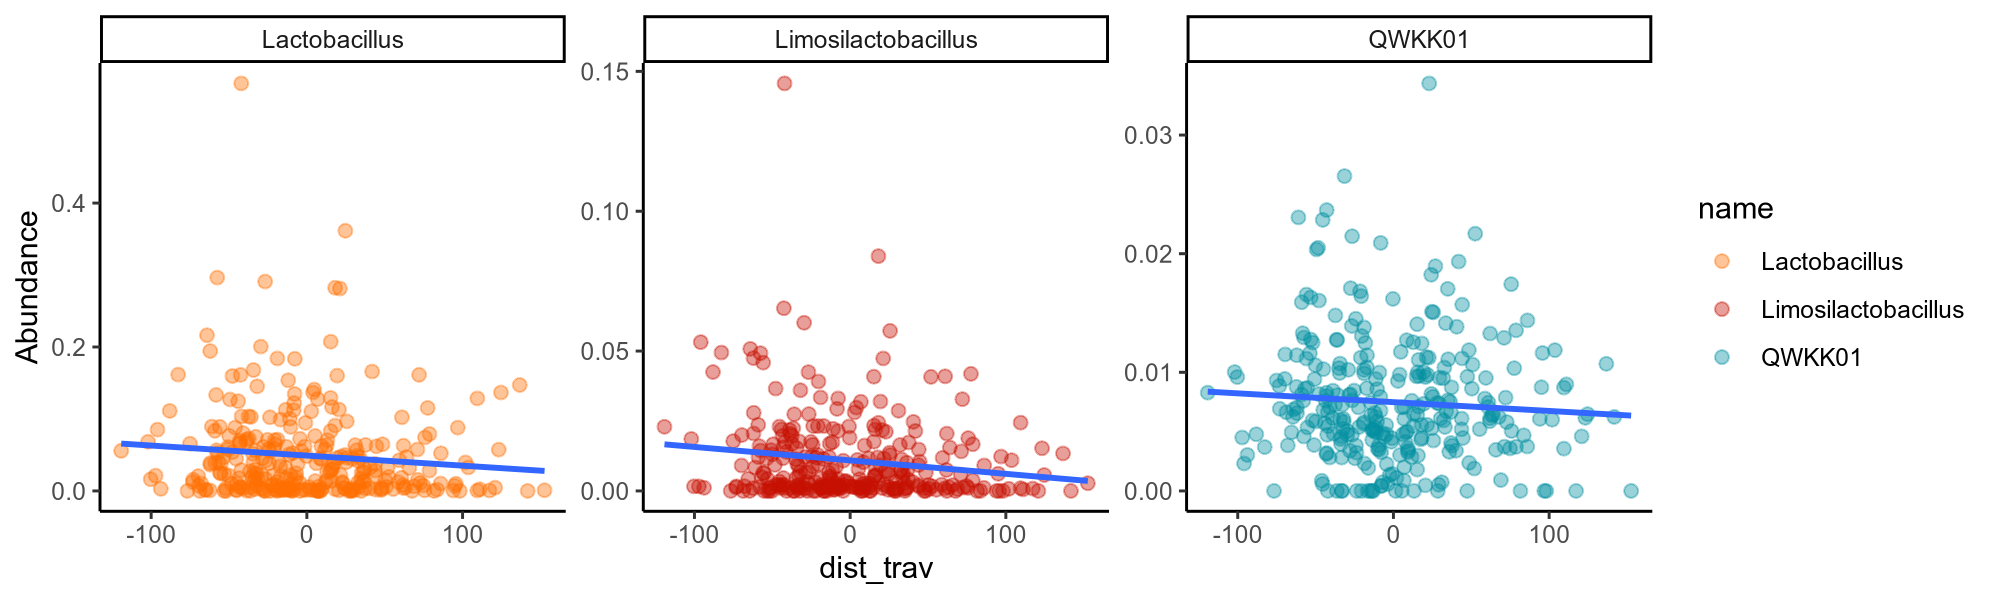

In [275]:
if(sel_factor == "dist_trav") {
    tops = nb_reprod_coef %>% arrange(lm_coef) %>% head(3) %>% select(taxName)
    tops
    to_plot = 
        # Common rel. abundances:    
        br_perc[[TAXONOMIC_LEVEL]] %>% inner_join(tops, by = c("name" = "taxName")) %>% select(Sample, name, Abundance, Family) %>% 

        ## or CLR:
        #clr_my[,tops %>% pull()] %>% 
        #    rownames_to_column("Sample") %>%
        #    pivot_longer(-Sample, names_to = "name", values_to = "Abundance") %>%     

        inner_join(nb_vals_meta %>% select(Sample, dist_trav, TreatmentID, Generation_num), by = "Sample")
    
    p.dims(10,3)
    to_plot %>% ggplot(aes(x = dist_trav, y = Abundance)) +    
        # fancy points
        geom_point(aes(color = name), size = 2, alpha = 0.4) +

        # facet each with own scale
        facet_wrap(~name, scales = "free") +
        geom_smooth(method = "lm", se = FALSE) +
        theme_classic() +
        scale_color_futurama()
}


Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”
Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”
Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”


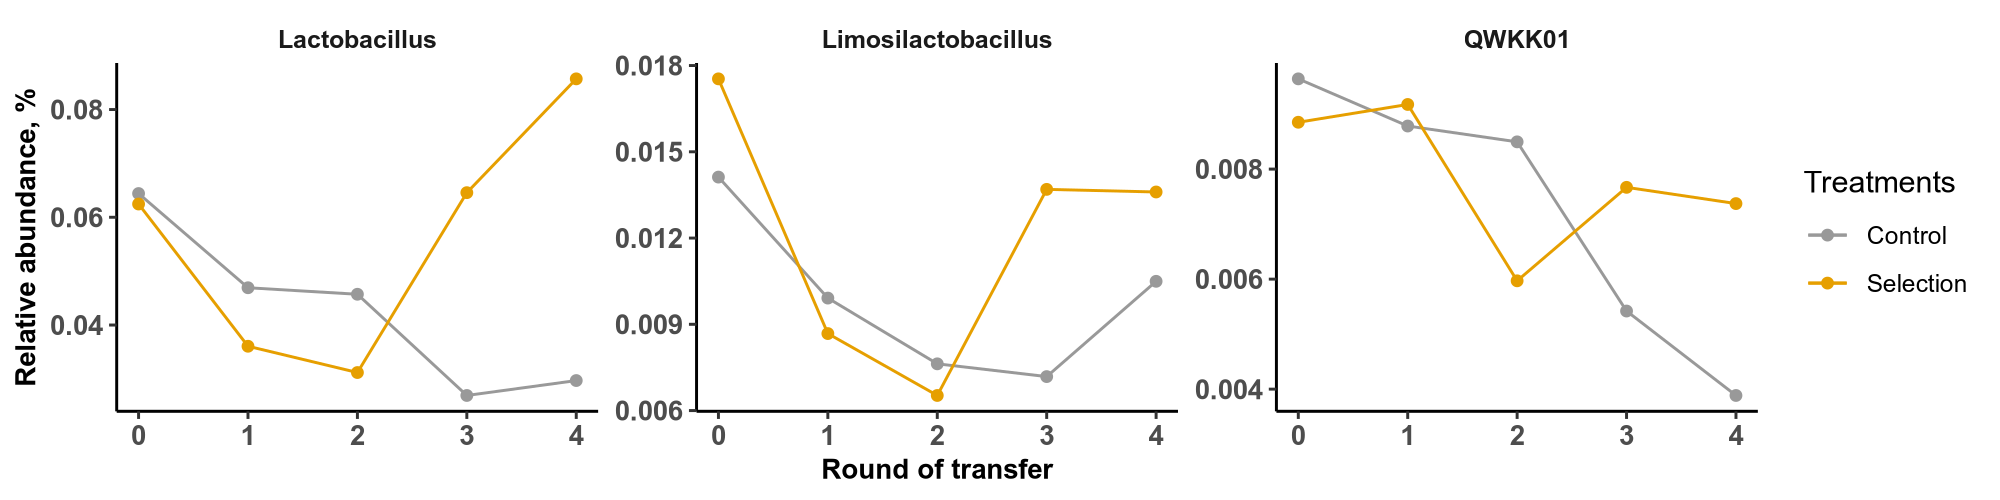

In [276]:
# Suppl. Fig. SX_dist_top_3
if(sel_factor == "dist_trav") {
    # to_plot: for each name, plot its abundance against Generation_num
    p.dims(10, 2.5)
    to_plot %>% ggplot(aes(x = Generation_num, y = Abundance, group = TreatmentID)) +

        stat_summary(aes(color = TreatmentID), fun.data = "mean_cl_boot", geom = "errorbar", width = 0.2) +
        # connect the medians
        stat_summary(aes(color = TreatmentID), fun = mean, geom = "line", size = 0.5) +
        # make points at medians
        stat_summary(aes(color = TreatmentID), fun = mean, geom = "point", size = 1.5) +
        scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +
        # facet each with own scale
        facet_wrap(~name, scales = "free") +
        theme_classic() +
        # axis labels
        labs(x = "Round of transfer", y = "Relative abundance, %") +        
        theme(
            strip.background = element_blank(),
            strip.text.x = element_text(size = 9, face = "bold"),
			axis.text.x = element_text(size = 10, face = "bold"),
			axis.text.y = element_text(size = 10, face = "bold"),
			axis.title.x = element_text(size = 10, face = "bold"),
			axis.title.y = element_text(size = 10, face = "bold")
        )
}

In [277]:
if(sel_factor == "dist_trav") {    
    lacto_genus_rounds =         
        br_perc$Genus %>% filter(Genus == "Lactobacillus") %>% 
        select(Sample, name, Abundance, Family) %>%        
        inner_join(nb_vals_meta %>% select(Sample, dist_trav, TreatmentID, Generation_num), by = "Sample")    
}

Warning message in cor.test.default(lacto_genus_rounds$dist_trav, lacto_genus_rounds$Abundance, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 'y ~ x'


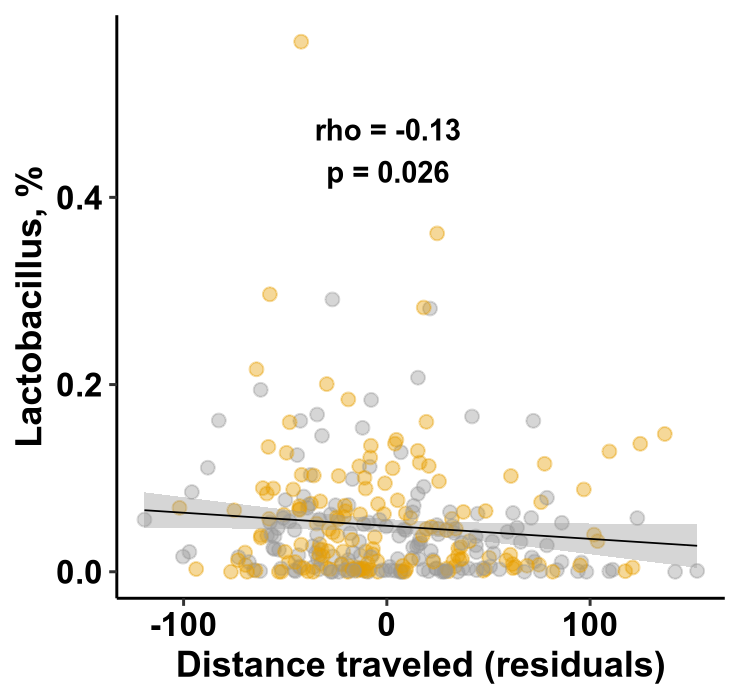

In [278]:
# Fig. 3G
if(sel_factor == "dist_trav") {
    cor_test = cor.test(lacto_genus_rounds$dist_trav, lacto_genus_rounds$Abundance, method = "spearman")
    label_cor = paste0("rho = ", round(cor_test$estimate, 2), "\np = ", round(cor_test$p.value, 3))

    p.dims(3.7, 3.5)
    lacto_genus_rounds %>% ggplot(aes(x = dist_trav, y = Abundance)) +    
        # fancy points
        geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
        geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +
 
        theme_classic() +        
        # axis labels
        labs(x = "Distance traveled (residuals)", y = "Lactobacillus, %") +
        theme(
            strip.background = element_blank(),
            strip.text.x = element_text(size = 9, face = "bold"),
			axis.text.x = element_text(size = 12, face = "bold", color = "black"),
			axis.text.y = element_text(size = 12, face = "bold", color = "black"),
			axis.title.x = element_text(size = 13, face = "bold", color = "black"),
			axis.title.y = element_text(size = 13, face = "bold", color = "black"), 
            legend.position = "none"
        ) +
        scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +
#        annotate("text", x = 420, y = 500, label = labels_noN1$label_all, size = 3, label.size = 0, color = "black", fontface = "bold", hjust = 0) +
        annotate("text", x = 0.5, y = 0.45, label = label_cor, size = 3.7, color = "black", fontface = "bold")
}

Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(dist_trav, Abundance, method = "spearman"):
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula = 

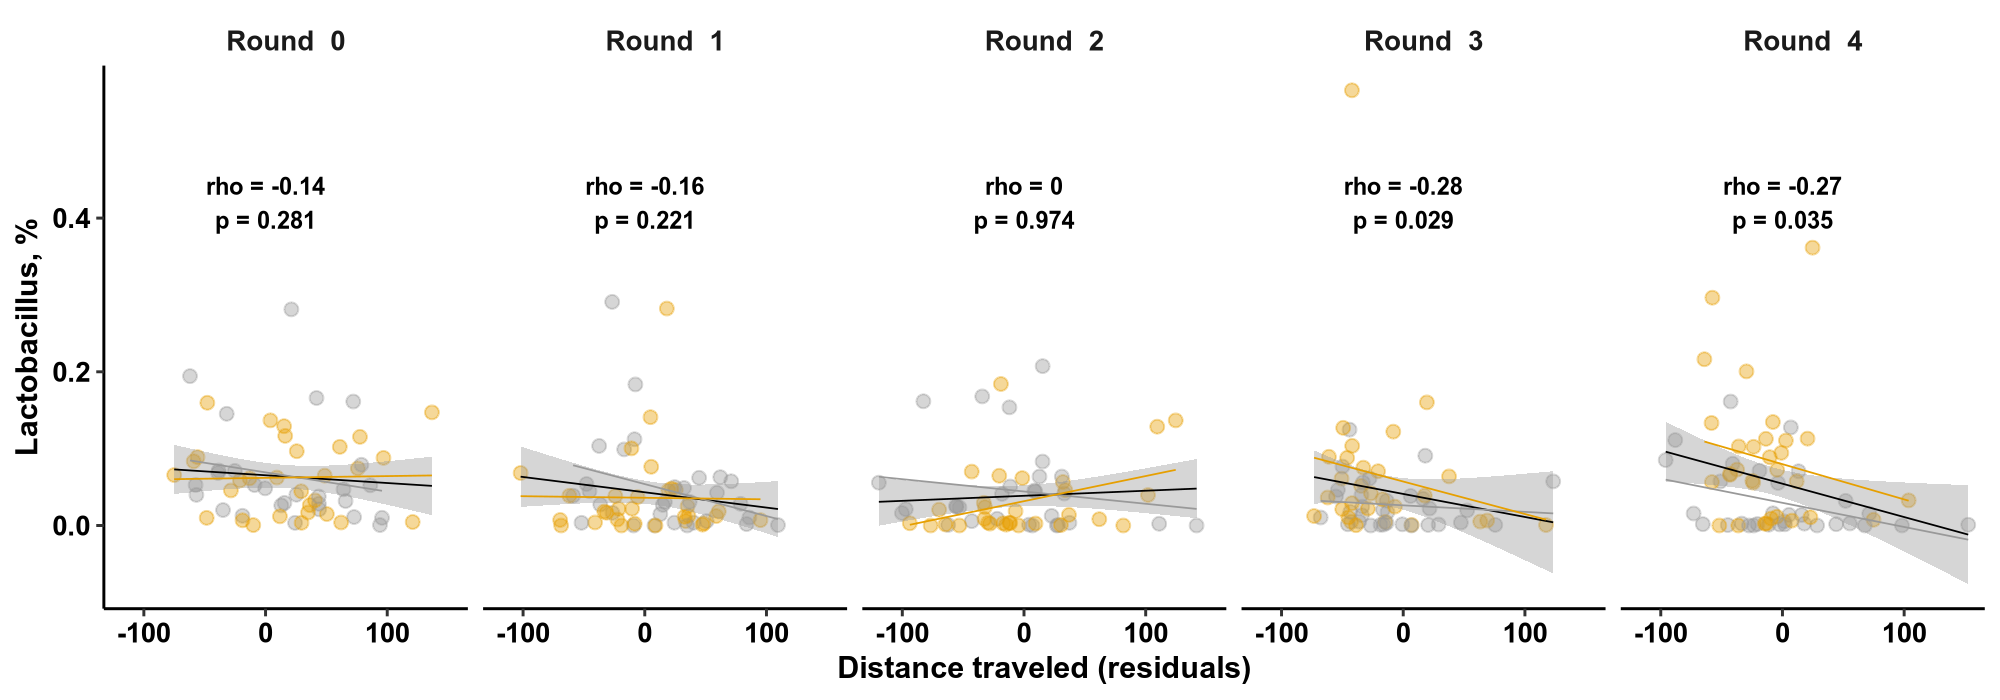

In [279]:
# Fig. SX_Lactobacillus_PedMeters
if(sel_factor == "dist_trav") {

    dist_cors = lacto_genus_rounds %>% group_by(Generation_num) %>% 
            mutate(rho = round(cor.test(dist_trav, Abundance, method = "spearman")$estimate, 2),
                  p = round(cor.test(dist_trav, Abundance, method = "spearman")$p.value, 3)) %>% 
            ungroup() %>%             
            mutate(dclabel = paste0("rho = ", rho, "\np = ", p))            
    dist_cors    

    # Custom labeller function
    round_labeller <- function(value) {
        paste("Round ", value) # Adds "Round" before the factor level
    }

    p.dims(10, 3.5)    
    ggplot(dist_cors, aes(x = dist_trav, y = Abundance)) +    
        # fancy points
        geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
        geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +
        geom_smooth(aes(color = TreatmentID), size = 0.3, method = "lm", se = FALSE) + 
        theme_classic() +                        
        # axis labels
        labs(x = "Distance traveled (residuals)", y = "Lactobacillus, %") +
        theme(
            strip.background = element_blank(),
            strip.text.x = element_text(size = 10, face = "bold"),
			axis.text.x = element_text(size = 10, face = "bold", color = "black"),
			axis.text.y = element_text(size = 10, face = "bold", color = "black"),
			axis.title.x = element_text(size = 11, face = "bold", color = "black"),
			axis.title.y = element_text(size = 11, face = "bold", color = "black"), 
            legend.position = "none"
        ) +
        scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +        

        geom_label(            
            data = dist_cors %>% dplyr::distinct(Generation_num, .keep_all = TRUE),  # Keep only first occurrence per facet_var
            #aes(x = 240, y = 0.42, label = dclabel),
            aes(x = 0, y = 0.42, label = dclabel),
            size = 3,
            alpha = 0,            
            label.size = 0, 
            fontface = "bold"
        ) + 
        facet_wrap(~Generation_num, nrow = 1, labeller = as_labeller(round_labeller))

}

Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = DATA[[1L]], y = DATA[[2L]], ...):
“cannot compute exact p-value with ties”


# A tidytable: 5 × 2
  Generation_num  p_value
           <int>    <dbl>
1              0 0.728   
2              1 0.349   
3              2 0.265   
4              3 0.0410  
5              4 0.000892


Warning message:
“Computation failed in `stat_summary()`.
Caused by error in `fun.data()`:
! The package "Hmisc" is required.”


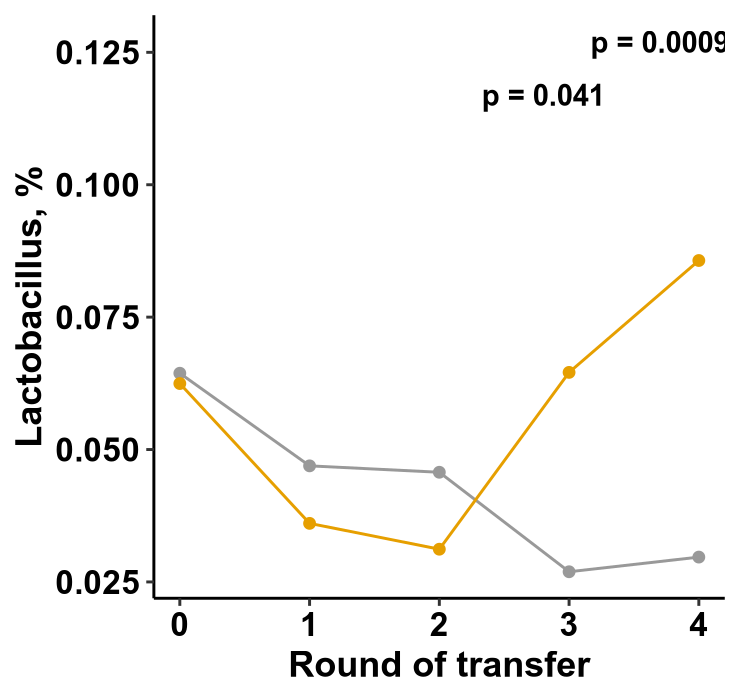

In [280]:
# Fig. 3H
if(sel_factor == "dist_trav") {
    # Perform Wilcoxon test for each round between Selection and Control
    wilcox_results = lacto_genus_rounds %>%
        group_by(Generation_num) %>%
        summarise(p_value = wilcox.test(Abundance ~ TreatmentID)$p.value)        
    print(wilcox_results)
    pws = round(wilcox_results %>% pull(p_value), 4)    
    
    p.dims(3.7, 3.5)
    lacto_genus_rounds %>% ggplot(aes(x = Generation_num, y = Abundance, group = TreatmentID)) +                    

        stat_summary(aes(color = TreatmentID), fun.data = "mean_cl_boot", geom = "errorbar", width = 0.2) +        
        # connect the medians
        stat_summary(aes(color = TreatmentID), fun = mean, geom = "line", size = 0.5) +
        # make points at medians
        stat_summary(aes(color = TreatmentID), fun = mean, geom = "point", size = 1.5) +
        scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +
        
        theme_classic() +        
        # axis labels
        labs(x = "Round of transfer", y = "Lactobacillus, %") +        
        theme(
            strip.background = element_blank(),
            strip.text.x = element_text(size = 9, face = "bold"),
			axis.text.x = element_text(size = 12, face = "bold", color = "black"),
			axis.text.y = element_text(size = 12, face = "bold", color = "black"),
			axis.title.x = element_text(size = 13, face = "bold", color = "black"),
			axis.title.y = element_text(size = 13, face = "bold", color = "black"), 
            legend.position = "none"
        ) +
        # add the p-values of the Wilcoxon test for rounds 3 and 4                
        annotate("text", x = 2.8, y = 0.117, label = paste0("p = ", pws[4]), size = 3.7, fontface = "bold") +		        
        annotate("text", x = 3.7, y = 0.127, label = paste0("p = ", pws[5]), size = 3.7, fontface = "bold") 
}

### Compute the NB for the "full" dataset

In [281]:
# compute the consensus balance values for each sample 
nb_vals_full = compute_balance(abundance_my_full, nb)
dim(nb_vals_full)
nb_vals_meta_full = nb_vals_full %>% inner_join(memeta_2_full, by = c("Sample" = "AnimalID"))
nb_vals_meta_full

[1] 303   2

Sample   NB_Value  TreatmentID replicate generation AnimalID_of_donor
1   R1N1C001  2.389733 Control     R1        N0         TSU201           
2   R1N1C003 -1.082313 Control     R1        N0         TSU201           
3   R1N1C005 -2.424407 Control     R1        N0         TSU201           
⋮   ⋮        ⋮         ⋮           ⋮         ⋮          ⋮                
302 R4N5T318 -5.250647 Selection   R4        N4         R4N4T272         
303 R4N5T320 -8.179657 Selection   R4        N4         R4N4T272         
    Date_inoculated Date_dissected BWi34
1   2020_09_15      2020_09_30     6.71 
2   2020_09_15      2020_09_30     7.29 
3   2020_09_15      2020_09_30     6.95 
⋮   ⋮               ⋮              ⋮    
302 2020_12_02      2020_12_18     15.78
303 2020_12_02      2020_12_18     12.87
    Body_weight_at_dissection_g_5_6_weeks_old_ ⋯ Indole_3_propionic_acid
1   16.31                                      ⋯ -1.065484              
2   17.85                                      ⋯ -0.729802              
3   18.53                                      ⋯  2.147966              
⋮   ⋮                                          ⋱ ⋮                      
302 20.73                                      ⋯ -0.9059691             
303 20.21                                      ⋯ -0.9135559             
    Cortisol   Tryptophan  Thyroxine_T4 Kynurenine  Serotonin  Corticosterone
1   0.2453456   1.73311156  0.02519366  -0.6668299   1.1885306 0.06882749    
2   0.8881352   0.77461032  0.19119146   1.6994129  -0.2474590 1.88683479    
3   0.8299338  -0.01378314 -0.73320341   0.3964652  -0.4875808 1.17861436    
⋮   ⋮          ⋮           ⋮            ⋮           ⋮          ⋮             
302 -0.1356461 -2.257129    0.5523505   -0.85886716 -1.0394325 -0.7469192    
303 -0.4382994 -1.405704   -0.2939660    0.04035511  0.2217766  0.5301893    
    Glutamic_acid Kynurenic_acid y_Aminobutyric_acid_GABA
1   -1.8769956     0.16616567     0.14916154             
2    1.9199923     0.11988900    -0.51031296             
3    0.2230279    -0.02527093     0.07396041             
⋮   ⋮             ⋮              ⋮                       
302 -0.6388798    -0.187062347   -0.1882914              
303 -0.7601085    -0.009911653   -0.1106562

`geom_smooth()` using formula = 'y ~ x'


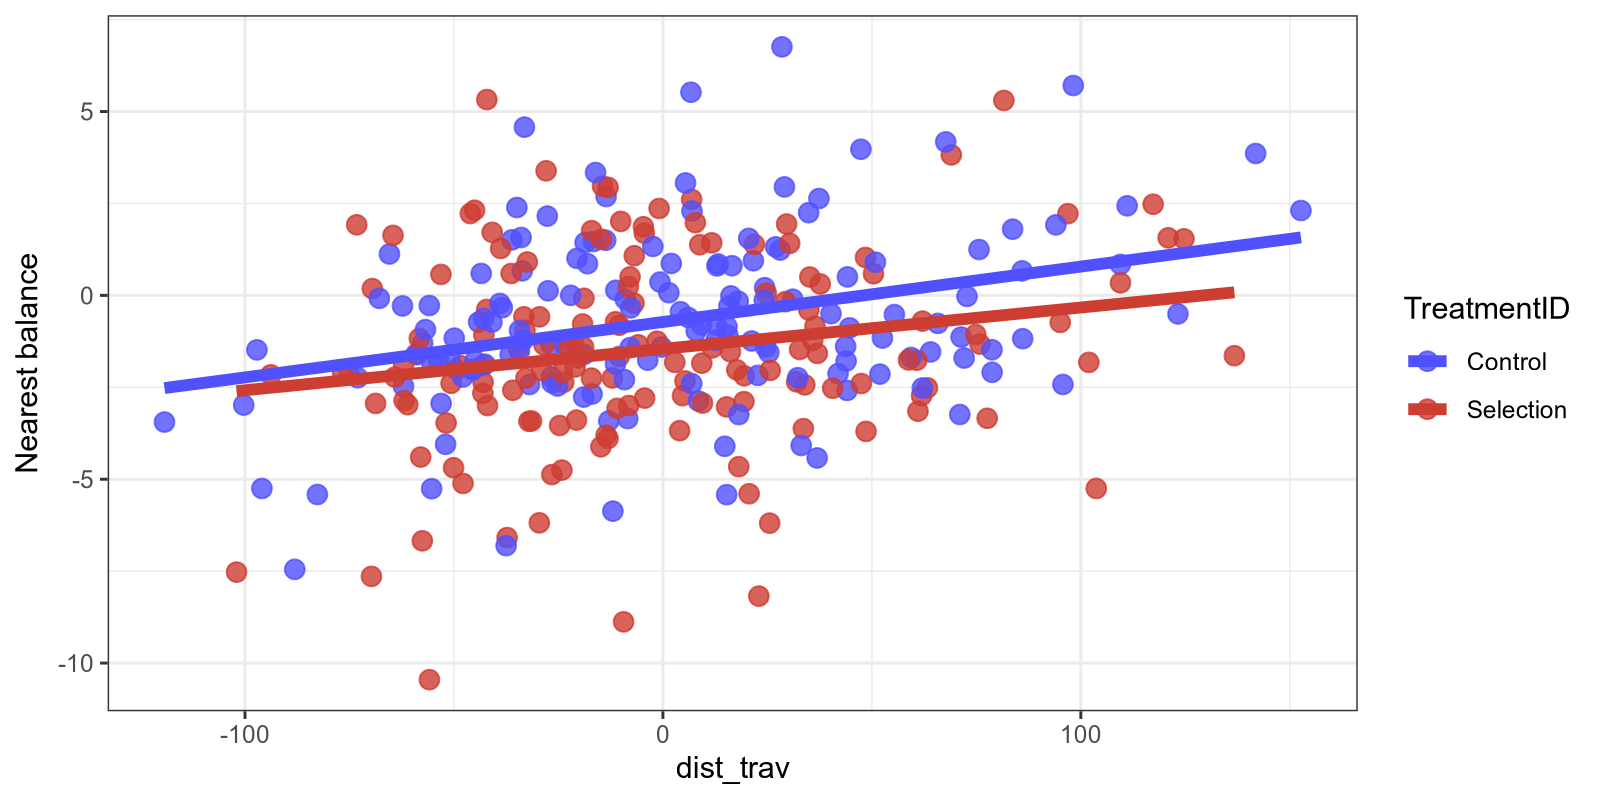

In [282]:
# same plot colored into interesting factors
p.dims(8,4)
ggplot(nb_vals_meta_full, aes(x = !!sym(sel_factor), y = NB_Value, group = TreatmentID)) +
	geom_point(aes(color = TreatmentID), alpha=0.8, size=3) +
	geom_smooth(aes(color = TreatmentID), method = "lm", se = FALSE, size=2) +	
	labs(x = sel_factor, y = "Nearest balance") + theme(legend.position = "none") +	
	theme_bw() +
	scale_color_igv()
	

In [283]:
aaa = nb_vals_meta_full %>% mutate(TreatmentID = factor(TreatmentID),
	generation = factor(generation)) %>% 
	#select(Sample, NB_Value, generation, TreatmentID, BWi34, dist_trav, res_dist_trav)
    select(Sample, NB_Value, generation, TreatmentID, BWi34, dist_trav)
aaa

Sample   NB_Value  generation TreatmentID BWi34 dist_trav
1   R1N1C001  2.389733 N0         Control     6.71  -34.94761
2   R1N1C003 -1.082313 N0         Control     7.29   15.53818
3   R1N1C005 -2.424407 N0         Control     6.95  -31.91899
⋮   ⋮        ⋮         ⋮          ⋮           ⋮     ⋮        
302 R4N5T318 -5.250647 N4         Selection   15.78 103.69702
303 R4N5T320 -8.179657 N4         Selection   12.87  22.95042

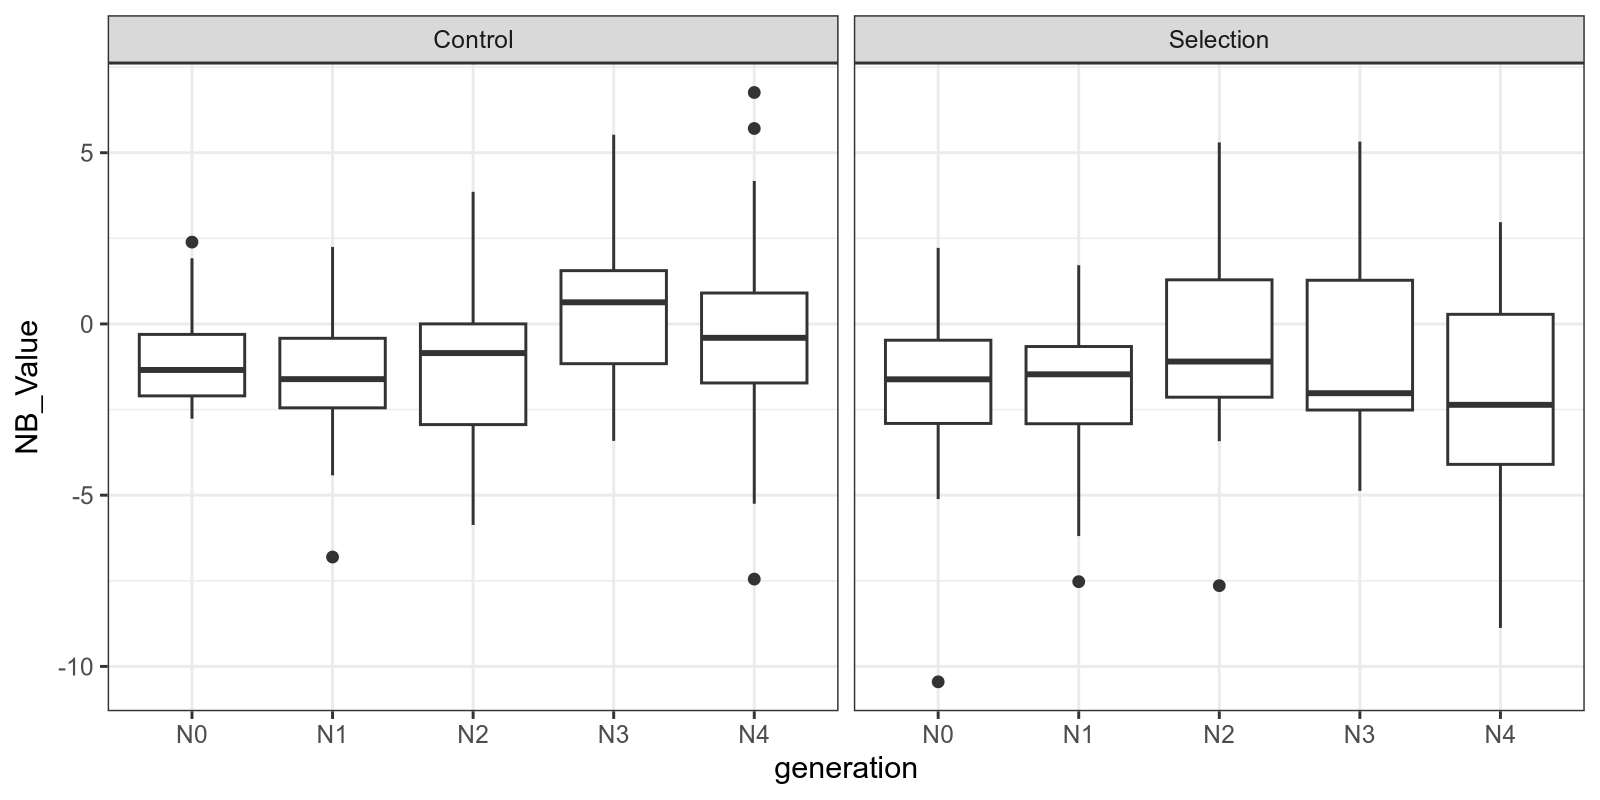

In [284]:
aaa  %>% ggplot(aes(x = generation, y = NB_Value)) +
	geom_boxplot() +
	facet_grid(. ~ TreatmentID) +
	theme_bw() +
	#scale_color_simpsons()
	scale_fill_igv()

`geom_smooth()` using formula = 'y ~ x'


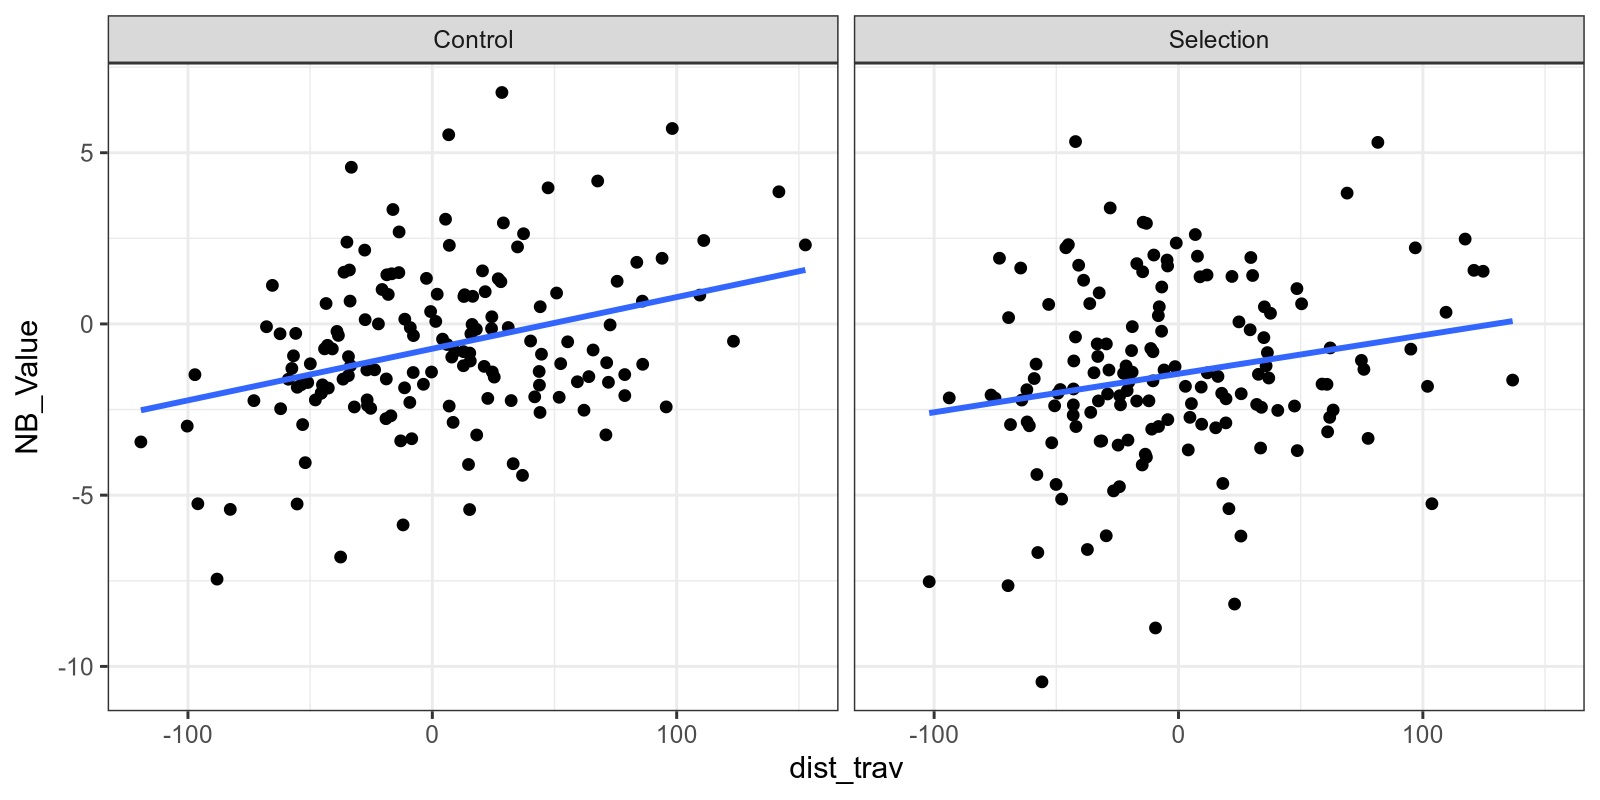

In [285]:
p.dims(8,4)
aaa  %>% ggplot(aes(x = dist_trav, y = NB_Value)) +
	geom_point() +
	#geom_smooth(aes(color = generation), method = "lm", se = FALSE) +
	geom_smooth(method = "lm", se = FALSE) +
	facet_grid(. ~ TreatmentID) +
	theme_bw() +
	scale_color_simpsons()


`geom_smooth()` using formula = 'y ~ x'


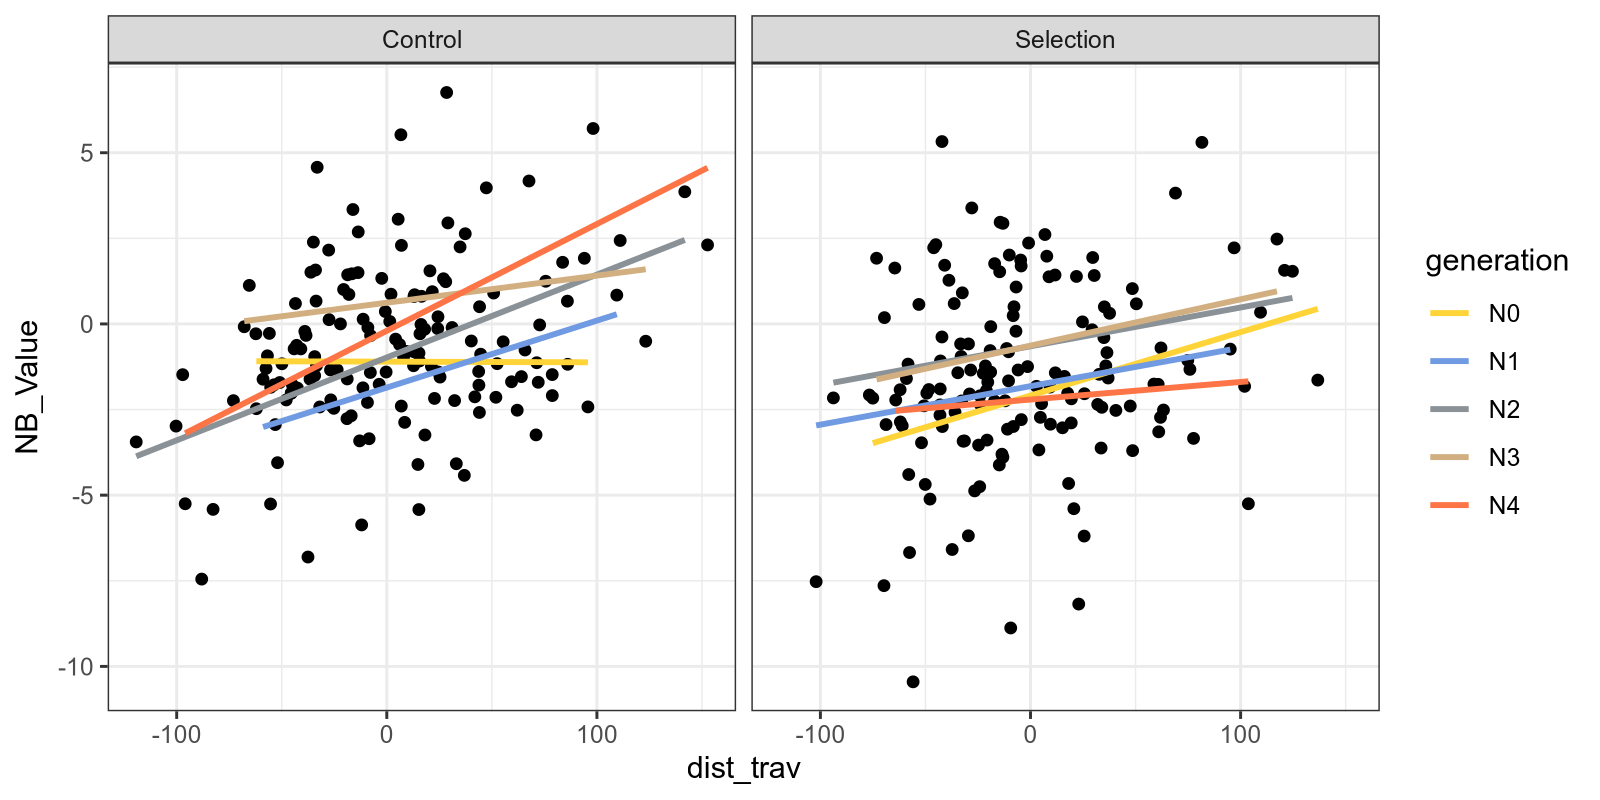

In [286]:
p.dims(8,4)
aaa  %>% ggplot(aes(x = dist_trav, y = NB_Value, group = generation)) +
	geom_point() +
	geom_smooth(aes(color = generation), method = "lm", se = FALSE) +
	facet_grid(. ~ TreatmentID) +
	theme_bw() +
	scale_color_simpsons()


## Descriptive stats on metabolites (adjusted by BWi34 by this time)

### Targeted

In [287]:
metabo_trg_long = memeta_2_trg %>% select(AnimalID, metabs_united) %>% 
	pivot_longer(cols = -AnimalID, names_to = "Molecule_Name", values_to = "value") 
metabo_trg_long

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(metabs_united)

  # Now:
  data %>% select(all_of(metabs_united))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


AnimalID Molecule_Name            value       
1    R1N1C001 Indolelactic_acid         0.0615176  
2    R1N1C001 Indoxylsulfate            0.2388897  
3    R1N1C001 Indole_3_propionic_acid  -1.0654844  
⋮    ⋮        ⋮                        ⋮           
1415 R4N5T320 Kynurenic_acid           -0.009911653
1416 R4N5T320 y_Aminobutyric_acid_GABA -0.110656225

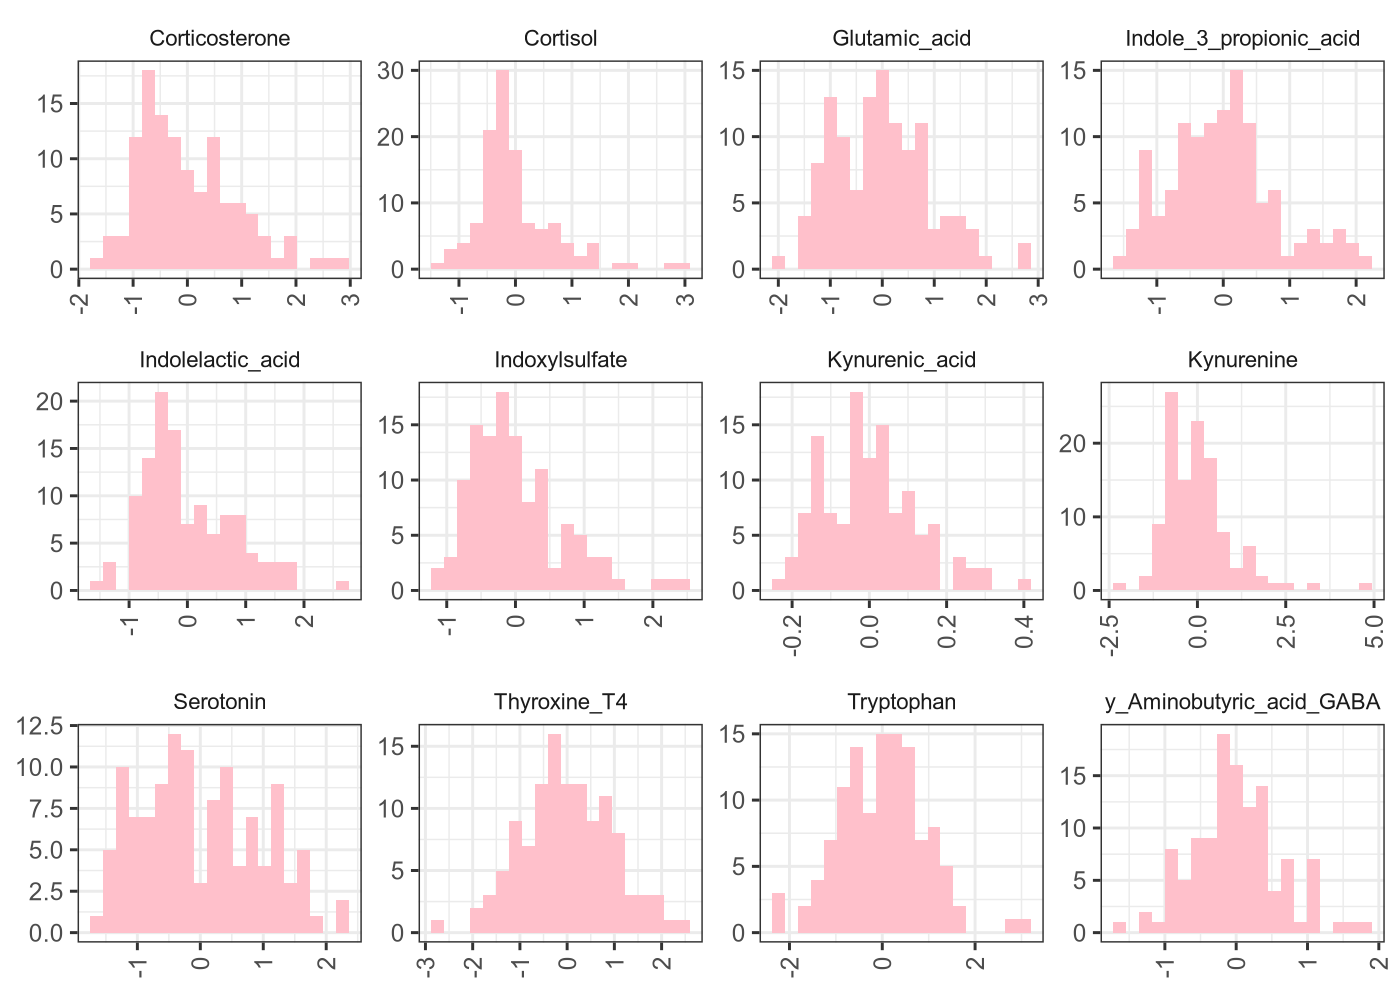

In [288]:
# histograms of Area for each Molecule_Name
p.dims(7, 5)
#p.dims(7, 10)
metabo_trg_long %>% 
	ggplot(aes(x = value)) +
	# fill them red
	geom_histogram(bins = 20, fill = "pink") +	
	facet_wrap(~Molecule_Name, scales = "free", ncol = 4) +
	theme_bw() +
	theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5)) +
	theme(axis.text.y = element_text(angle = 0, hjust = 1, vjust = 0.5)) +
	theme(axis.title.x = element_blank()) +
	theme(axis.title.y = element_blank()) +
	theme(strip.text = element_text(size = 8)) +
	theme(strip.background = element_blank()) +
	theme(legend.position = "none")

In [289]:
metabo_trg = metabo_trg_long %>%
	pivot_wider(names_from = Molecule_Name, values_from = value) %>%
	column_to_rownames("AnimalID") %>%
	as.data.frame()
metabo_trg

Indolelactic_acid Indoxylsulfate Indole_3_propionic_acid Cortisol  
R1N1C001 0.0615176          0.23888973    -1.065484               0.2453456 
R1N1C003 0.0568832         -0.14974854    -0.729802               0.8881352 
R1N1C005 1.4706464         -0.09874992     2.147966               0.8299338 
⋮        ⋮                 ⋮              ⋮                       ⋮         
R4N5T318 -0.1334651        -0.14056448    -0.9059691              -0.1356461
R4N5T320 -0.5362981         0.07112977    -0.9135559              -0.4382994
         Tryptophan  Thyroxine_T4 Kynurenine  Serotonin  Corticosterone
R1N1C001  1.73311156  0.02519366  -0.6668299   1.1885306 0.06882749    
R1N1C003  0.77461032  0.19119146   1.6994129  -0.2474590 1.88683479    
R1N1C005 -0.01378314 -0.73320341   0.3964652  -0.4875808 1.17861436    
⋮        ⋮           ⋮            ⋮           ⋮          ⋮             
R4N5T318 -2.257129    0.5523505   -0.85886716 -1.0394325 -0.7469192    
R4N5T320 -1.405704   -0.2939660    0.04035511  0.2217766  0.5301893    
         Glutamic_acid Kynurenic_acid y_Aminobutyric_acid_GABA
R1N1C001 -1.8769956     0.16616567     0.14916154             
R1N1C003  1.9199923     0.11988900    -0.51031296             
R1N1C005  0.2230279    -0.02527093     0.07396041             
⋮        ⋮             ⋮              ⋮                       
R4N5T318 -0.6388798    -0.187062347   -0.1882914              
R4N5T320 -0.7601085    -0.009911653   -0.1106562

#### Beta

In [290]:
# basic dissimilarity metric
beta_metabo_trg = metabo_trg %>% vegdist(method = "euclidean")

In [291]:
# do PERMANOVA
df.dims(20)
# now that we adjusted for BWi34, it's logical the respective factor is n/s
adonis2(beta_metabo_trg ~ dist_trav + BWi34 + Generation_num:TreatmentID + Generation_num + TreatmentID, data = memeta_2_trg, permutations = N_PERMANOVA, by = "terms")
df.dims(5)

Df  SumOfSqs    R2           F          Pr(>F)
dist_trav                    1   9.2935569 0.0099363853 1.25868141 0.2520
BWi34                        1   0.6247605 0.0006679747 0.08461501 1.0000
Generation_num               1  62.7698184 0.0671115596 8.50128798 0.0001
TreatmentID                  1  29.2746640 0.0312995705 3.96484099 0.0005
Generation_num:TreatmentID   1   6.3834546 0.0068249933 0.86454903 0.5321
Residual                   112 826.9593593 0.8841595167         NA     NA
Total                      117 935.3056137 1.0000000000         NA     NA

In [292]:
dim(beta_metabo_trg)

[1] 118 118

In [293]:
pve = round(ape::pcoa(beta_metabo_trg)$values$Relative_eig[1:3] * 100, 1) 
# concatenate those values to PC1 and PC2
pve = paste0("PC", 1:3, " (", pve, "%)")
pve


[1] "PC1 (22.4%)" "PC2 (19%)"   "PC3 (14.5%)"

In [294]:
pcoa_metabo_trg <- cmdscale(k = 3, beta_metabo_trg, eig = TRUE, add = TRUE)

In [295]:
pcoa_metabo_trg = as.data.frame(pcoa_metabo_trg$points) %>% 
	rename(PCo1 = V1, PCo2 = V2, PCo3 = V3) %>%
	mutate(Sample = rownames(pcoa_metabo_trg$points))


In [296]:
memeta_2 %>% select(AnimalID)

AnimalID
1   R1N1C001
2   R1N1C003
3   R1N1C005
⋮   ⋮       
302 R4N5T318
303 R4N5T320

In [297]:
pcoa_metabo_trg = 
	pcoa_metabo_trg %>% inner_join(memeta_2, by = c("Sample" = "AnimalID"))	
pcoa_metabo_trg


PCo1        PCo2       PCo3        Sample   TreatmentID replicate
1    2.35942088 0.1717991  -0.4451729  R1N1C001 Control     R1       
2   -1.24559559 2.5459475   0.2078965  R1N1C003 Control     R1       
3    0.09512432 1.6760832  -0.1156144  R1N1C005 Control     R1       
⋮   ⋮           ⋮          ⋮           ⋮        ⋮           ⋮        
117 -0.8591667  -2.4245774  0.01161409 R4N5T318 Selection   R4       
118 -0.1339705  -0.7606227 -0.87870701 R4N5T320 Selection   R4       
    generation AnimalID_of_donor Date_inoculated Date_dissected ⋯
1   N0         TSU201            2020_09_15      2020_09_30     ⋯
2   N0         TSU201            2020_09_15      2020_09_30     ⋯
3   N0         TSU201            2020_09_15      2020_09_30     ⋯
⋮   ⋮          ⋮                 ⋮               ⋮              ⋱
117 N4         R4N4T272          2020_12_02      2020_12_18     ⋯
118 N4         R4N4T272          2020_12_02      2020_12_18     ⋯
    Indole_3_propionic_acid Cortisol   Tryptophan  Thyroxine_T4 Kynurenine 
1   -1.065484               0.2453456   1.73311156  0.02519366  -0.6668299 
2   -0.729802               0.8881352   0.77461032  0.19119146   1.6994129 
3    2.147966               0.8299338  -0.01378314 -0.73320341   0.3964652 
⋮   ⋮                       ⋮          ⋮           ⋮            ⋮          
117 -0.9059691              -0.1356461 -2.257129    0.5523505   -0.85886716
118 -0.9135559              -0.4382994 -1.405704   -0.2939660    0.04035511
    Serotonin  Corticosterone Glutamic_acid Kynurenic_acid
1    1.1885306 0.06882749     -1.8769956     0.16616567   
2   -0.2474590 1.88683479      1.9199923     0.11988900   
3   -0.4875808 1.17861436      0.2230279    -0.02527093   
⋮   ⋮          ⋮              ⋮             ⋮             
117 -1.0394325 -0.7469192     -0.6388798    -0.187062347  
118  0.2217766  0.5301893     -0.7601085    -0.009911653  
    y_Aminobutyric_acid_GABA
1    0.14916154             
2   -0.51031296             
3    0.07396041             
⋮   ⋮                       
117 -0.1882914              
118 -0.1106562

In [298]:
colnames(pcoa_metabo_trg)


[1] "PCo1"                                      
 [2] "PCo2"                                      
 [3] "PCo3"                                      
 [4] "Sample"                                    
 [5] "TreatmentID"                               
 [6] "replicate"                                 
 [7] "generation"                                
 [8] "AnimalID_of_donor"                         
 [9] "Date_inoculated"                           
[10] "Date_dissected"                            
[11] "BWi34"                                     
[12] "Body_weight_at_dissection_g_5_6_weeks_old_"
[13] "Fat_mass_g_"                               
[14] "Lean_mass_g_"                              
[15] "Water_mass_g_"                             
[16] "Tail_length_mm_"                           
[17] "Body_length_mm_"                           
[18] "Post_QC_sequences"                         
[19] "Batch"                                     
[20] "Generation_num"                            
[21] "med_BM34"                                  
[22] "Generation_num_TreatmentID"                
[23] "dist_trav"                                 
[24] "Indolelactic_acid"                         
[25] "Indoxylsulfate"                            
[26] "Indole_3_propionic_acid"                   
[27] "Cortisol"                                  
[28] "Tryptophan"                                
[29] "Thyroxine_T4"                              
[30] "Kynurenine"                                
[31] "Serotonin"                                 
[32] "Corticosterone"                            
[33] "Glutamic_acid"                             
[34] "Kynurenic_acid"                            
[35] "y_Aminobutyric_acid_GABA"

#### PCoA

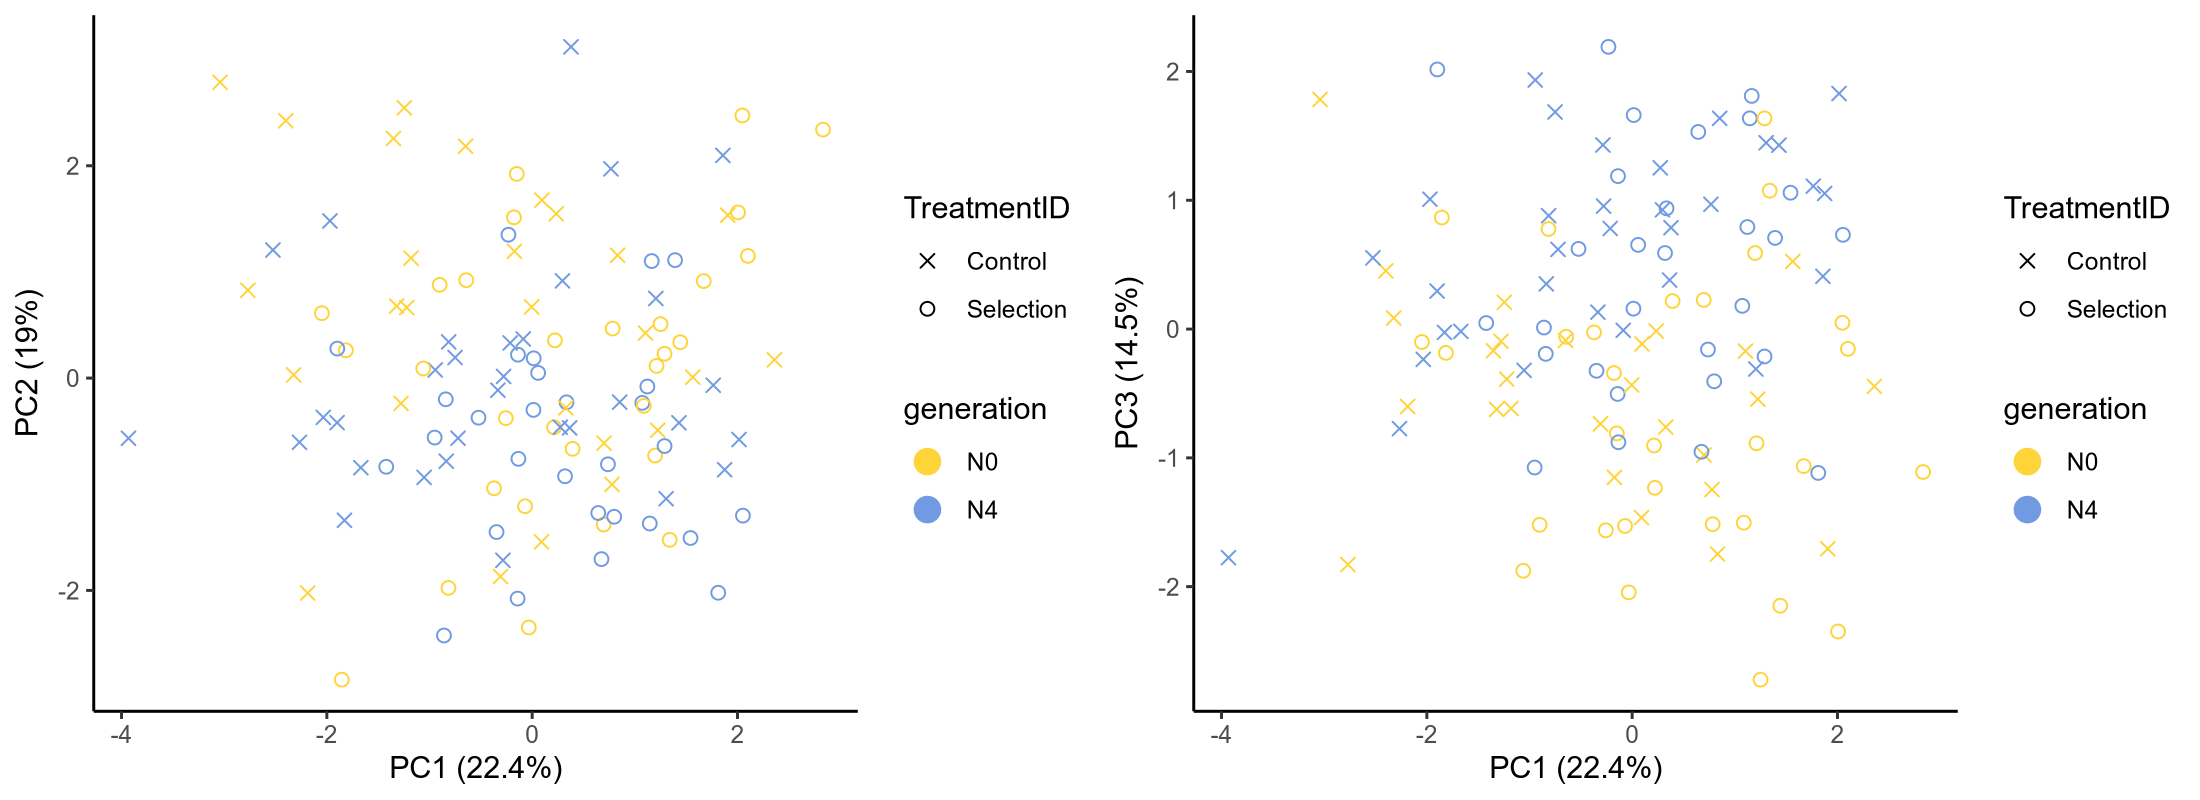

In [299]:
p.dims(11, 4)
# plot PC1-2 and PC2-3 next to each other
# PC1-2:
p1 <-   
  ggplot(pcoa_metabo_trg, aes(x = PCo1, y = PCo2, color = generation, shape = TreatmentID)) + 
  geom_point(size = 2) +    
  #geom_jitter(size = 2, position = position_jitter(width = 2, height = 2)) +    
  xlab(pve[1]) +
  ylab(pve[2]) +   
  theme_classic() +   
	scale_color_simpsons() +
  scale_shape_manual(values=c(4, 1)) +
  # increase bullets size in legend
  guides(color = guide_legend(override.aes = list(size = 4)))
#p1

# PC1-3:
p2 <-   
  ggplot(pcoa_metabo_trg, aes(x = PCo1, y = PCo3, color = generation, shape = TreatmentID)) + 
  geom_point(size = 2) +  
  #geom_jitter(size = 2, position = position_jitter(width = 2, height = 2)) +    
  xlab(pve[1]) +
  ylab(pve[3]) +   
  theme_classic() +    
  scale_color_simpsons() +
  scale_shape_manual(values=c(4, 1)) +
  # increase bullets size in legend
  guides(color = guide_legend(override.aes = list(size = 4)))
#p2
# plot p1 and p2 next to each other
gridExtra::grid.arrange(p1, p2, ncol=2)



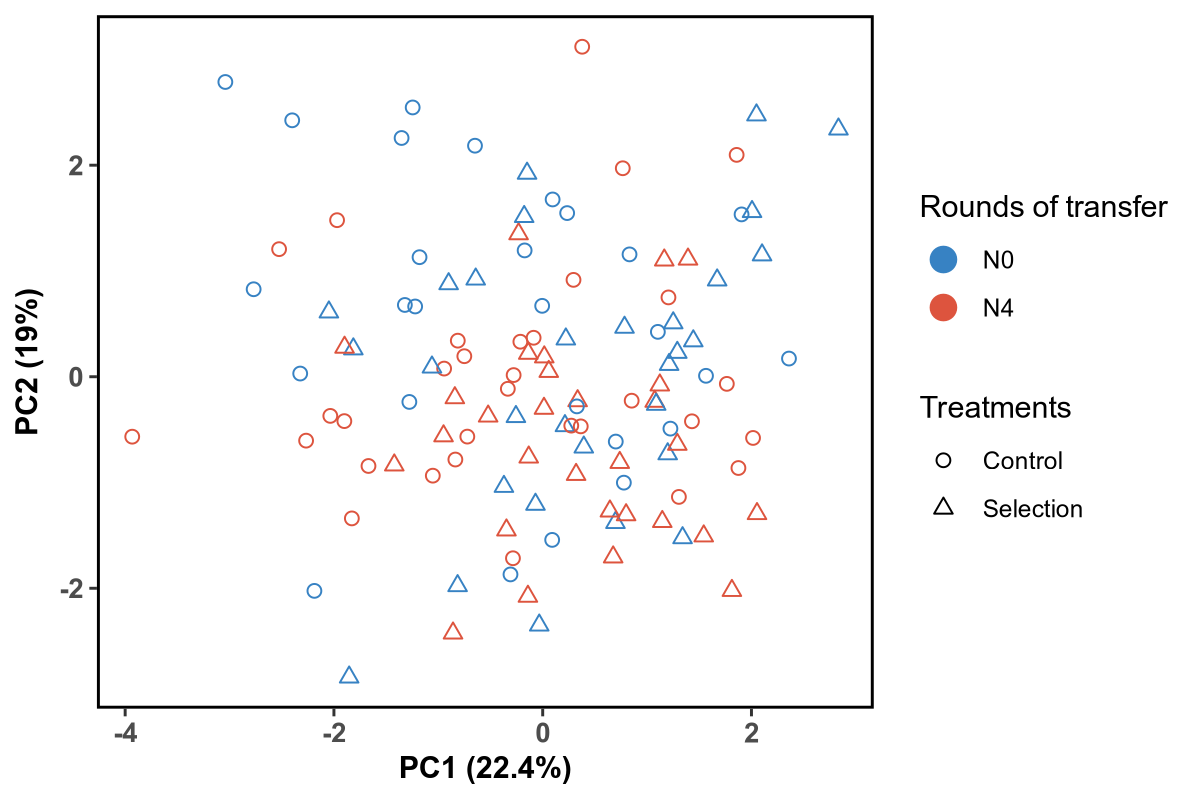

In [300]:
# Fig. 4A

p.dims(6, 4)

ggplot(pcoa_metabo_trg, aes(x = PCo1, y = PCo2, color = generation, shape = TreatmentID)) + 
	geom_point(size = 2) +    
	#geom_jitter(size = 2, position = position_jitter(width = 2, height = 2)) +    
	xlab(pve[1]) +
	ylab(pve[2]) +   
	theme_bw() + 
	scale_color_manual("Rounds of transfer", values = c("N0" = "#3782c3", "N4" = "#dd543e")) +
	
	theme(		
		panel.grid.major = element_blank(),
		panel.grid.minor = element_blank(),
		strip.background = element_blank(),
		strip.text.x = element_blank(),
		panel.border = element_rect(colour = "black", linewidth = 1),
		axis.text.x = element_text(size = 10, face = "bold"),
		axis.text.y = element_text(size = 10, face = "bold"),
		axis.title.x = element_text(size = 11, face = "bold"),
		axis.title.y = element_text(size = 11, face = "bold"),
	) +
	#scale_shape_manual(values=c(4, 1)) +
	scale_shape_manual("Treatments", values=c(1, 2)) +

	# increase bullets size in legend
	guides(color = guide_legend(override.aes = list(size = 4)))

#### Stats

In [301]:
# make generation (which here has N1 and N5 values only) a factor
pcoa_metabo_trg = pcoa_metabo_trg %>% mutate(generation_n0n4_fac = as.factor(generation))

In [302]:
# add factor to the input for the model
lm_in = metabo_trg_long %>% 	
	inner_join(pcoa_metabo_trg %>% select(Sample, dist_trav, generation_n0n4_fac, replicate, BWi34, TreatmentID), by = c("AnimalID" = "Sample"))
lm_in

AnimalID Molecule_Name            value        dist_trav
1    R1N1C001 Indolelactic_acid         0.0615176   -34.94761
2    R1N1C001 Indoxylsulfate            0.2388897   -34.94761
3    R1N1C001 Indole_3_propionic_acid  -1.0654844   -34.94761
⋮    ⋮        ⋮                        ⋮            ⋮        
1415 R4N5T320 Kynurenic_acid           -0.009911653 22.95042 
1416 R4N5T320 y_Aminobutyric_acid_GABA -0.110656225 22.95042 
     generation_n0n4_fac replicate BWi34 TreatmentID
1    N0                  R1        6.71  Control    
2    N0                  R1        6.71  Control    
3    N0                  R1        6.71  Control    
⋮    ⋮                   ⋮         ⋮     ⋮          
1415 N4                  R4        12.87 Selection  
1416 N4                  R4        12.87 Selection

In [303]:
# using purr functions: get raw Spearman correlation of distance traveled with each metabolite - for all samples, for N0 only and for N4 only - and combine the results into one table
cor_metab_dist_trav = lm_in %>%     
    nest(data = -Molecule_Name) %>% 
    mutate(rho = map(data, ~cor.test(.$dist_trav, .$value, method = "spearman")$estimate),
        p = map(data, ~cor.test(.$dist_trav, .$value, method = "spearman")$p.value),
        rho_n0 = map(data, ~cor.test(.$dist_trav[.$generation_n0n4_fac == "N0"], .$value[.$generation_n0n4_fac == "N0"], method = "spearman")$estimate),
        p_n0 = map(data, ~cor.test(.$dist_trav[.$generation_n0n4_fac == "N0"], .$value[.$generation_n0n4_fac == "N0"], method = "spearman")$p.value),
        rho_n4 = map(data, ~cor.test(.$dist_trav[.$generation_n0n4_fac == "N4"], .$value[.$generation_n0n4_fac == "N4"], method = "spearman")$estimate),
        p_n4 = map(data, ~cor.test(.$dist_trav[.$generation_n0n4_fac == "N4"], .$value[.$generation_n0n4_fac == "N4"], method = "spearman")$p.value)
        ) %>%     
    select(-data) %>% 
    unnest(cols = c(rho, p, rho_n0, p_n0, rho_n4, p_n4)) %>% 
    arrange(p)
df.dims(20)
cor_metab_dist_trav
df.dims(5)

Molecule_Name            rho          p          rho_n0      p_n0     
1  Thyroxine_T4             -0.194497095 0.03496396 -0.04245528 0.7532689
2  y_Aminobutyric_acid_GABA  0.190129246 0.03932783  0.02184340 0.8716457
3  Indolelactic_acid        -0.184899514 0.04514631 -0.04057558 0.7638754
4  Corticosterone            0.133646679 0.14890370  0.04802956 0.7220891
5  Indoxylsulfate           -0.092721834 0.31748716 -0.11420793 0.3965646
6  Glutamic_acid             0.057165500 0.53811601  0.05379829 0.6902917
7  Serotonin                 0.046209357 0.61879822  0.10493907 0.4361853
8  Kynurenine               -0.045486252 0.62430261 -0.18602541 0.1655227
9  Tryptophan               -0.021967066 0.81309619  0.01425979 0.9160694
10 Cortisol                  0.021032142 0.82091554 -0.15044076 0.2632065
11 Indole_3_propionic_acid   0.001698202 0.98544740  0.07512315 0.5776745
12 Kynurenic_acid           -0.000997009 0.99146886  0.01205600 0.9290333
   rho_n4      p_n4      
1  -0.07636171 0.55767162
2   0.27297726 0.03361476
3  -0.17847700 0.16838123
4   0.02094130 0.87250522
5  -0.15187731 0.24194901
6   0.03664728 0.77868379
7  -0.14923321 0.25031721
8   0.13241671 0.30815831
9  -0.02279217 0.86133005
10 -0.02982549 0.81913030
11 -0.03664728 0.77868379
12 -0.13701745 0.29153612

In [304]:
# version of the same for a Suppl Table
cor_metab_dist_trav_Suppl = lm_in %>%     
    nest(data = -Molecule_Name) %>%     
    mutate(cort = map(data, ~cor.test(.$dist_trav, .$value, method = "spearman")),
        tidied = map(cort, tidy))  %>%     
    select(Molecule_Name, tidied) %>% 
    unnest(tidied) %>%
    select(-alternative, -method) %>%                 
    arrange(p.value) %>%
    mutate(p.adj = p.adjust(p.value, method = "fdr")) %>% 
    # round up to 4 digit
    mutate(estimate = round(estimate, 4), statistic = round(statistic, 4), p.value = round(p.value, 4), p.adj = round(p.adj, 4)) %>%
    rename(Metabolite = "Molecule_Name", "rho" = estimate, Statistic = "statistic", "p-value" = p.value, "q-value" = p.adj)    
df.dims(100)    
cor_metab_dist_trav_Suppl
df.dims(5)    
# save to file
options(scipen=0)
cor_metab_dist_trav_Suppl %>% write_tsv(file.path(work_dir, "out", "results_corr_dist_metabs.tsv"), )
options(scipen=10)


Metabolite               rho     Statistic p-value q-value
1  Thyroxine_T4             -0.1945 327076    0.0350  0.1806 
2  y_Aminobutyric_acid_GABA  0.1901 221758    0.0393  0.1806 
3  Indolelactic_acid        -0.1849 324448    0.0451  0.1806 
4  Corticosterone            0.1336 237224    0.1489  0.4467 
5  Indoxylsulfate           -0.0927 299208    0.3175  0.7620 
6  Glutamic_acid             0.0572 258166    0.5381  0.9365 
7  Serotonin                 0.0462 261166    0.6188  0.9365 
8  Kynurenine               -0.0455 286274    0.6243  0.9365 
9  Tryptophan               -0.0220 279834    0.8131  0.9851 
10 Cortisol                  0.0210 268060    0.8209  0.9851 
11 Indole_3_propionic_acid   0.0017 273354    0.9854  0.9915 
12 Kynurenic_acid           -0.0010 274092    0.9915  0.9915

In [305]:
ila = lm_in %>% filter(Molecule_Name == "Indolelactic_acid") %>% 
    pivot_wider(names_from = Molecule_Name, values_from = value)
ila
ila %>% select(Indolelactic_acid) %>% pull() %>% summary_x()

AnimalID dist_trav generation_n0n4_fac replicate BWi34 TreatmentID
1   R1N1C001 -34.94761 N0                  R1        6.71  Control    
2   R1N1C003  15.53818 N0                  R1        7.29  Control    
3   R1N1C005 -31.91899 N0                  R1        6.95  Control    
⋮   ⋮        ⋮         ⋮                   ⋮         ⋮     ⋮          
117 R4N5T318 103.69702 N4                  R4        15.78 Selection  
118 R4N5T320  22.95042 N4                  R4        12.87 Selection  
    Indolelactic_acid
1   0.0615176        
2   0.0568832        
3   1.4706464        
⋮   ⋮                
117 -0.1334651       
118 -0.5362981

Min.      1st Qu.    Median     Mean       3rd Qu.   Max.    sd   
. -1.555891 -0.5450387 -0.2292273 0.01064458 0.5751787 2.65483 0.795
  sd_err_of_mean
. 0.324

[1] 0.0451

[1] -0.18

Warning message in annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_ila_dist, :
“Ignoring unknown parameters: `label.size`”
`geom_smooth()` using formula = 'y ~ x'


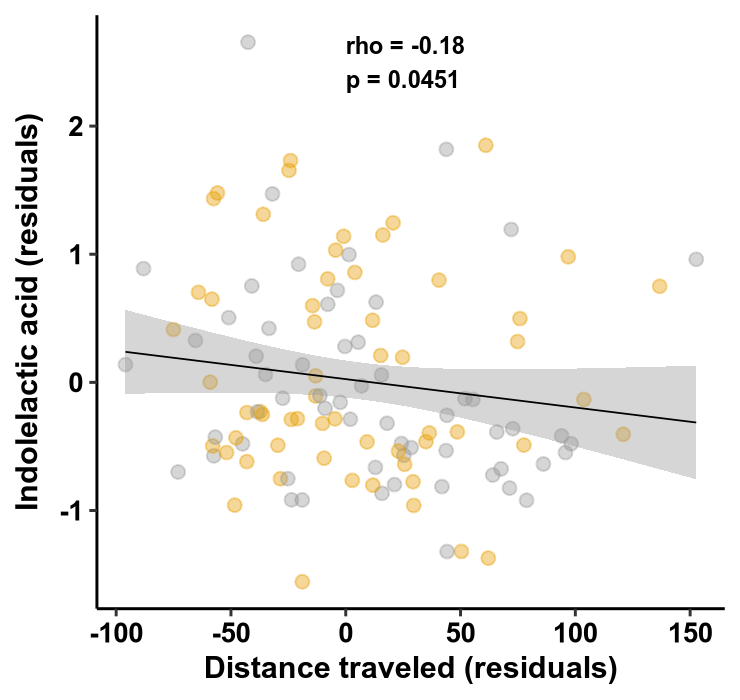

In [306]:
# Fig. 4C

# plot ILA vs dist_trav
tmp = cor_metab_dist_trav %>% filter(Molecule_Name == "Indolelactic_acid")
p_ila_dist = round(tmp$p, 4)
p_ila_dist
rho_ila_dist = round(tmp$rho, 2)
rho_ila_dist

p.dims(3.7, 3.5)

ila %>% ggplot(aes(x = dist_trav, y = Indolelactic_acid, color = TreatmentID)) +    
    # fancy points
    geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
    geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +

    theme_classic() +        
    # axis labels    
    labs(x = "Distance traveled (residuals)", y = "Indolelactic acid (residuals)") +

    theme(
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9, face = "bold"),        

        axis.text.x = element_text(size = 10, face = "bold", color = "black"),
        axis.text.y = element_text(size = 10, face = "bold", color = "black"),
        axis.title.x = element_text(size = 11, face = "bold", color = "black"),
        axis.title.y = element_text(size = 11, face = "bold", color = "black"), 
        legend.position = "none"
    ) +
    scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +    
    annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_ila_dist, "\np = ", p_ila_dist), size = 3, label.size = 0, color = "black", fontface = "bold", hjust = 0) 
    



In [307]:
# Fig. S9 a

# plot thyroxine vs dist_trav
tmp = cor_metab_dist_trav %>% filter(Molecule_Name == "Thyroxine_T4")
p_dist = round(tmp$p, 4)
p_dist
rho_dist = round(tmp$rho, 2)
rho_dist

#p.dims(3.7, 3.5)

p_Thyr = lm_in %>% filter(Molecule_Name == "Thyroxine_T4") %>% 
    pivot_wider(names_from = Molecule_Name, values_from = value) %>% 
    ggplot(aes(x = dist_trav, y = Thyroxine_T4, color = TreatmentID)) +    
    # fancy points
    geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
    geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +

    theme_classic() +        
    # axis labels    
    labs(x = "Distance traveled (residuals)", y = "Thyroxine_T4 (residuals)") +        

    theme(
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9, face = "bold"),        

        axis.text.x = element_text(size = 10, face = "bold", color = "black"),
        axis.text.y = element_text(size = 10, face = "bold", color = "black"),
        axis.title.x = element_text(size = 11, face = "bold", color = "black"),
        axis.title.y = element_text(size = 11, face = "bold", color = "black"), 
        legend.position = "none"
    ) +
    scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +    
    annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_dist, "\np = ", p_dist), size = 3, label.size = 0, color = "black", fontface = "bold", hjust = 0) 

[1] 0.035

[1] -0.19

Warning message in annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_dist, :
“Ignoring unknown parameters: `label.size`”


In [308]:
# Fig. S9 b

# plot GABA vs dist_trav
tmp = cor_metab_dist_trav %>% filter(Molecule_Name == "y_Aminobutyric_acid_GABA")
p_dist = round(tmp$p, 4)
p_dist
rho_dist = round(tmp$rho, 2)
rho_dist

p.dims(3.7, 3.5)

p_GABA = lm_in %>% filter(Molecule_Name == "y_Aminobutyric_acid_GABA") %>% 
    pivot_wider(names_from = Molecule_Name, values_from = value) %>% 
    ggplot(aes(x = dist_trav, y = y_Aminobutyric_acid_GABA, color = TreatmentID)) +    
    # fancy points
    geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
    geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +

    theme_classic() +        
    # axis labels    
    labs(x = "Distance traveled (residuals)", y = "GABA (residuals)") +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9, face = "bold"),        

        axis.text.x = element_text(size = 10, face = "bold", color = "black"),
        axis.text.y = element_text(size = 10, face = "bold", color = "black"),
        axis.title.x = element_text(size = 11, face = "bold", color = "black"),
        axis.title.y = element_text(size = 11, face = "bold", color = "black"), 
        legend.position = "none"
    ) +
    scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +        
    annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_dist, "\np = ", p_dist), size = 3, label.size = 0, color = "black", fontface = "bold", hjust = 0) 

[1] 0.0393

[1] 0.19

Warning message in annotate("text", x = 0, y = 2.5, label = paste0("rho = ", rho_dist, :
“Ignoring unknown parameters: `label.size`”


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


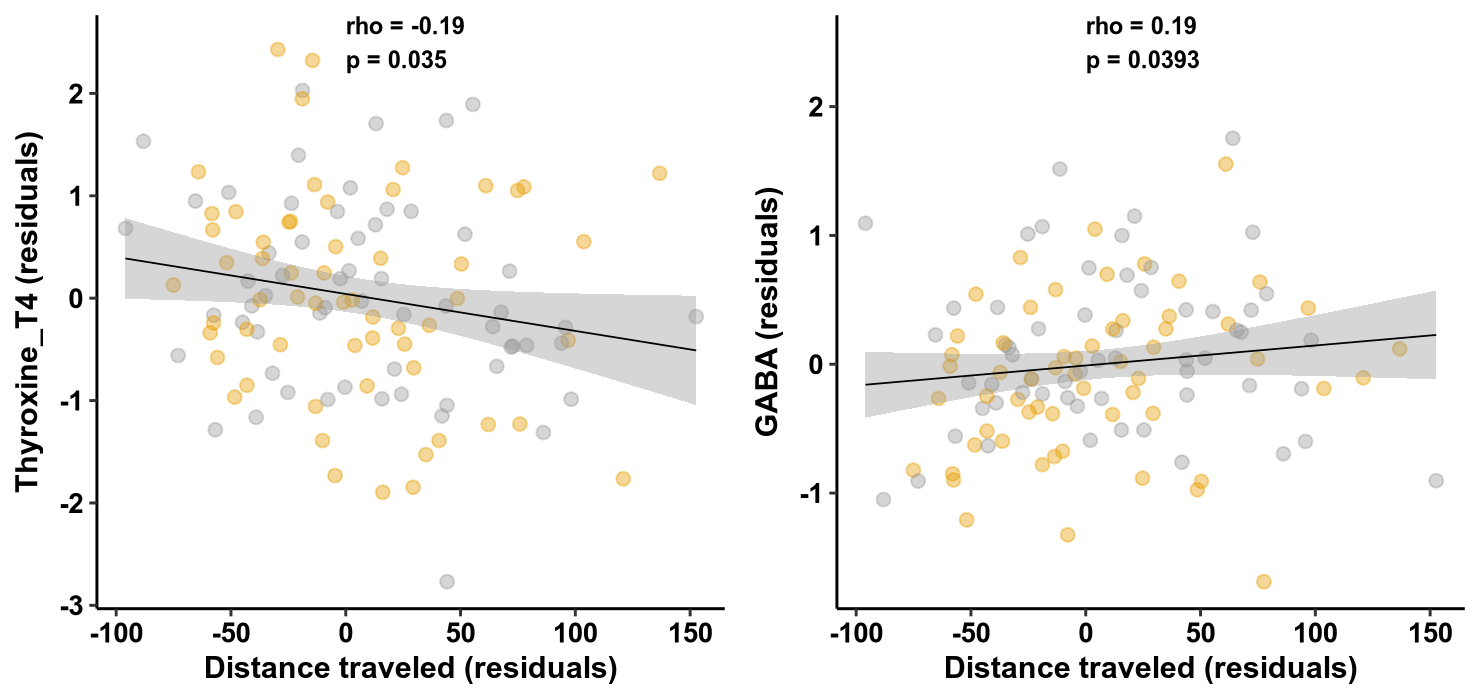

In [309]:
p.dims(7.4, 3.5)
gridExtra::grid.arrange(p_Thyr, p_GABA, ncol=2)

`geom_smooth()` using formula = 'y ~ x'


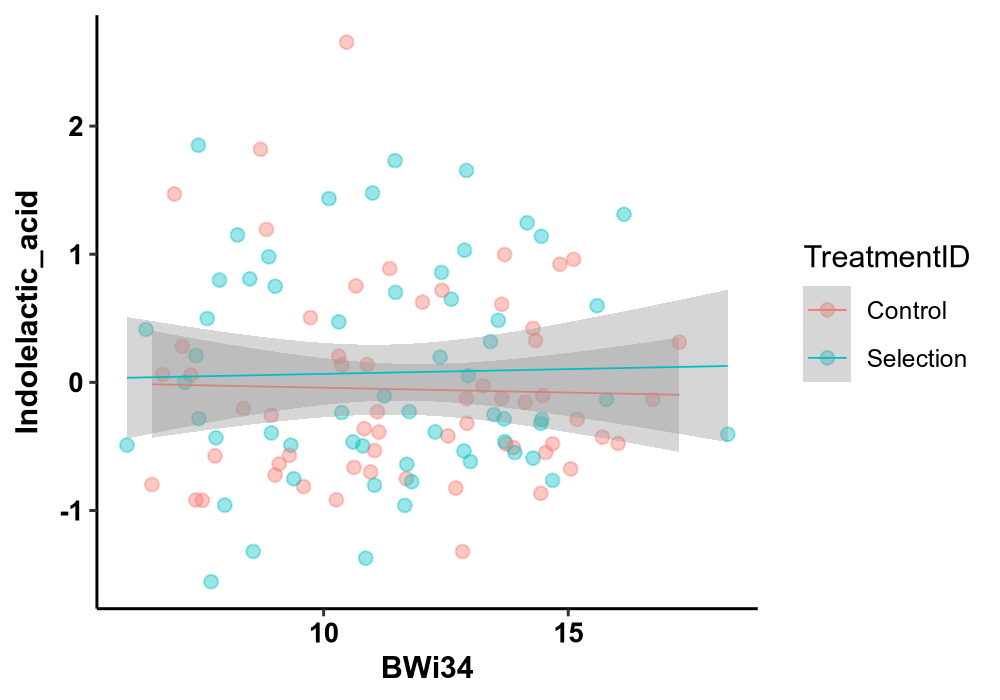

In [310]:
# plot ILA vs BWi34


p.dims(5, 3.5)
ila %>% ggplot(aes(x = BWi34, y = Indolelactic_acid, color = TreatmentID)) +    
    # fancy points
    geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
    geom_smooth(aes(color = TreatmentID), size = 0.3, method = "lm", se = TRUE) +

    theme_classic() +        
    # axis labels
    
    theme(
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9, face = "bold"),

        axis.text.x = element_text(size = 10, face = "bold", color = "black"),
        axis.text.y = element_text(size = 10, face = "bold", color = "black"),
        axis.title.x = element_text(size = 11, face = "bold", color = "black"),
        axis.title.y = element_text(size = 11, face = "bold", color = "black")
    )

In [311]:
ila_lacto = ila %>% inner_join(br_perc$Genus %>% filter(Genus == "Lactobacillus") %>% 
        select(Sample, name, Abundance), by = c("AnimalID" = "Sample"))
ila_lacto

AnimalID dist_trav generation_n0n4_fac replicate BWi34 TreatmentID
1   R1N5C241 -23.61344 N4                  R1        10.26 Control    
2   R3N5C303  98.18660 N4                  R3        14.68 Control    
3   R3N5T290 -36.31450 N4                  R3        13.48 Selection  
⋮   ⋮        ⋮         ⋮                   ⋮         ⋮     ⋮          
117 R1N5T244 -57.5691  N4                  R1        10.11 Selection  
118 R3N5T294  24.7311  N4                  R3        12.38 Selection  
    Indolelactic_acid name          Abundance
1   -0.9166867        Lactobacillus 0        
2   -0.4795780        Lactobacillus 0        
3   -0.2502703        Lactobacillus 0        
⋮   ⋮                 ⋮             ⋮        
117 1.434200          Lactobacillus 0.2964369
118 0.196004          Lactobacillus 0.3615306

In [312]:
# exploratory
ila_lacto_and_limo = ila %>% inner_join(br_perc$Genus %>% filter(Genus %in% c("Lactobacillus", "Limosilactobacillus")) %>% 
        group_by(Sample)  %>% 
        mutate(Lacto_and_Limo = sum(Abundance)) %>%
        ungroup() %>% 
        select(Sample, Lacto_and_Limo) %>%
        rename(Abundance = Lacto_and_Limo) %>%
        mutate(name = "Lacto_and_Limo") %>%
        distinct(),
        by = c("AnimalID" = "Sample"))
ila_lacto_and_limo

AnimalID dist_trav generation_n0n4_fac replicate BWi34 TreatmentID
1   R1N5C241 -23.61344 N4                  R1        10.26 Control    
2   R3N1C045  12.92128 N0                  R3        10.62 Control    
3   R3N1T042  62.09719 N0                  R3        10.86 Selection  
⋮   ⋮        ⋮         ⋮                   ⋮         ⋮     ⋮          
117 R1N5T248 -29.57095 N4                  R1         9.33 Selection  
118 R2N5C285 -42.56213 N4                  R2        10.47 Control    
    Indolelactic_acid Abundance  name          
1   -0.9166867        0.00000000 Lacto_and_Limo
2   -0.6635458        0.02616555 Lacto_and_Limo
3   -1.3719000        0.00390317 Lacto_and_Limo
⋮   ⋮                 ⋮          ⋮             
117 -0.490746         0.2606679  Lacto_and_Limo
118  2.654830         0.2265977  Lacto_and_Limo

[1] "1.1e-04"

cor 
0.35

`geom_smooth()` using formula = 'y ~ x'


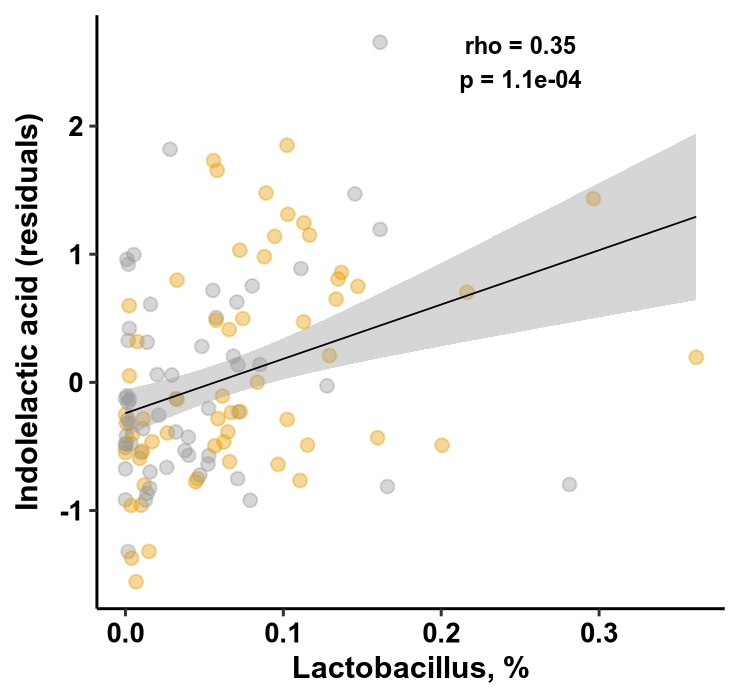

In [313]:
# Fig. 4E

# plot ILA vs Lactobacillus

cor_ila_lacto = cor.test(ila_lacto$Indolelactic_acid, ila_lacto$Abundance, method = "pearson")
p_ila_lacto = format(cor_ila_lacto$p.value, scientific = TRUE, digits = 2) 
p_ila_lacto
rho_ila_lacto = round(cor_ila_lacto$estimate, 2)
rho_ila_lacto

p.dims(3.7, 3.5)
ila_lacto %>% ggplot(aes(x = Abundance, y = Indolelactic_acid, color = TreatmentID)) +    
    # fancy points
    geom_point(aes(color = TreatmentID), size = 2, alpha = 0.4) +                
    geom_smooth(color = "black", size = 0.3, method = "lm", se = TRUE) +

    theme_classic() +        
    # axis labels
    #labs(x = "Lactobacillus, %", y = "Indolelactic acid (normalized)") +
    labs(x = "Lactobacillus, %", y = "Indolelactic acid (residuals)") +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_text(size = 9, face = "bold"),
        axis.text.x = element_text(size = 10, face = "bold", color = "black"),
        axis.text.y = element_text(size = 10, face = "bold", color = "black"),
        axis.title.x = element_text(size = 11, face = "bold", color = "black"),
        axis.title.y = element_text(size = 11, face = "bold", color = "black"), 
        legend.position = "none"
    ) +
    scale_color_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +    
    annotate("text", x = 0.25, y = 2.5, label = paste0("rho = ", rho_ila_lacto, "\np = ", p_ila_lacto), size = 3, color = "black", fontface = "bold") 
    

In [314]:
# Regression with multi factors
lm_res = 
    lm_in %>%
    nest(data = -Molecule_Name) %>%    
    mutate(fit = map(data, function(x) {        

        if(SELECT_TREATMENT == "both") {
            if(SELECT_GENERATION_NUM == "all") {
                lm1 = lm(value ~ generation_n0n4_fac * TreatmentID, data = x)
            } else {
                lm1 = lmer(value ~ dist_trav + BWi34 + TreatmentID + (1|replicate), data = x)
            }

        } else {
            if(SELECT_GENERATION_NUM == "all") {
                lm1 = lmer(value ~ dist_trav + generation_n0n4_fac + BWi34 + (1|replicate), data = x)        
            } else {
                lm1 = lmer(value ~ dist_trav + BWi34 + (1|replicate), data = x)        
            }
            
        }
        return(lm1)
    }),

    tidied = map(fit, tidy)) %>%
    
    select(Molecule_Name, tidied) %>% 

    unnest(tidied) %>%
    filter(term != "(Intercept)") %>% 
    #filter(effect != "ran_pars") %>% 
           
    arrange(desc(term), p.value) %>%
    mutate(p.adj = p.adjust(p.value, method = "fdr"))    
df.dims(100)    
lm_res
df.dims(5)    

Molecule_Name            term                                      
1  Cortisol                 generation_n0n4_facN4:TreatmentIDSelection
2  Tryptophan               generation_n0n4_facN4:TreatmentIDSelection
3  Kynurenic_acid           generation_n0n4_facN4:TreatmentIDSelection
4  Indole_3_propionic_acid  generation_n0n4_facN4:TreatmentIDSelection
5  Indoxylsulfate           generation_n0n4_facN4:TreatmentIDSelection
6  y_Aminobutyric_acid_GABA generation_n0n4_facN4:TreatmentIDSelection
7  Kynurenine               generation_n0n4_facN4:TreatmentIDSelection
8  Glutamic_acid            generation_n0n4_facN4:TreatmentIDSelection
9  Indolelactic_acid        generation_n0n4_facN4:TreatmentIDSelection
10 Thyroxine_T4             generation_n0n4_facN4:TreatmentIDSelection
11 Serotonin                generation_n0n4_facN4:TreatmentIDSelection
12 Corticosterone           generation_n0n4_facN4:TreatmentIDSelection
13 Cortisol                 generation_n0n4_facN4                     
14 Thyroxine_T4             generation_n0n4_facN4                     
15 Corticosterone           generation_n0n4_facN4                     
16 Indolelactic_acid        generation_n0n4_facN4                     
17 Indole_3_propionic_acid  generation_n0n4_facN4                     
18 Serotonin                generation_n0n4_facN4                     
19 Tryptophan               generation_n0n4_facN4                     
20 y_Aminobutyric_acid_GABA generation_n0n4_facN4                     
21 Kynurenine               generation_n0n4_facN4                     
22 Kynurenic_acid           generation_n0n4_facN4                     
23 Indoxylsulfate           generation_n0n4_facN4                     
24 Glutamic_acid            generation_n0n4_facN4                     
25 Kynurenine               TreatmentIDSelection                      
26 Cortisol                 TreatmentIDSelection                      
27 Serotonin                TreatmentIDSelection                      
28 Glutamic_acid            TreatmentIDSelection                      
29 Indoxylsulfate           TreatmentIDSelection                      
30 y_Aminobutyric_acid_GABA TreatmentIDSelection                      
31 Indole_3_propionic_acid  TreatmentIDSelection                      
32 Indolelactic_acid        TreatmentIDSelection                      
33 Corticosterone           TreatmentIDSelection                      
34 Tryptophan               TreatmentIDSelection                      
35 Kynurenic_acid           TreatmentIDSelection                      
36 Thyroxine_T4             TreatmentIDSelection                      
   estimate     std.error  statistic   p.value       p.adj      
1   0.441821053 0.24406854  1.81023354 0.07289374868 0.374882136
2  -0.556907356 0.34406489 -1.61861140 0.10829434565 0.404485385
3  -0.058514168 0.04417208 -1.32468669 0.18792444105 0.483234277
4   0.379999091 0.29852333  1.27292930 0.20563294890 0.484465670
5  -0.251682522 0.25099025 -1.00275816 0.31810127223 0.636202544
6  -0.192249537 0.22112765 -0.86940523 0.38645233499 0.727811599
7   0.268473626 0.34524006  0.77764332 0.43839016443 0.751525996
8  -0.127361286 0.33440406 -0.38086047 0.70401559242 0.981374675
9   0.100110411 0.28767954  0.34799281 0.72848732896 0.981374675
10  0.098322844 0.32713288  0.30055935 0.76429797261 0.981374675
11 -0.088311583 0.33172592 -0.26621852 0.79055182175 0.981374675
12 -0.051035978 0.32093337 -0.15902359 0.87393167157 0.992333338
13 -0.721341198 0.17288085 -4.17247609 0.00005908791 0.002127165
14  0.757714136 0.23171773  3.26998768 0.00142260785 0.025606941
15 -0.605578566 0.22732645 -2.66391605 0.00884254271 0.079582884
16  0.317951399 0.20377178  1.56033083 0.12145358212 0.404485385
17 -0.316093872 0.21145276 -1.49486757 0.13771202848 0.404485385
18 -0.347552392 0.23497112 -1.47912812 0.14186406010 0.404485385
19  0.303664701 0.24371117  1.24600238 0.21531807569 0.484465670
20 -0.158576385 0.15663115 -1.01241922 0.31348164097 0.636202544
21 -0.13811

In [315]:
lm_res_signif = lm_res %>% filter(p.adj < 0.1) %>% arrange(term, p.value)
df.dims(50) 
lm_res_signif %>% select(Molecule_Name, term, estimate, p.value, p.adj)
df.dims(5) 

Molecule_Name  term                  estimate   p.value       p.adj      
1 Kynurenine     TreatmentIDSelection  -0.6914761 0.00626161435 0.075139372
2 Cortisol       TreatmentIDSelection  -0.4447611 0.01262476864 0.090898334
3 Cortisol       generation_n0n4_facN4 -0.7213412 0.00005908791 0.002127165
4 Thyroxine_T4   generation_n0n4_facN4  0.7577141 0.00142260785 0.025606941
5 Corticosterone generation_n0n4_facN4 -0.6055786 0.00884254271 0.079582884

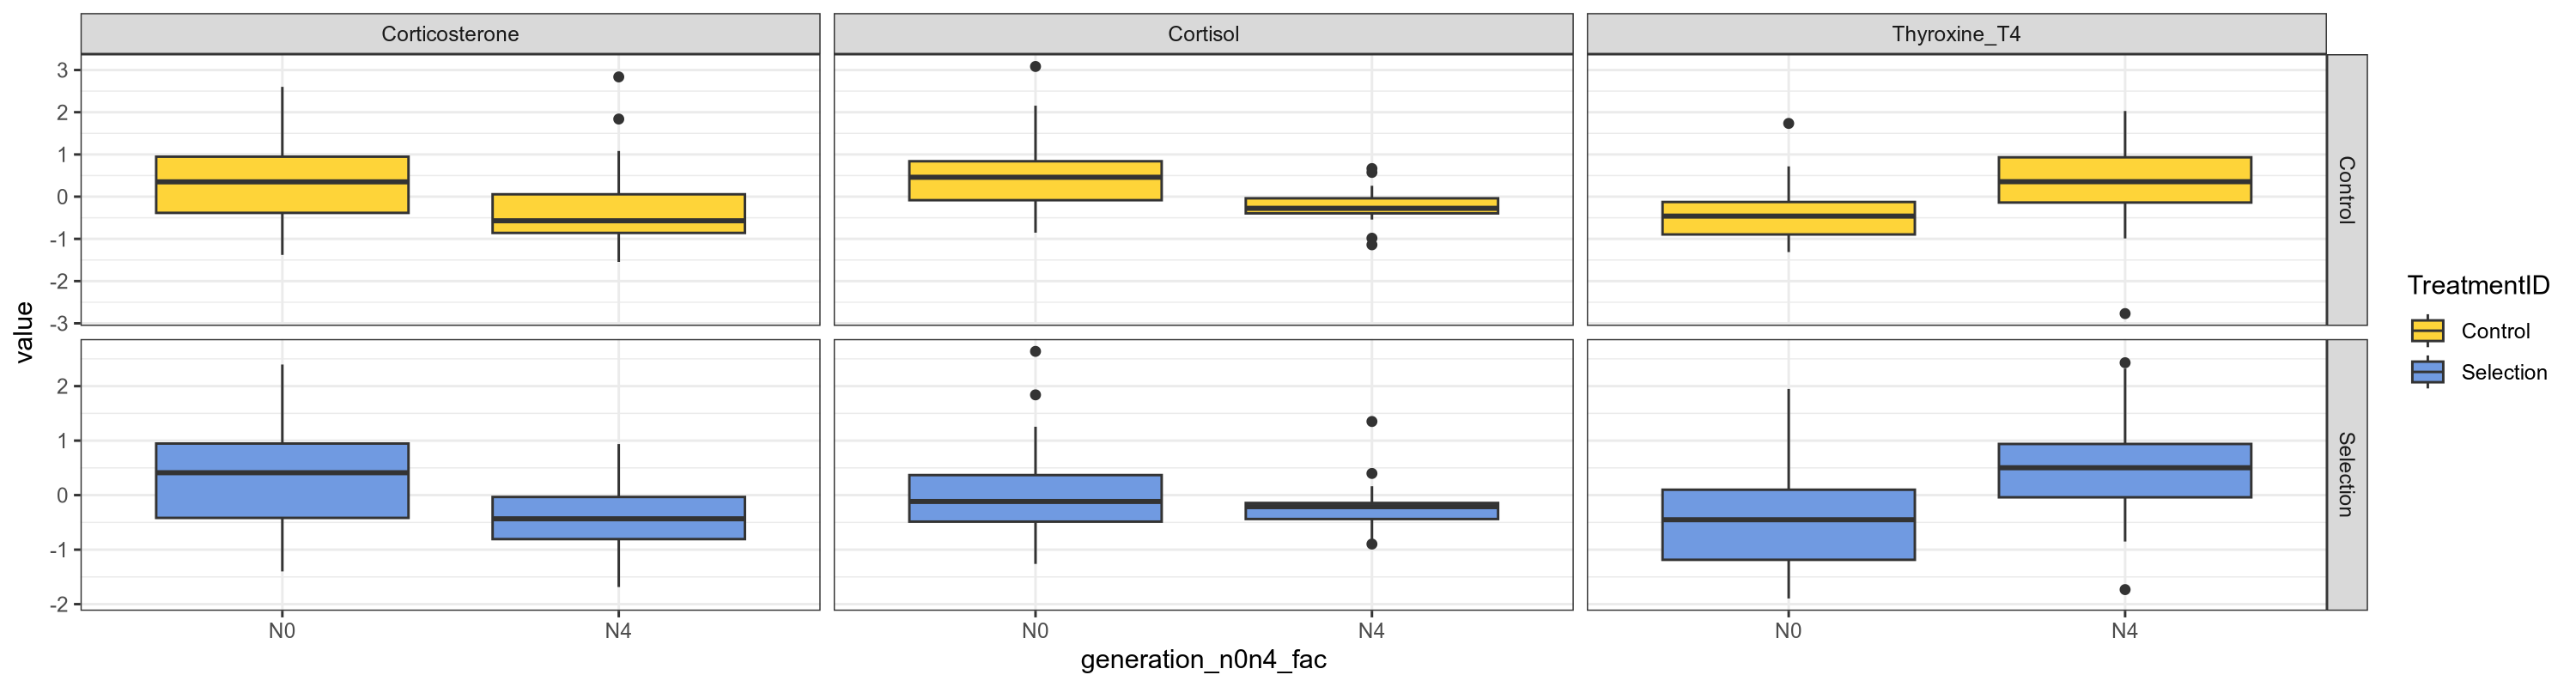

In [316]:
# draw boxplots of levels of each metabolite
#p.dims(10, 4)
p.dims(15, 4)
lm_in %>% semi_join(lm_res_signif %>% filter(term == "generation_n0n4_facN4") %>% select(Molecule_Name)) %>% 

	ggplot(aes(x = generation_n0n4_fac, y = value, fill = TreatmentID)) +
	geom_boxplot() +
	# facet across TreatmentID and Molecular_Name
	facet_grid(TreatmentID ~ Molecule_Name, scales = "free") +
	theme_bw() +
	scale_fill_simpsons()


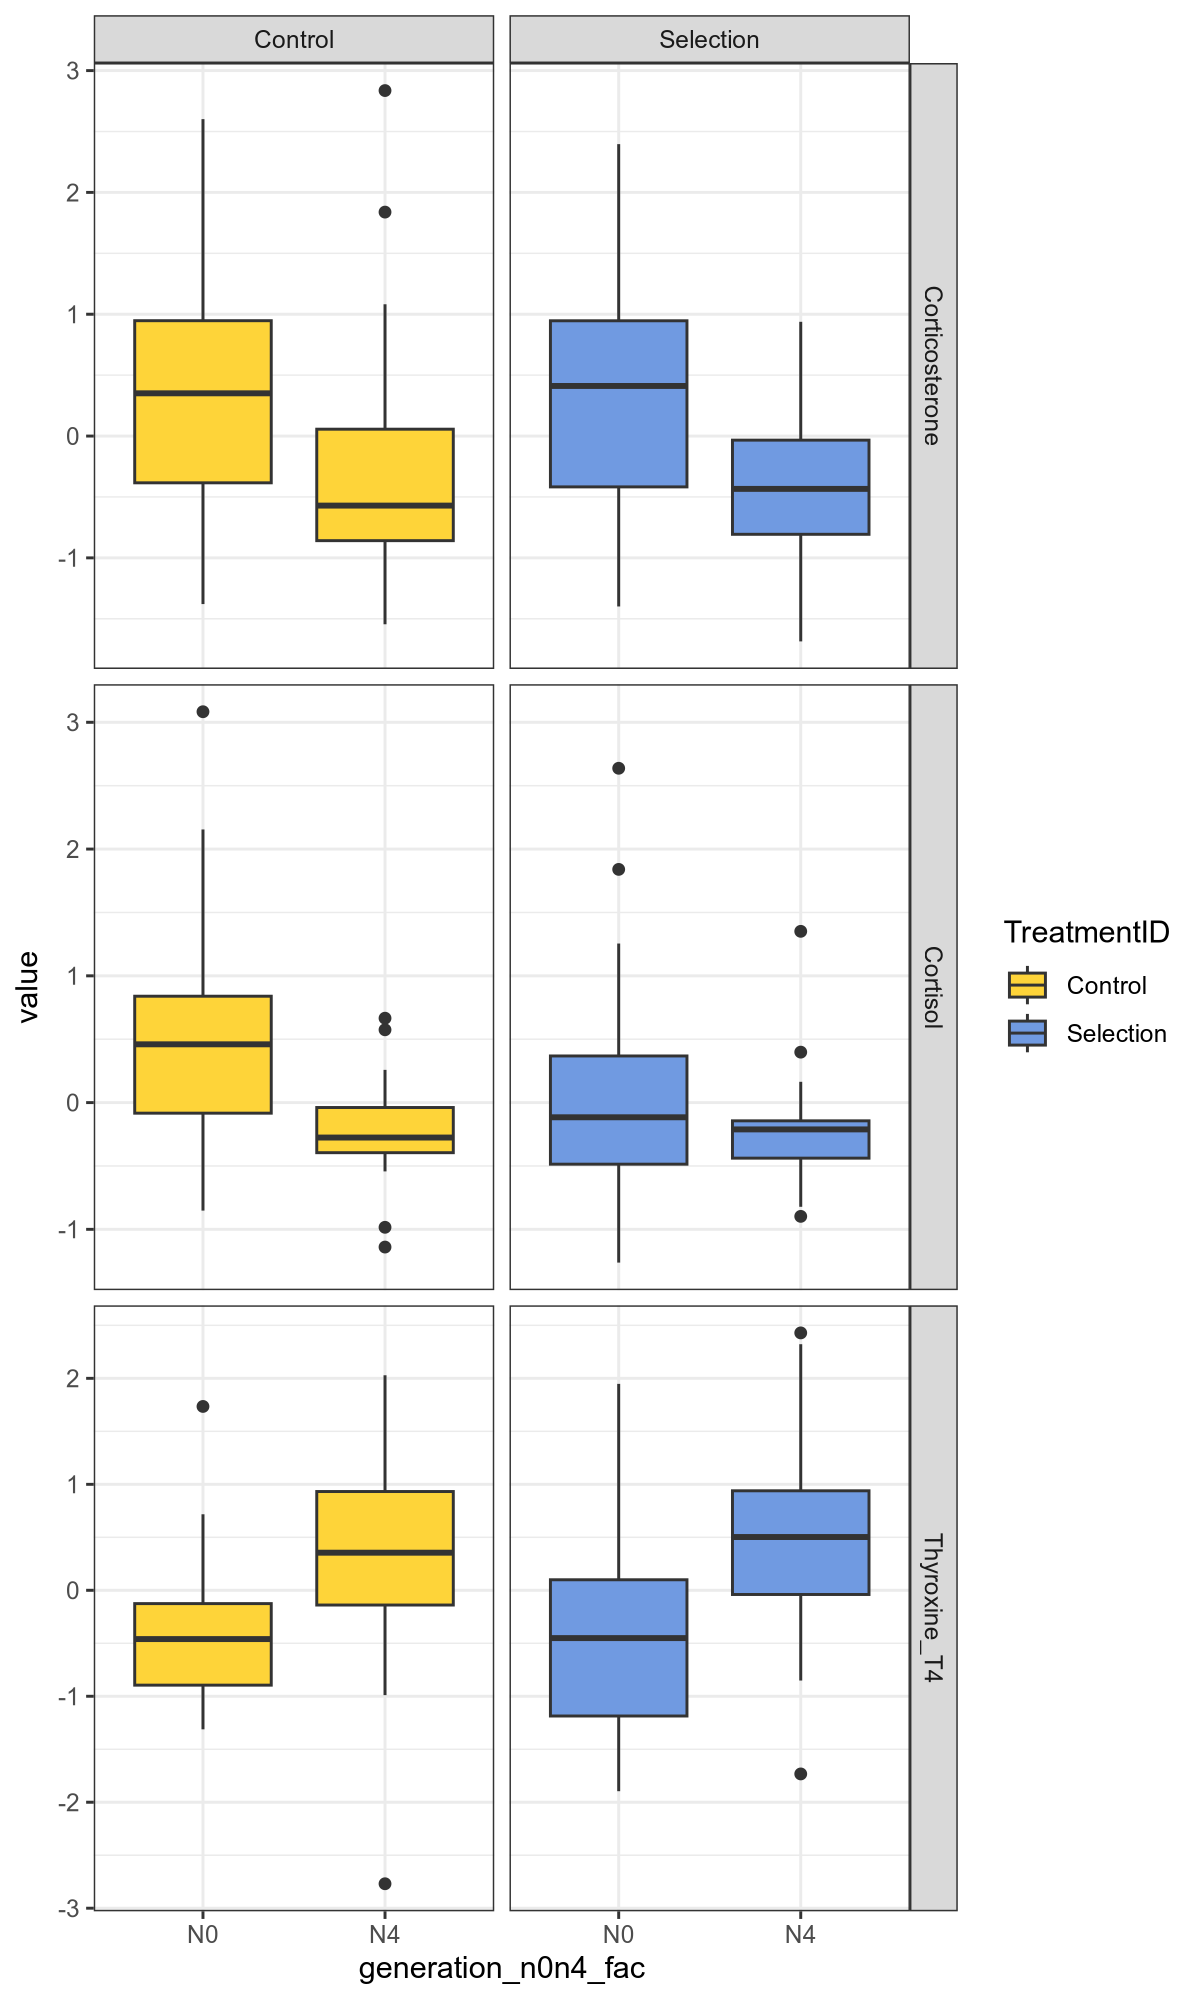

In [317]:
# flipped
p.dims(6, 10)
lm_in %>% semi_join(lm_res_signif %>% filter(term == "generation_n0n4_facN4") %>% select(Molecule_Name)) %>% 

	ggplot(aes(x = generation_n0n4_fac, y = value, fill = TreatmentID)) +
	geom_boxplot() +
	# facet across TreatmentID and Molecular_Name
	facet_grid(Molecule_Name ~ TreatmentID, scales = "free") +	
	theme_bw() +
	scale_fill_simpsons()

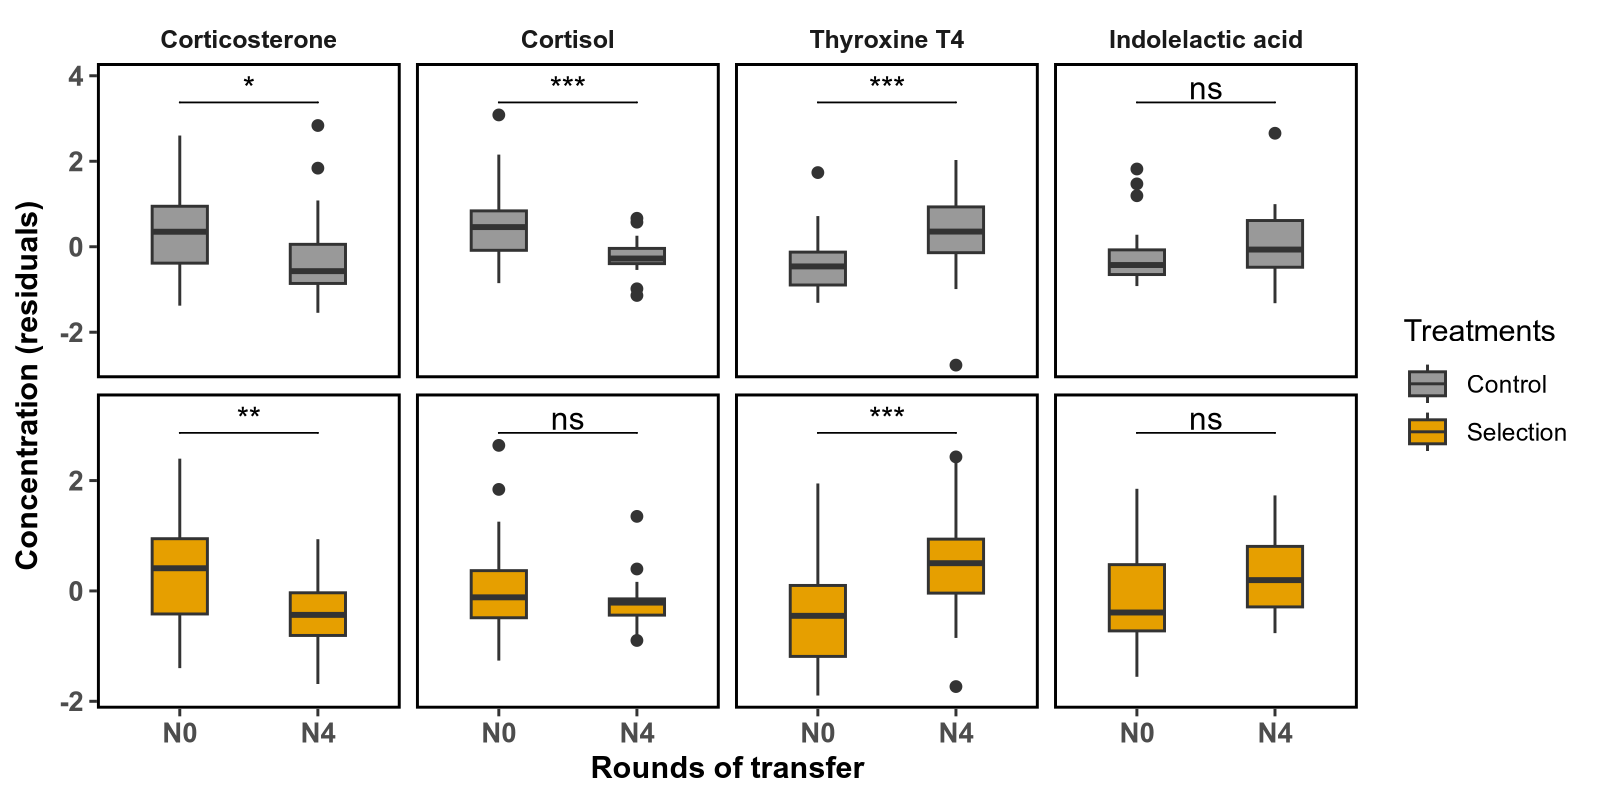

In [318]:
# Fig. 4B

# draw boxplots of levels of each metabolite significantly linked to generation
p.dims(8, 4)

lm_in %>%
	# explicitly include ILA irrespective of significance
	filter(Molecule_Name %in% union("Indolelactic_acid", lm_res_signif %>% filter(term == "generation_n0n4_facN4") %>% select(Molecule_Name) %>% pull())) %>% 
	mutate(Molecule_Name = stringi::stri_replace_all_regex(Molecule_Name,
													c("Kynurenic_acid", "Thyroxine_T4", "y_Aminobutyric_acid_GABA", "Indolelactic_acid"),
													c("Kynurenic acid", "Thyroxine T4", "GABA", "Indolelactic acid"),
													vectorize = FALSE)) %>% 
	# rearrange the Molecule_Name factor levels so that Indolelactic_acid becomes the last
	mutate(Molecule_Name = factor(Molecule_Name, levels = c("Corticosterone", "Cortisol", "Thyroxine T4", "Indolelactic acid"))) %>% 

	ggplot(aes(x = generation_n0n4_fac, y = value)) +
	geom_boxplot(aes(fill = TreatmentID), width = 0.4) +	

	# facet across TreatmentID and Molecular_Name
	facet_grid(TreatmentID ~ Molecule_Name, scales = "free") +

	labs(x = "Rounds of transfer", y = "Concentration (residuals)") + 		
	theme_bw() +
	scale_fill_manual("Treatments", values = c("Control" = "#999999", "Selection" = "#E69F00")) +
	theme(		
		panel.grid.major = element_blank(),
		panel.grid.minor = element_blank(),		
		
		strip.background = element_blank(),
		strip.text.x = element_text(size = 9, face = "bold"),
		strip.text.y = element_blank(),
		panel.border = element_rect(colour = "black", linewidth = 1),

		axis.text.x = element_text(size = 10, face = "bold"),
		axis.text.y = element_text(size = 10, face = "bold"),
		axis.title.x = element_text(size = 11, face = "bold"),
		axis.title.y = element_text(size = 11, face = "bold"),
	) +	     	
	# make max y lim 10% higher
    scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) + 
    ggpubr::stat_compare_means(comparisons = list(c("N0", "N4")),
		method = "t.test", label = "p.signif", 
		vjust = 0, size = 4, tip.length = 0, step.increase = 0.07)	



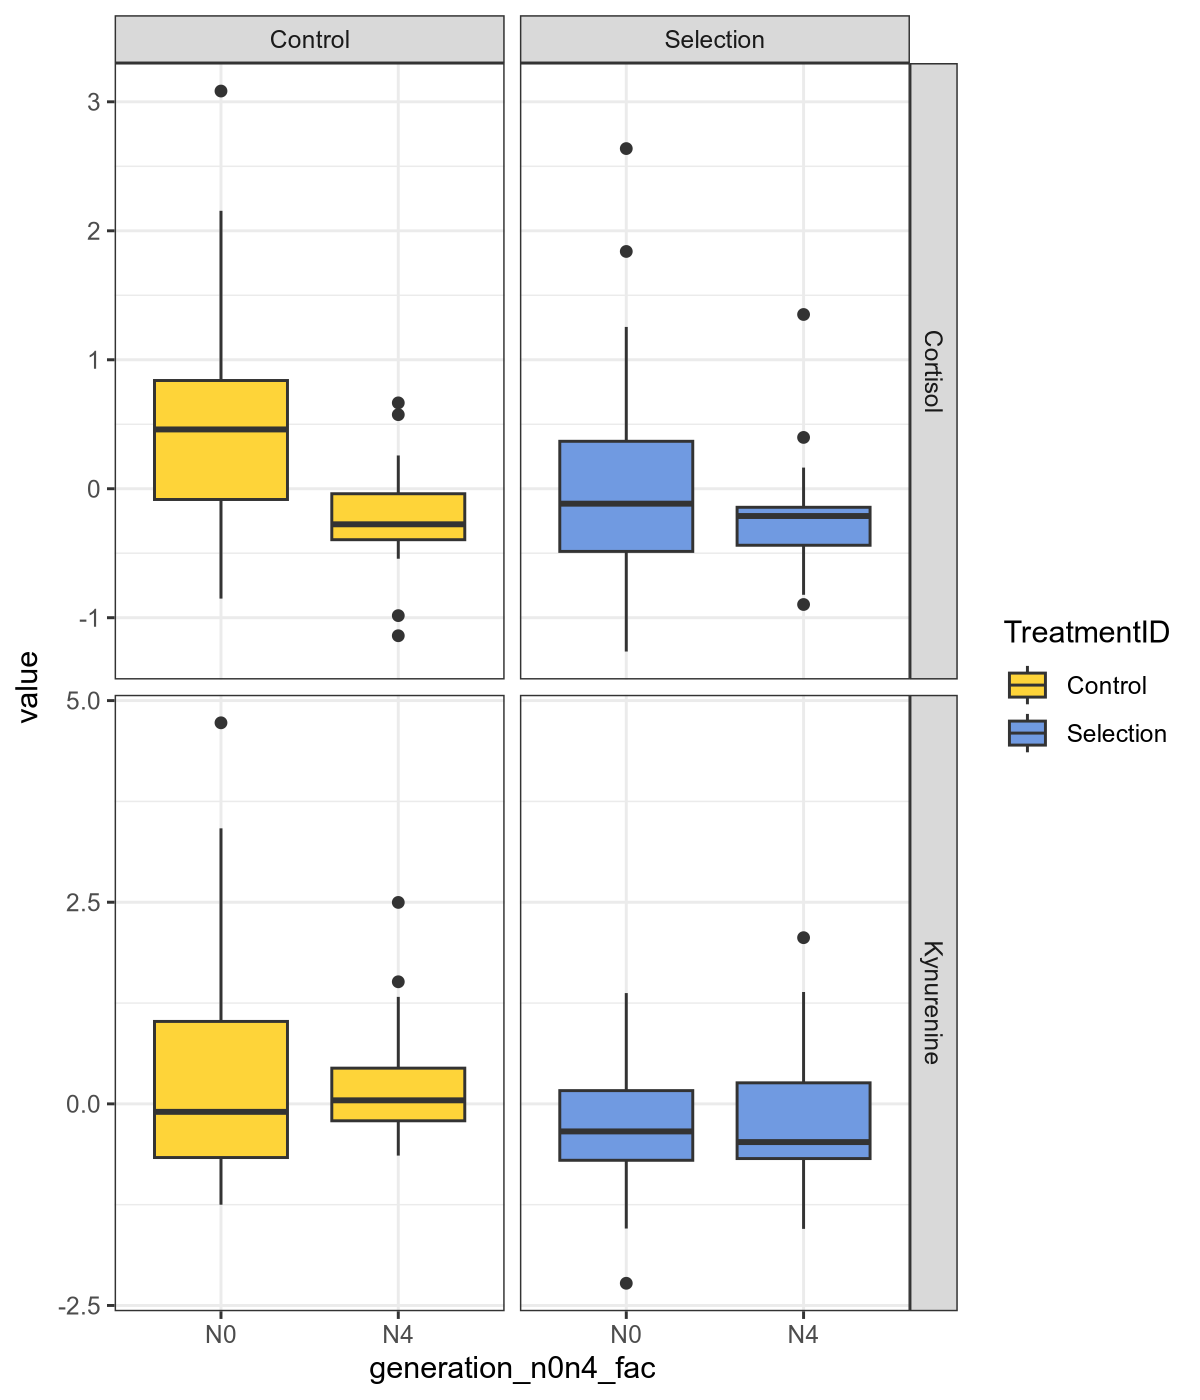

In [319]:
p.dims(6, 7)
lm_in %>% semi_join(lm_res_signif %>% filter(term == "TreatmentIDSelection") %>% select(Molecule_Name)) %>% 

	ggplot(aes(x = generation_n0n4_fac, y = value, fill = TreatmentID)) +
	geom_boxplot() +
	# facet across TreatmentID and Molecular_Name
	facet_grid(Molecule_Name ~ TreatmentID, scales = "free") +	
	theme_bw() +
	scale_fill_simpsons()

In [320]:
lm_in %>% semi_join(lm_res_signif %>% select(Molecule_Name)) %>% 
	mutate(TreatmentID = factor(TreatmentID),
	generation_n0n4_fac = factor(generation_n0n4_fac)
	)

AnimalID Molecule_Name  value       dist_trav generation_n0n4_fac replicate
1   R1N1C001 Cortisol        0.24534564 -34.94761 N0                  R1       
2   R1N1C001 Thyroxine_T4    0.02519366 -34.94761 N0                  R1       
3   R1N1C001 Kynurenine     -0.66682986 -34.94761 N0                  R1       
⋮   ⋮        ⋮              ⋮           ⋮         ⋮                   ⋮        
471 R4N5T320 Kynurenine     0.04035511  22.95042  N4                  R4       
472 R4N5T320 Corticosterone 0.53018935  22.95042  N4                  R4       
    BWi34 TreatmentID
1   6.71  Control    
2   6.71  Control    
3   6.71  Control    
⋮   ⋮     ⋮          
471 12.87 Selection  
472 12.87 Selection

In [321]:
lm_res_signif %>% select(Molecule_Name, term)

Molecule_Name  term                 
1 Kynurenine     TreatmentIDSelection 
2 Cortisol       TreatmentIDSelection 
3 Cortisol       generation_n0n4_facN4
4 Thyroxine_T4   generation_n0n4_facN4
5 Corticosterone generation_n0n4_facN4

In [322]:
lm_in %>% semi_join(lm_res_signif %>% filter(term == "BWi34") %>% select(Molecule_Name))

AnimalID Molecule_Name value dist_trav generation_n0n4_fac replicate BWi34
     TreatmentID

## Non-microbiome stats

In [323]:
Master_data1 = read.table(Master_data1_file, header = TRUE)

In [324]:
#Add residuals of distance traveled
#The body weight (3 week old) of the starting donor is missing. Thus, N1 generation is excluded to account for body weight on distance traveled.
Master_data1_noN1 = Master_data1[!Master_data1$generation == "N1",]

#Log transformed, centered, and scaled
#recipients
Master_data1_noN1$PedMeters_ALL_log = scale(log(Master_data1_noN1$PedMeters_ALL),center = TRUE, scale = TRUE) 
Master_data1_noN1$BW_3_4w_log = scale(log(Master_data1_noN1$BW_3_4w), center = TRUE, scale = TRUE)
#donors
Master_data1_noN1$PedMeters_ALL_donor_log = scale(log(Master_data1_noN1$PedMeters_ALL_donor),center = TRUE, scale = TRUE) 
Master_data1_noN1$BW_3_4w_donor_log = scale(log(Master_data1_noN1$BW_3_4w_donor), center = TRUE, scale = TRUE)


Warning message in cor.test.default(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”


$label_all
[1] "        All\n        rho = 0.19\n        p < 0.001"

$label_T
[1] "        Selection\n        rho = 0.156\n        p = 0.081"

$label_C
[1] "        Control\n        rho = 0.241\n        p = 0.007"

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.”
Warning message in annotate("text", x = 420, y = 500, label = labels_noN1$label_all, :
“Ignoring unknown parameters: `label.size`”
Warning message in annotate("text", x = 420, y = 330, label = labels_noN1$label_T, :
“Ignoring unknown parameters: `label.size`”
Warning message in annotate("text", x = 420, y = 160, label = labels_noN1$label_C, :
“Ignoring unknown parameters: `label.size`”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 1 row containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


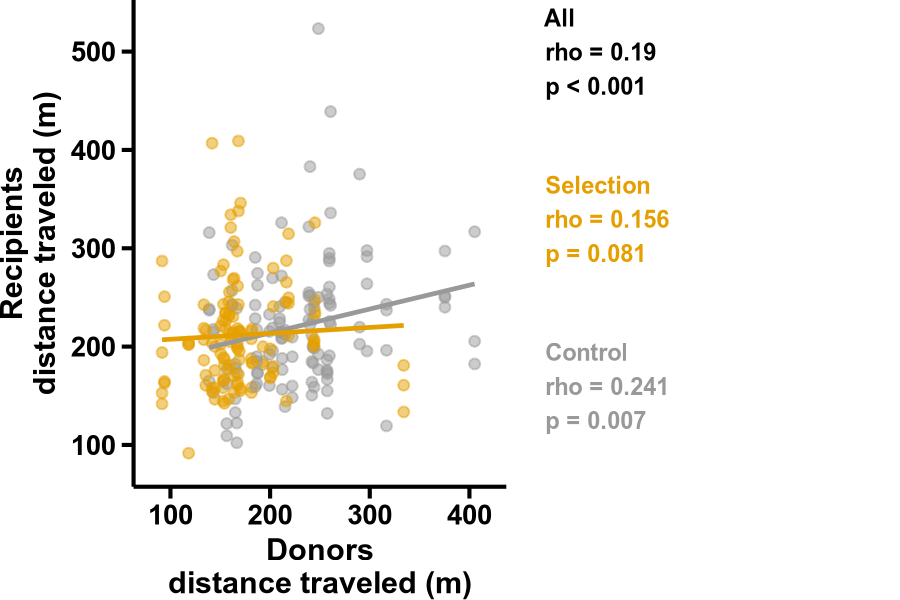

In [325]:
p.dims(4.5, 3)

# prepare the 3 labels
labels_noN1 = Master_data1_noN1 %>% 
    mutate( rho_all = round(cor.test(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman")$estimate, 2),
            p_all = round(cor.test(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman")$p.value, 2),                
            rho_T = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == "T"], method = "spearman")$estimate, 3),
            p_T = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == "T"], method = "spearman")$p.value, 3),
            rho_C = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == "C"], method = "spearman")$estimate, 3),
            p_C = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == "C"], method = "spearman")$p.value, 3)              
        ) %>% 
        select(rho_all, p_all, rho_T, p_T, rho_C, p_C) %>% distinct() %>%
        # if p == 0 then give it as p < 0.001
        mutate(p_all = ifelse(p_all == 0, "< 0.001", paste0("= ", p_all))) %>% 
        mutate(p_T = ifelse(p_T == 0, "< 0.001", paste0("= ", p_T))) %>% 
        mutate(p_C = ifelse(p_C == 0, "< 0.001", paste0("= ", p_C))) %>%
        mutate(label_all = paste0("        All\n        rho = ", rho_all, "\n        p ", p_all)) %>%        
        mutate(label_T = paste0("        Selection\n        rho = ", rho_T, "\n        p ", p_T)) %>%        
        mutate(label_C = paste0("        Control\n        rho = ", rho_C, "\n        p ", p_C)) %>%
        select(label_all, label_T, label_C) %>%
        as.list()
labels_noN1

ggplot(data = Master_data1_noN1, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
            geom_point(alpha = 0.5, size = 1.5) +
            ylim(80,530) +
            xlim(80,420) +
            
            labs(x = "Donors\ndistance traveled (m)", y = "Recipients\ndistance traveled (m)") +  
            geom_smooth(method = lm, size = 0.8, se=FALSE, fullrange=FALSE) + 
            scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+    
            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
                axis.line = element_line(colour = "black", size = 0.7), 
                axis.ticks = element_line(color = "black", size = 0.7),
                axis.ticks.length = unit(.15, "cm"), 
                axis.title = element_text(face="bold", size = 11),
                axis.text = element_text(face="bold", size = 10, colour="black"),
        
                #legend.key.size = unit(1, 'cm'),
                legend.key = element_blank(), 
                legend.title = element_blank(),
                #legend.text = element_text(face="bold", size = 10),
                plot.margin = unit(c(0, 5, 0, 0),"cm")
                ) +
                guides(color = FALSE) +                
                annotate("text", x = 420, y = 500, label = labels_noN1$label_all, size = 3, label.size = 0, color = "black", fontface = "bold", hjust = 0) +
                annotate("text", x = 420, y = 330, label = labels_noN1$label_T, size = 3, label.size = 0, color = "#E69F00", fontface = "bold", hjust = 0) +
                annotate("text", x = 420, y = 160, label = labels_noN1$label_C, size = 3, label.size = 0, color = "#999999", fontface = "bold", hjust = 0) +
                coord_cartesian(clip = "off") # Allow annotations to overflow the panel


Warning message in cor.test.default(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == :
“Cannot compute exact p-value with ties”
Warning message in annotate("text", x = 350, y = 510, label = labels_TC$label_C, :
“Ignoring unknown parameters: `labe

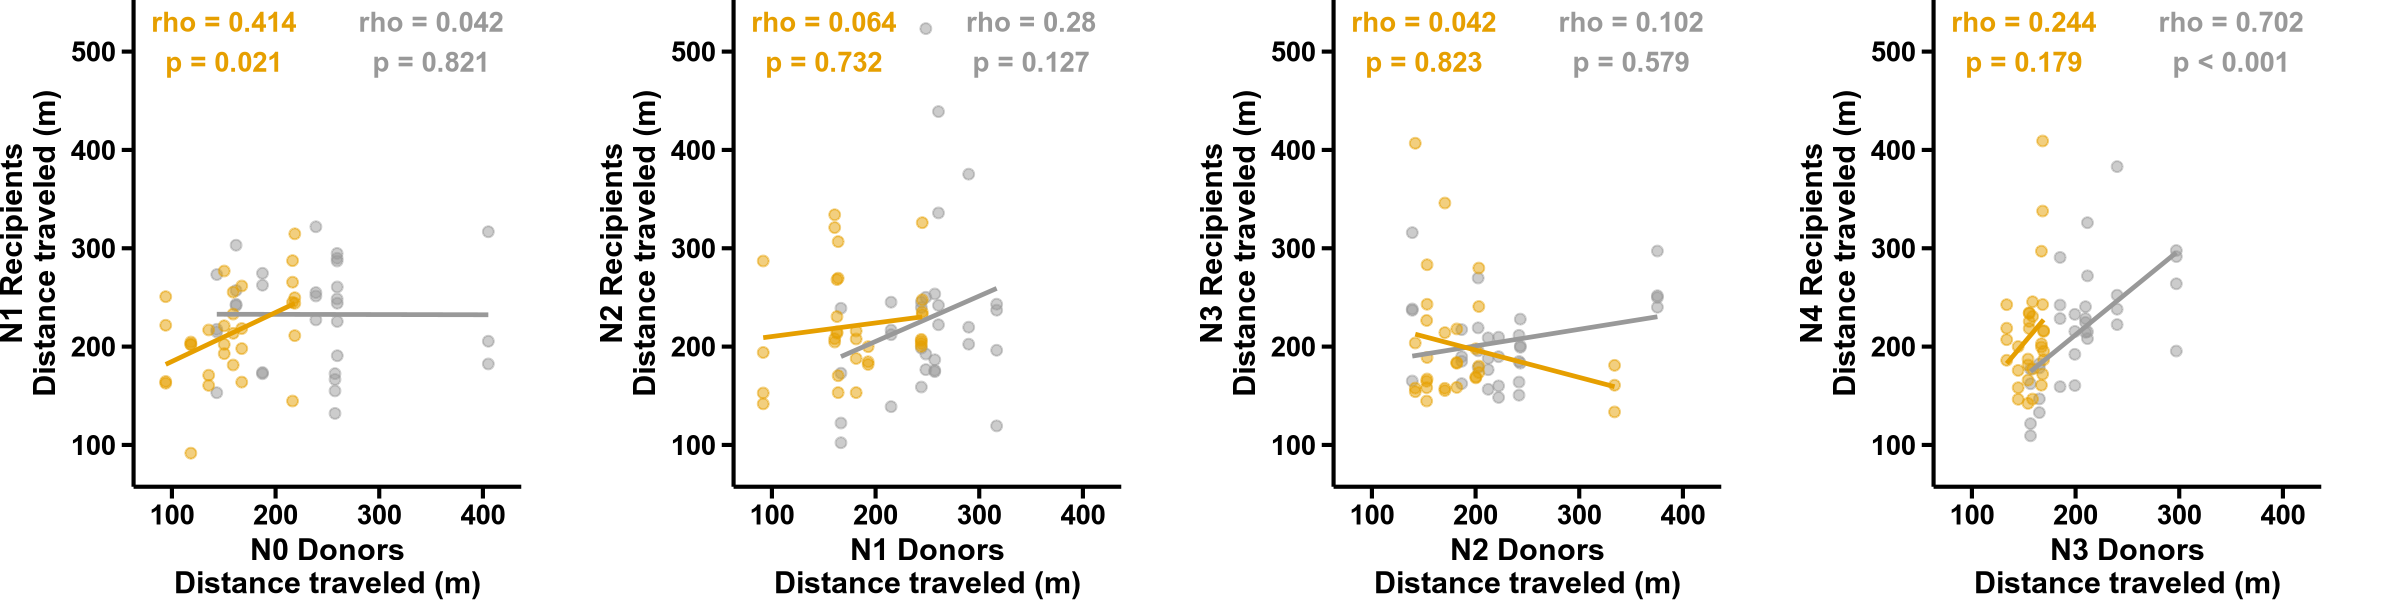

In [326]:
# init an empty ggplot array
plot = ggplot()

for(i in 2:5) {
    a = paste0("N", i-1)
    b = paste0("N", i)
    tmp = Master_data1_noN1 %>% filter(generation == b) %>%        
        mutate(rho = round(cor.test(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman")$estimate, 2),
                p = round(cor.test(PedMeters_ALL_donor, PedMeters_ALL, method = "spearman")$p.value, 2),                
                rho_T = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == "T"], method = "spearman")$estimate, 3),
                p_T = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "T"], PedMeters_ALL[.$TreatmentID == "T"], method = "spearman")$p.value, 3),
                rho_C = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == "C"], method = "spearman")$estimate, 3),
                p_C = round(cor.test(PedMeters_ALL_donor[.$TreatmentID == "C"], PedMeters_ALL[.$TreatmentID == "C"], method = "spearman")$p.value, 3)              
        )
    # prepare the 2 labels
    labels_TC = tmp %>% select(rho_T, p_T, rho_C, p_C) %>% distinct() %>%
        # if p == 0 then give it as p < 0.001
        mutate(p_T = ifelse(p_T == 0, "< 0.001", paste0("= ", p_T))) %>% 
        mutate(p_C = ifelse(p_C == 0, "< 0.001", paste0("= ", p_C))) %>%
        mutate(label_T = paste0("rho = ", rho_T, "\np ", p_T)) %>%        
        mutate(label_C = paste0("rho = ", rho_C, "\np ", p_C)) %>%
        select(label_T, label_C) %>%
        as.list()
    
    plot[[i]] =
        ggplot(data = tmp, aes(x = PedMeters_ALL_donor, y = PedMeters_ALL, color = TreatmentID)) +
            geom_point(alpha = 0.5, size = 1.5) +
            ylim(80,530) +
            xlim(80,420) +
            # ! This is where we change from N1..N5 to N0..N4:
            labs(x = paste0("N", i-2, " Donors\nDistance traveled (m)"), y = paste0("N", i-1, " Recipients\nDistance traveled (m)")) +
            geom_smooth(method = lm, size = 0.8, se=FALSE, fullrange=FALSE) + 
            scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+    
            theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),panel.background = element_blank(), 
                axis.line = element_line(colour = "black", size = 0.7), 
                axis.ticks = element_line(color = "black", size = 0.7),
                axis.ticks.length = unit(.15, "cm"), 
                axis.title = element_text(face="bold", size = 11),
                axis.text = element_text(face="bold", size = 10, colour="black"),
                legend.key = element_blank(), 
                legend.title = element_blank(),
                plot.margin = unit(c(0, 1, 0, 0),"cm")
                ) +
                guides(color = FALSE) +
                annotate("text", x = 350, y = 510, label = labels_TC$label_C, size = 3.5, label.size = 0, color = "#999999", fontface = "bold", hjust = 0.5, vjust = 0.5) +
                annotate("text", x = 150, y = 510, label = labels_TC$label_T, size = 3.5, label.size = 0, color = "#E69F00", fontface = "bold", hjust = 0.5, vjust = 0.5) 
}
p.dims(12, 3)
ggpubr::ggarrange(plot[[2]], plot[[3]], plot[[4]], plot[[5]], ncol = 4, nrow = 1)

In [327]:
labels_TC

$label_T
[1] "rho = 0.244\np = 0.179"

$label_C
[1] "rho = 0.702\np < 0.001"

## PCoA exploratory (Species level)

### Fig. 3 A-C refreshed

In [328]:
bracken_perc_mat = 	
	# explicitly Species-level!
	br_perc$Species %>% select(name, Sample, Abundance) %>% 
	pivot_wider(names_from=Sample, values_from=Abundance, values_fill=0) %>% 
	column_to_rownames('name')
# transpose bracken_perc_mat
bracken_perc_mat = t(bracken_perc_mat)
bracken_perc_mat

UBA5026_sp910586425 Paramuribaculum_sp910577465
R1N1C001 0.017376767         0.0006838799               
R1N1C003 0.022147702         0.0091984407               
R1N1C005 0.008103502         0.0093233837               
⋮        ⋮                   ⋮                          
R4N5T318 0.01424611          0.01853014                 
R4N5T320 0.01947192          0.00411906                 
         Eubacterium_J_sp910577225 Paramuribaculum_sp910579185
R1N1C001 0.01765654                0.02325192                 
R1N1C003 0.01272600                0.01920063                 
R1N1C005 0.01507426                0.02030232                 
⋮        ⋮                         ⋮                          
R4N5T318 0.008908068               0.05562442                 
R4N5T320 0.011046569               0.03154825                 
         Angelakisella_sp910585525 X14-2_sp009774455 Muribaculum_sp001701065
R1N1C001 0.02834993                0.014983187       0.001585358            
R1N1C003 0.02196909                0.009332399       0.016610776            
R1N1C005 0.01995378                0.011588879       0.020302322            
⋮        ⋮                         ⋮                 ⋮                      
R4N5T318 0.02244017                0.004862037       0.03961030             
R4N5T320 0.02171868                0.007582814       0.02003361             
         Butyribacter_sp002361175 Lactobacillus_johnsonii X1XD42-69_sp910586725
R1N1C001 0.007553765              0.007491594             0.007584850          
R1N1C003 0.007144420              0.010582672             0.006474631          
R1N1C005 0.005750872              0.053239135             0.002875436          
⋮        ⋮                        ⋮                       ⋮                    
R4N5T318 0.003400026              0.012036092             0.003298025          
R4N5T320 0.003276525              0.004025445             0.003557370          
         ⋯ Sporofaciens_sp011960625 COE1_sp910588595 Bacteroides_sp910578895
R1N1C001 ⋯ 0.007988961              0.03907441       0.006030578            
R1N1C003 ⋯ 0.007323030              0.01750383       2.171903675            
R1N1C005 ⋯ 0.008626308              0.01829823       0.043392945            
⋮        ⋱ ⋮                        ⋮                ⋮                      
R4N5T318 ⋯ 0.003604028              0.003808029      0.20821759             
R4N5T320 ⋯ 0.007676429              0.006646664      0.04446712             
         CAG-317_sp910578495 DSM-108975_sp014982715 Butyribacter_sp910588655
R1N1C001 0.009294550         0.001087991            0.14317959              
R1N1C003 0.006697894         0.000000000            0.11605217              
R1N1C005 0.008887712         0.004443856            0.08373618              
⋮        ⋮                   ⋮                      ⋮                       
R4N5T318 0.007038054         0.002380018            0.05973846              
R4N5T320 0.011608259         0.003182910            0.04306290              
         Acutalibacter_sp910574935 Cryptobacteroides_sp009774765
R1N1C001 0.03963395                0.001056905                  
R1N1C003 0.03335551                0.006206715                  
R1N1C005 0.04191166                0.006186544                  
⋮        ⋮                         ⋮                            
R4N5T318 0.02533019                0.002788021                  
R4N5T320 0.03323332                0.001778685                  
         Dysosmobacter_sp009774015 Pelethomonas_sp910579965
R1N1C001 0.6455826                 3.849778                
R1N1C003 0.7805725                 1.963867                
R1N1C005 0.9864489                 1.252993                
⋮        ⋮                         ⋮                       
R4N5T318 0.1898235                 4.011011                
R4N5T320 0.2856193                 3.645929

In [329]:
bracken_perc_mat_n310 = bracken_perc_mat[memeta_2_n310 %>% select(AnimalID) %>% pull(),]
nrow(bracken_perc_mat_n310)
test_that("bracken_perc_mat_n310", expect_equal(nrow(bracken_perc_mat_n310), 310))

[1] 310

Test passed 🥇


In [330]:
# there are a few samples in bracken_perc_mat that are not in memeta_2, but that's OK for this Fig. coming prior to the NB analysis 
setdiff(rownames(bracken_perc_mat_n310), 
    memeta_2 %>% select(AnimalID) %>% pull())

[1] "R1N4T182" "R2N1C023" "R3N3C161" "R3N3T172" "R4N3C199" "R4N4T268" "R4N5T316"

In [331]:
bet_div_n310 = bracken_perc_mat_n310 %>% vegdist(index = "bray")
pcoa_res = ape::pcoa(bet_div_n310)

In [332]:
pve = round(pcoa_res$values$Relative_eig[1:3] * 100, 1) 
# concatenate those values to PC1 and PC2
pve = paste0("PCoA", 1:3, " (", pve, "%)")
pve

[1] "PCoA1 (27.2%)" "PCoA2 (10.9%)" "PCoA3 (9.1%)"

In [333]:
pcoa <- cmdscale(k = 3, bet_div_n310, eig = TRUE, add = TRUE)

#convert pcoa results into data frame that can be plotted
pcoa_2 <- as.data.frame(pcoa$points) %>% 
	rename(PCo1 = V1, PCo2 = V2, PCo3 = V3) %>%
	mutate(Sample = rownames(pcoa$points))


In [334]:
pcoa_2 = pcoa_2 %>% inner_join(memeta_2_n310, by = c("Sample" = "AnimalID"))	
pcoa_2

PCo1       PCo2         PCo3        Sample   TreatmentID replicate
1   -0.2115305 0.3201778     0.01647785 R1N1C001 Control     R1       
2    0.1108174 0.2896836    -0.03915924 R1N1C003 Control     R1       
3    0.1127340 0.1841698    -0.07505711 R1N1C005 Control     R1       
⋮   ⋮          ⋮            ⋮           ⋮        ⋮           ⋮        
309  0.2678494 -0.210320366  0.08841900 R4N5T318 Selection   R4       
310 -0.1188576  0.005518973 -0.07210721 R4N5T320 Selection   R4       
    generation AnimalID_of_donor Date_inoculated Date_dissected ⋯
1   N0         TSU201            2020_09_15      2020_09_30     ⋯
2   N0         TSU201            2020_09_15      2020_09_30     ⋯
3   N0         TSU201            2020_09_15      2020_09_30     ⋯
⋮   ⋮          ⋮                 ⋮               ⋮              ⋱
309 N4         R4N4T272          2020_12_02      2020_12_18     ⋯
310 N4         R4N4T272          2020_12_02      2020_12_18     ⋯
    Indole_3_propionic_acid Cortisol   Tryptophan  Thyroxine_T4 Kynurenine
1   -0.031249205            0.9315167   1.61203543  0.1521998   -0.5238582
2   -0.008064615            1.6121159   0.80758734  0.1849976    1.9201335
3    3.046987924            1.5380944  -0.06489358 -0.6651584    0.5738817
⋮   ⋮                       ⋮          ⋮           ⋮            ⋮         
309 -1.035441               -0.7837448 -1.83816     1.0548977   -1.1236064
310 -1.263215               -0.9124141 -1.54833    -0.3827954   -0.2368544
    Serotonin   Corticosterone Glutamic_acid Kynurenic_acid
1    0.8309755  0.5748988      -1.2209654     0.13882065   
2   -0.4399006  2.4186384       2.4163481     0.08235747   
3   -0.7711080  1.6997377       0.8090151    -0.05657939   
⋮   ⋮           ⋮              ⋮             ⋮             
309 -0.54182161 -1.1214938     -1.2024742    -0.3239339    
310  0.03311371  0.2530819     -0.9848835    -0.1726882    
    y_Aminobutyric_acid_GABA
1   1.506148                
2   0.649170                
3   1.350811                
⋮   ⋮                       
309 -0.9756470              
310 -0.5943937

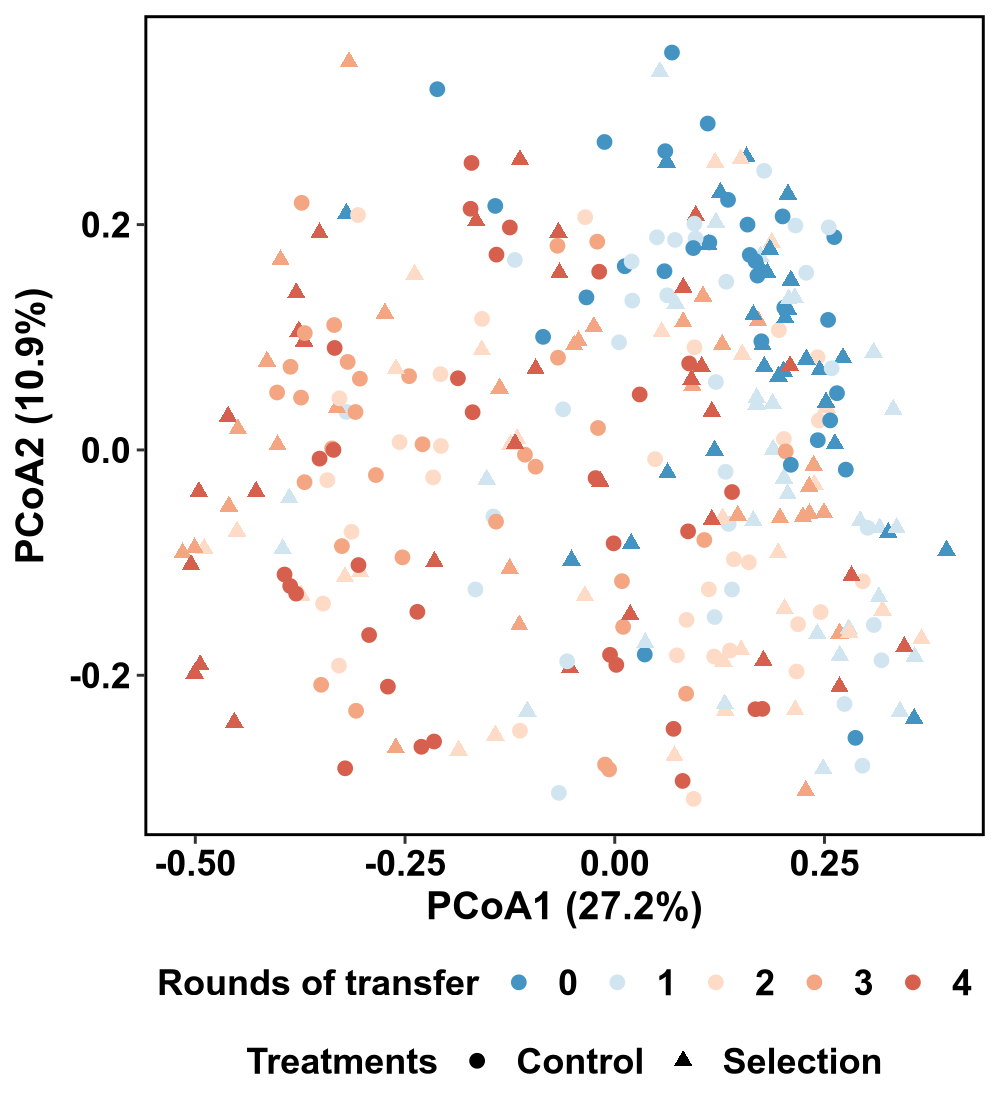

In [335]:
# Fig. 3A
p.dims(5, 5.5)
ggplot(pcoa_2, aes(x = PCo1, y = PCo2, color = as.character(Generation_num), shape = TreatmentID)) + 
	geom_point(size = 2) +    	
	xlab(pve[1]) +
	ylab(pve[2]) +   
	theme_bw() + 		
	theme(		
		panel.grid.major = element_blank(),
		panel.grid.minor = element_blank(),		
		strip.background = element_blank(),
		strip.text.x = element_blank(),
		panel.border = element_rect(colour = "black", linewidth = 1),

		axis.text.x = element_text(size = 13, face = "bold", color = "black"),
		axis.text.y = element_text(size = 13, face = "bold", color = "black"),
		axis.title.x = element_text(size = 14, face = "bold", color = "black"),
		axis.title.y = element_text(size = 14, face = "bold", color = "black"),

		legend.text = element_text(size = 13, face = "bold"),
		legend.position = "bottom",
		# ensure legends are stacked
		legend.box = "vertical",
		# make padding between legends smaller
		legend.margin = margin(0, 0, 0, 0, "cm"),

		# make legend titles bold
		legend.title = element_text(face = "bold", size = 13)		
	) +
	scale_shape_manual("Treatments", values=c(19, 17)) + 
	scale_color_manual("Rounds of transfer", values = c("0" = "#4393C3", "1" = "#D1E5F0", "2" = "#FDDBC7", "3" = "#F4A582", "4" = "#D6604D"))


In [336]:
pairs_to_plot = 
    bet_div_n310 %>% 
    as.matrix() %>% 
    as.data.frame() %>% 
    rownames_to_column(var = "SampleA") %>%    
    pivot_longer(cols = -SampleA, names_to = "SampleB", values_to = "dist") %>% 
    # we don't need the diagonal
    filter(SampleA != SampleB) %>% 
    # join the meta for the SampleA
    inner_join(memeta_2_n310 %>% select(AnimalID, Generation_num, TreatmentID), by = c("SampleA" = "AnimalID")) %>%
    rename(Generation_num_A = Generation_num, TreatmentID_A = TreatmentID) %>%
    # same for B
    inner_join(memeta_2_n310 %>% select(AnimalID, Generation_num, TreatmentID), by = c("SampleB" = "AnimalID")) %>%
    rename(Generation_num_B = Generation_num, TreatmentID_B = TreatmentID) %>%
    # leave only the within-Generation pairs
    filter(Generation_num_A == Generation_num_B) %>%
    mutate(Generation_num = Generation_num_A) %>%
    select(-Generation_num_A, -Generation_num_B) %>%
    # type = within Control, within Selection, between Control and Selection
    mutate(type = case_when(
        TreatmentID_A == "Control" & TreatmentID_B == "Control" ~ "Within Control",
        TreatmentID_A == "Selection" & TreatmentID_B == "Selection" ~ "Within Selection",
        TRUE ~ "Between Control and Selection"
    )) %>% 
    # arrenge the types
    mutate(type = factor(type, levels = c("Within Control", "Within Selection", "Between Control and Selection"))
)
pairs_to_plot

SampleA  SampleB  dist      TreatmentID_A TreatmentID_B Generation_num
1     R1N1C003 R1N1C001 0.3204646 Control       Control       0             
2     R1N1C005 R1N1C001 0.4158310 Control       Control       0             
3     R1N1C007 R1N1C001 0.3864317 Control       Control       0             
⋮     ⋮        ⋮        ⋮         ⋮             ⋮             ⋮             
18923 R4N5T316 R4N5T320 0.2426691 Selection     Selection     4             
18924 R4N5T318 R4N5T320 0.3014988 Selection     Selection     4             
      type            
1     Within Control  
2     Within Control  
3     Within Control  
⋮     ⋮               
18923 Within Selection
18924 Within Selection

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


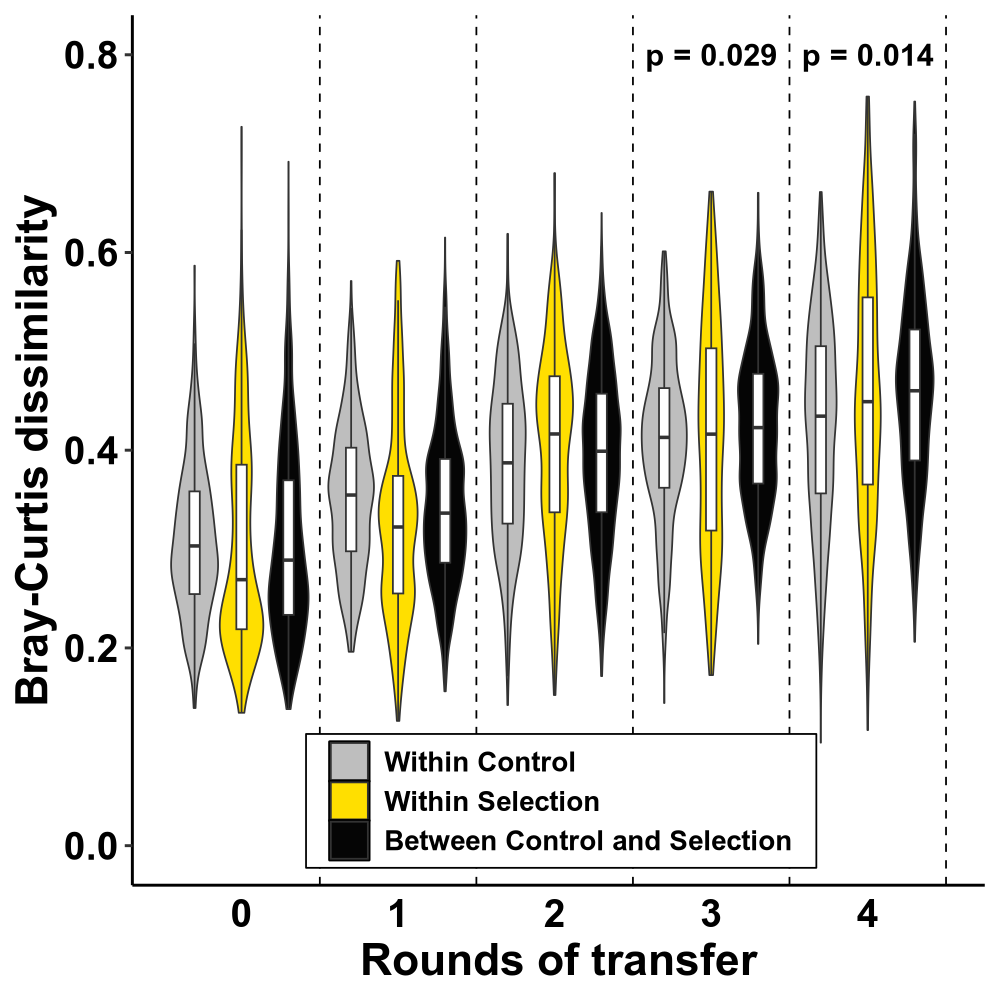

In [337]:
p.dims(5, 5)
ggplot(pairs_to_plot, aes(x = Generation_num, y = dist, fill = type)) + 
  geom_violin(aes(group = interaction(Generation_num, type)), trim=TRUE, size = 0.3) +  
  geom_boxplot(aes(group = interaction(Generation_num, type)), width=0.2, fill="white", outlier.shape = NA, position = position_dodge(0.9), size = 0.3) +
  # vertical dashed lines between the Generations
  geom_vline(xintercept = c(0.5, 1.5, 2.5, 3.5, 4.5), linetype = "dashed", color = "black", size = 0.3) +
  # set Y min = 0
  coord_cartesian(ylim = c(0, 0.8)) +
  theme_classic() +   
  scale_fill_manual(values = c("Within Control" = "gray", "Within Selection" = "#ffdf00", "Between Control and Selection" = "grey2")) +
  theme(   

		axis.text.x = element_text(size = 14, face = "bold", color = "black"),
		axis.text.y = element_text(size = 14, face = "bold", color = "black"),
		axis.title.x = element_text(size = 16, face = "bold", color = "black"),
		axis.title.y = element_text(size = 16, face = "bold", color = "black"),

  	legend.text = element_text(size = 10, face = "bold"),
		#legend.position = "bottom",

		# make legend titles bold
		#legend.title = element_text(face = "bold"),
    # frame around the legend
    legend.key = element_rect(color = "black", size = 0.5),
    # plot legend over the plot
    legend.justification = c(1.3, 0),
    legend.position = c(0.982, 0.02),
    # make a border around the legend box
    legend.box.margin = margin(0, 0, 0, 0, "cm"),
    legend.background = element_rect(color = "black", size = 0.3),
    # make padding between legends smaller
    legend.margin = margin(0.1, 0.3, 0.1, 0.3, "cm"),
    # make top legend margin smaller
    # disable legend title
    legend.title = element_blank(),
    # remove legend key size
    legend.key.size = unit(0.5, "cm"),
    # remove legend key size
    legend.key.width = unit(0.5, "cm"),
    # remove legend key size
    legend.key.height = unit(0.5, "cm"),
    # remove legend key size
    legend.spacing.x = unit(0.2, "cm"),
    # remove legend key size
    legend.spacing.y = unit(0.05, "cm"),
    # disable X ticks
    axis.ticks.x = element_blank()

  ) + guides(fill = guide_legend(ncol = 1)) +
  # axes names
  labs(x = "Rounds of transfer", y = "Bray-Curtis dissimilarity") +
  # add canned labels
  annotate("text", x = 3, y = 0.8, label = "p = 0.029", size = 3.9, fontface = "bold", color ="black") +
  annotate("text", x = 4, y = 0.8, label = "p = 0.014", size = 3.9, fontface = "bold", color ="black")  

In [338]:
# Fig. 3A and similar suppl.
alpha_div = alpha_div %>%     
    inner_join(memeta_2_n310 %>% select(AnimalID, Generation_num, TreatmentID), by = "AnimalID")
alpha_div

AnimalID alpha_measure     value       Generation_num TreatmentID
1   R1N1C001 shannon_entropy      6.803308 0              Control    
2   R1N1C001 observed_features 2156.000000 0              Control    
3   R1N1C001 faith_pd           363.366260 0              Control    
⋮   ⋮        ⋮                 ⋮           ⋮              ⋮          
926 R4N5T320 observed_features 1241.0000   4              Selection  
927 R4N5T320 faith_pd           161.7291   4              Selection

In [339]:
alpha_cors = alpha_div %>% 
    group_by(TreatmentID, alpha_measure) %>% 
	mutate(	rho = round(cor.test(value, Generation_num, method = "spearman")$estimate, 2),				
            p = round(cor.test(value, Generation_num, method = "spearman")$p.value, 3)
    ) %>% 
    ungroup() %>% 
	mutate(p = ifelse(p == 0, "< 0.001", paste0("= ", p))) %>% 
    mutate(my_label = paste0("rho = ", rho, "\np ", p)) %>%             
    select(TreatmentID, alpha_measure, my_label) %>% 
    distinct()
df.dims(20)
alpha_cors
df.dims(5)

Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(value, Generation_num, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.t

TreatmentID alpha_measure     my_label              
1 Control     shannon_entropy   rho = -0.51\np < 0.001
2 Control     observed_features rho = -0.18\np = 0.028
3 Control     faith_pd          rho = -0.05\np = 0.55 
4 Selection   shannon_entropy   rho = -0.54\np < 0.001
5 Selection   observed_features rho = -0.17\np = 0.032
6 Selection   faith_pd          rho = -0.05\np = 0.51

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


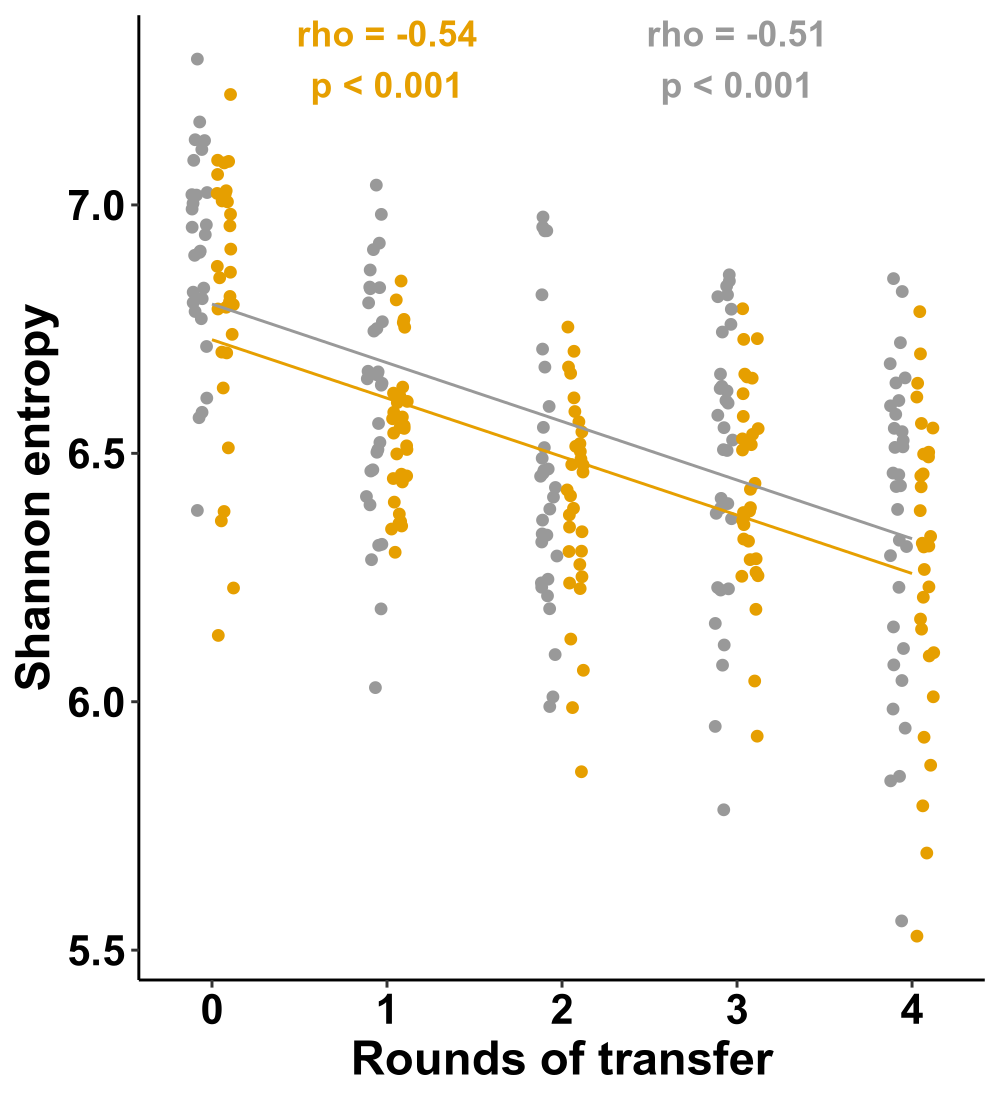

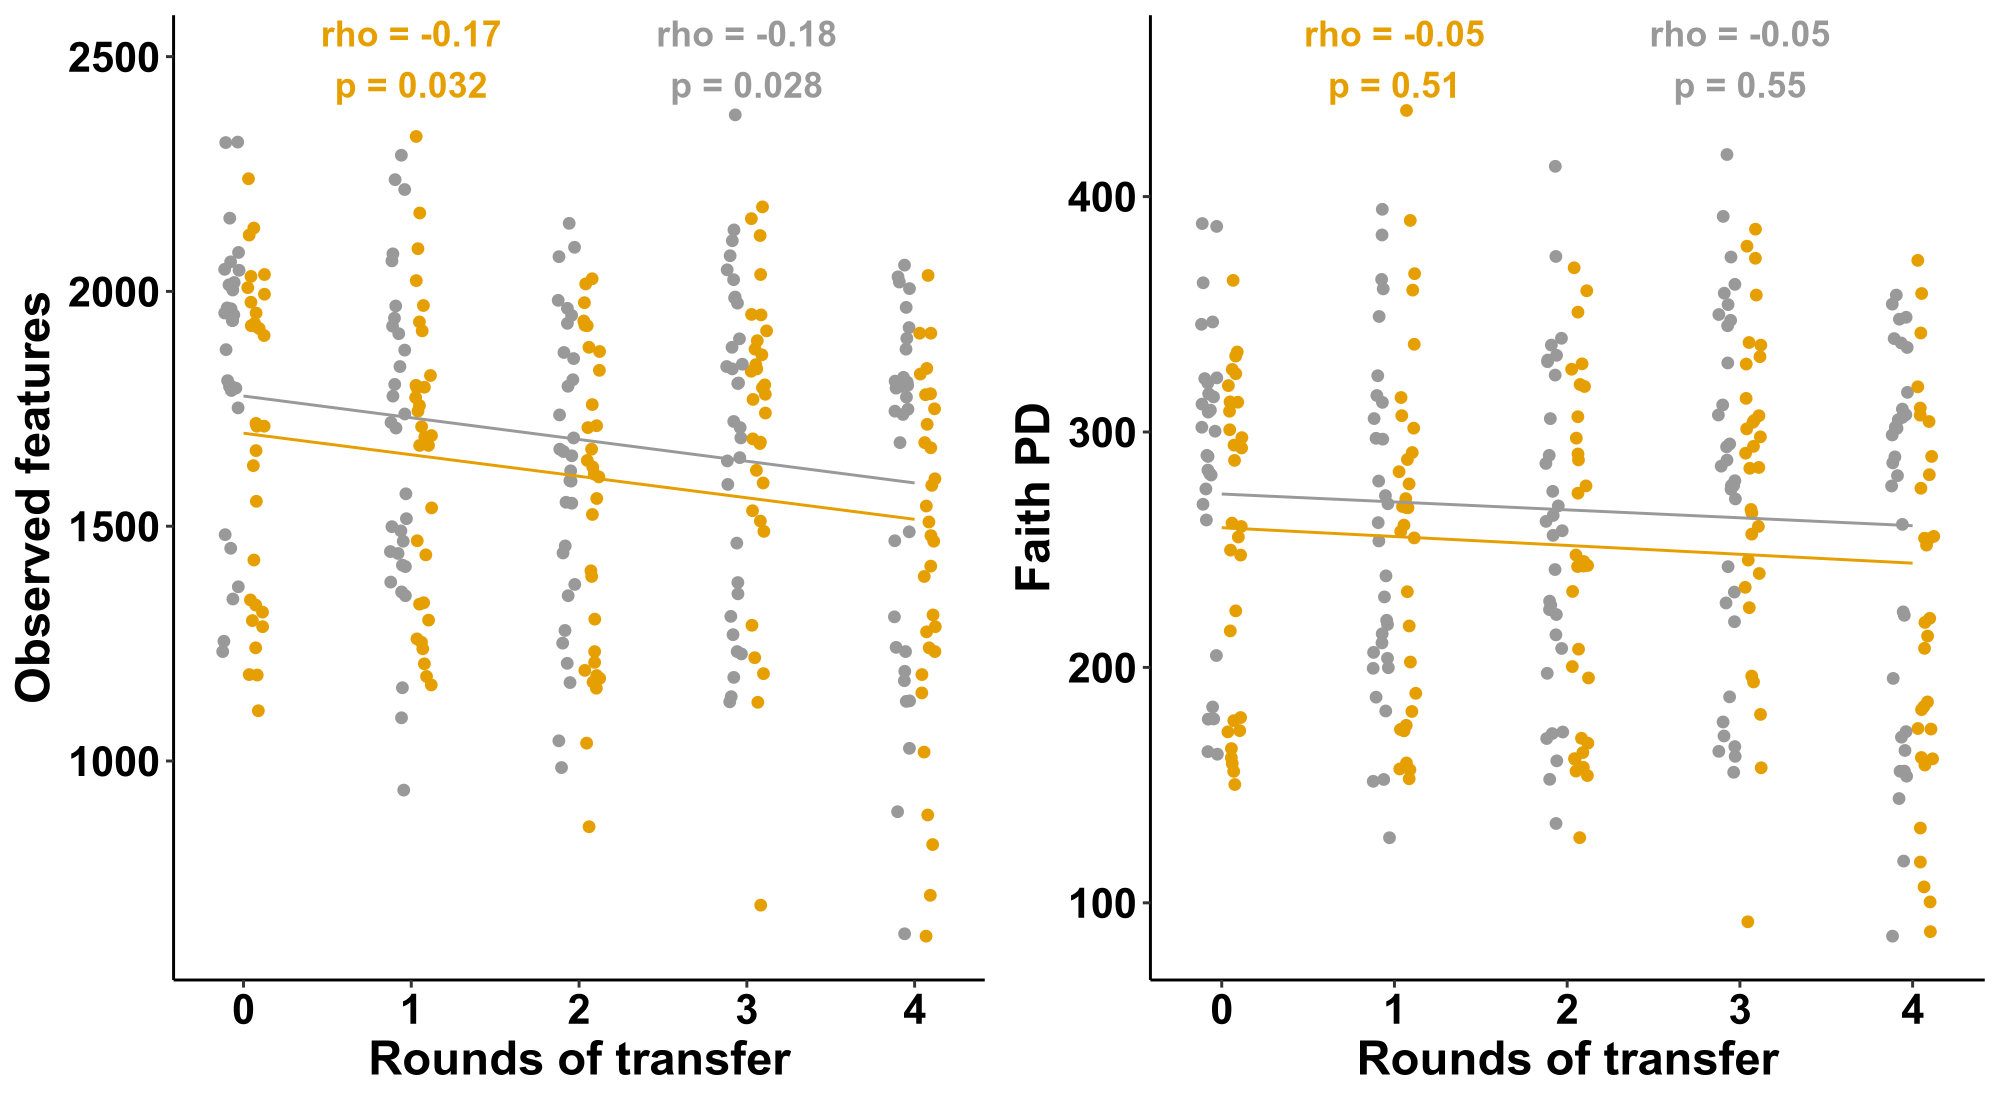

In [340]:
alpha_gen_plot = list()
# vis alignment coeffs
alpha_gen_vis_coeffs = c(1, 1.05, 1.05)
names(alpha_gen_vis_coeffs) = names(alpha_names_inv)

for(cur_am in names(alpha_names_inv)) {
  tmp = alpha_div %>% filter(alpha_measure == cur_am)
  # define max Y limit
  max_y = max(
    alpha_div %>% filter(alpha_measure == cur_am) %>% summarise(max(value)) %>% pull(),
    alpha_gen_vis_coeffs[[cur_am]] * alpha_div %>% filter(alpha_measure == cur_am & Generation_num %in% c(1, 3)) %>% summarise(max(value)) %>% pull())
  # then need to set y min as well
    min_y = alpha_div %>% filter(alpha_measure == cur_am) %>% summarise(min(value)) %>% pull()

  alpha_gen_plot[[cur_am]] = 
    ggplot(data = tmp, aes(x = Generation_num, y = value, color = TreatmentID)) +      
      labs(x = "Rounds of transfer", y = alpha_names_inv[cur_am]) +        
      geom_jitter(position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.3), size = 1.5) +      
      geom_smooth(method = lm, size = 0.5, se=FALSE, fullrange=FALSE) + 
      scale_color_manual(labels = c("Control", "Selection"), values=c('#999999','#E69F00'))+
      
      theme_classic() +
      # set max y lim
      coord_cartesian(ylim = c(min_y, max_y)) +
      theme(
            strip.background = element_blank(),            
            #panel.border = element_rect(colour = "black", linewidth = 1),           
            axis.text.x = element_text(size = 15, face = "bold", color = "black"),
            axis.text.y = element_text(size = 15, face = "bold", color = "black"),
            axis.title.x = element_text(size = 17, face = "bold", color = "black"),
            axis.title.y = element_text(size = 17, face = "bold", color = "black"), 
            legend.position = "none",
            panel.grid.major = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank() ,            
            legend.text = element_text(face="bold", size = 13)

          ) +
      guides(color = FALSE) +        
      annotate("text", x = 1, y = max_y,                  
        label = alpha_cors %>% filter(TreatmentID == "Selection" & alpha_measure == cur_am) %>% select(my_label) %>% pull(), size = 4.5, color = "#E69F00", fontface = "bold") +
      annotate("text", x = 3, y = max_y,                            
        label = alpha_cors %>% filter(TreatmentID == "Control" & alpha_measure == cur_am) %>% select(my_label) %>% pull(), size = 4.5, color = "#999999", fontface = "bold")
}

# Fig. 3A
p.dims(5, 5.5)
plot(alpha_gen_plot[[1]])

# Suppl. Fig. about other alphas
p.dims(10, 5.5)
ggpubr::ggarrange(alpha_gen_plot[[2]], alpha_gen_plot[[3]], ncol = 2, nrow = 1)